In [1]:
#=======================================
## Tree-like neural network - Glass-Identification
#=======================================

#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, concatenate, Dropout


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#----------------------------------------
# Load the Glass-Identification dataset.

dataset = np.loadtxt("Glass-Identification-Data.txt", delimiter=",")

print(type(dataset))

print(dataset.shape)

x_group = [[8], [4], [7], [3]]

X = dataset[:, 0:10]
Y = dataset[:, 10]

print(X.shape)
print(Y.shape)

X1 = dataset[:, x_group[0]]
X2 = dataset[:, x_group[1]]
X3 = dataset[:, x_group[2]]
X4 = dataset[:, x_group[3]]

print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(Y.shape)

Y = np.array(Y, dtype = int)

print(np.unique(Y))


<class 'numpy.ndarray'>
(214, 11)
(214, 10)
(214,)
(214, 1)
(214, 1)
(214, 1)
(214, 1)
(214,)
[1 2 3 5 6 7]


In [3]:
#----------------------------------------
# one-hot encoding of output variable.

Y_train = np.zeros((len(Y), 7), dtype = int)

for i in range(len(Y)):
	Y_train[i, Y[i] - 1] = 1

print(np.unique(Y_train))


[0 1]


In [4]:
#----------------------------------------
# Standardize the input data.

X_sample_mean = np.mean(X, axis = 0)
print(np.round(X_sample_mean, 4))

X_sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(X_sample_std, 4))

X1_sample_mean = X_sample_mean[x_group[0]]
print(np.round(X1_sample_mean, 4))

X1_sample_std = X_sample_std[x_group[0]]
print(np.round(X1_sample_std, 4))

X2_sample_mean = X_sample_mean[x_group[1]]
print(np.round(X2_sample_mean, 4))

X2_sample_std = X_sample_std[x_group[1]]
print(np.round(X2_sample_std, 4))

X3_sample_mean = X_sample_mean[x_group[2]]
print(np.round(X3_sample_mean, 4))

X3_sample_std = X_sample_std[x_group[2]]
print(np.round(X3_sample_std, 4))

X4_sample_mean = X_sample_mean[x_group[3]]
print(np.round(X4_sample_mean, 4))

X4_sample_std = X_sample_std[x_group[3]]
print(np.round(X4_sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

X1_train = X_train[:, x_group[0]]
X2_train = X_train[:, x_group[1]]
X3_train = X_train[:, x_group[2]]
X4_train = X_train[:, x_group[3]]

print(np.round(np.mean(X1_train, axis = 0), 4))
print(np.round(np.std(X1_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X2_train, axis = 0), 4))
print(np.round(np.std(X2_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X3_train, axis = 0), 4))
print(np.round(np.std(X3_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X4_train, axis = 0), 4))
print(np.round(np.std(X4_train, axis = 0, ddof = 1), 4))


[1.07500e+02 1.51840e+00 1.34079e+01 2.68450e+00 1.44490e+00 7.26509e+01
 4.97100e-01 8.95700e+00 1.75000e-01 5.70000e-02]
[6.19206e+01 3.00000e-03 8.16600e-01 1.44240e+00 4.99300e-01 7.74500e-01
 6.52200e-01 1.42320e+00 4.97200e-01 9.74000e-02]
[0.175]
[0.4972]
[1.4449]
[0.4993]
[8.957]
[1.4232]
[2.6845]
[1.4424]
[-0.]
[1.]
[-0.]
[1.]
[-0.]
[1.]
[-0.]
[1.]


In [5]:
#----------------------------------------
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [7]:
# 10-fold cross validation

cv_cc = []
cv_acc = []

for k in range(fold_num):
    # Build the tree like nn model
    input_g1 = Input(shape = (1,))
    x1 = input_g1
    t1 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x1)
    t1 = Dropout(rate = 0.1)(t1)
    #
    y11 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    y12 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    #
    input_g2 = Input(shape = (1,))
    x2 = concatenate([y11, input_g2], axis = 1)  # column bind
    t2 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x2)
    t2 = Dropout(rate = 0.1)(t2)
    #
    y21 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    y22 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    #
    input_g3 = Input(shape = (1,))
    x3 = concatenate([y21, input_g3], axis = 1)  # column bind
    t3 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x3)
    t3 = Dropout(rate = 0.1)(t3)
    #
    y31 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    y32 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    #
    input_g6 = Input(shape = (1,))
    x6 = concatenate([y22, input_g6], axis = 1)  # column bind
    t6 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x6)
    t6 = Dropout(rate = 0.1)(t6)
    #
    y61 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t6)
    y62 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t6)
    #
    x_final =  concatenate([y12, y31, y32, y61, y62], axis = 1)  # column bind
    y_final = Dense(units = 6, kernel_initializer = "uniform", activation = "relu")(x_final)
    y_final = Dropout(rate = 0.1)(y_final)
    y_final = Dense(units = 7, kernel_initializer = "uniform", activation = "softmax")(y_final)
    response = y_final
    #
    model = Model(inputs = [input_g1, input_g2, input_g3, input_g6], outputs = response)
    # Compile the model.
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit([X1_train[train_index], X2_train[train_index], X3_train[train_index], X4_train[train_index]]
                        , Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 20, verbose = 1)
    # Evaluate the model.
    scores = model.evaluate([X1_train[test_index], X2_train[test_index], X3_train[test_index], X4_train[test_index]]
                            , Y_train[test_index], verbose = 1)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_cc.append(scores[0])
    cv_acc.append(scores[1])


Train on 153 samples, validate on 39 samples
Epoch 1/1000
153/153 [==============================] - 2s 10ms/step - loss: 1.9432 - acc: 0.3268 - val_loss: 1.9399 - val_acc: 0.3333
Epoch 2/1000
153/153 [==============================] - 0s 261us/step - loss: 1.9364 - acc: 0.3137 - val_loss: 1.9337 - val_acc: 0.3333
Epoch 3/1000
153/153 [==============================] - 0s 313us/step - loss: 1.9292 - acc: 0.3791 - val_loss: 1.9270 - val_acc: 0.3333
Epoch 4/1000
153/153 [==============================] - 0s 288us/step - loss: 1.9210 - acc: 0.3725 - val_loss: 1.9195 - val_acc: 0.3333
Epoch 5/1000
153/153 [==============================] - 0s 208us/step - loss: 1.9123 - acc: 0.3595 - val_loss: 1.9109 - val_acc: 0.3333
Epoch 6/1000
153/153 [==============================] - 0s 193us/step - loss: 1.9021 - acc: 0.3791 - val_loss: 1.9011 - val_acc: 0.3333
Epoch 7/1000
153/153 [==============================] - 0s 198us/step - loss: 1.8905 - acc: 0.3791 - val_loss: 1.8896 - val_acc: 0.3333
Epoc

153/153 [==============================] - 0s 248us/step - loss: 1.2769 - acc: 0.4837 - val_loss: 1.3603 - val_acc: 0.4872
Epoch 61/1000
153/153 [==============================] - 0s 281us/step - loss: 1.2526 - acc: 0.4837 - val_loss: 1.3550 - val_acc: 0.4359
Epoch 62/1000
153/153 [==============================] - 0s 319us/step - loss: 1.2614 - acc: 0.4314 - val_loss: 1.3507 - val_acc: 0.4615
Epoch 63/1000
153/153 [==============================] - 0s 312us/step - loss: 1.2585 - acc: 0.4510 - val_loss: 1.3471 - val_acc: 0.4615
Epoch 64/1000
153/153 [==============================] - 0s 259us/step - loss: 1.2344 - acc: 0.4641 - val_loss: 1.3439 - val_acc: 0.4615
Epoch 65/1000
153/153 [==============================] - 0s 334us/step - loss: 1.2414 - acc: 0.4248 - val_loss: 1.3387 - val_acc: 0.4615
Epoch 66/1000
153/153 [==============================] - 0s 278us/step - loss: 1.2689 - acc: 0.4641 - val_loss: 1.3318 - val_acc: 0.4359
Epoch 67/1000
153/153 [==============================] 

Epoch 120/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0699 - acc: 0.5752 - val_loss: 1.2497 - val_acc: 0.5897
Epoch 121/1000
153/153 [==============================] - 0s 173us/step - loss: 1.1223 - acc: 0.4706 - val_loss: 1.2503 - val_acc: 0.5897
Epoch 122/1000
153/153 [==============================] - 0s 243us/step - loss: 1.0245 - acc: 0.5817 - val_loss: 1.2505 - val_acc: 0.5897
Epoch 123/1000
153/153 [==============================] - 0s 229us/step - loss: 1.0770 - acc: 0.5359 - val_loss: 1.2501 - val_acc: 0.5897
Epoch 124/1000
153/153 [==============================] - 0s 269us/step - loss: 1.0712 - acc: 0.5556 - val_loss: 1.2582 - val_acc: 0.6154
Epoch 125/1000
153/153 [==============================] - 0s 379us/step - loss: 1.0650 - acc: 0.5098 - val_loss: 1.2670 - val_acc: 0.6154
Epoch 126/1000
153/153 [==============================] - 0s 223us/step - loss: 1.0688 - acc: 0.5033 - val_loss: 1.2684 - val_acc: 0.6154
Epoch 127/1000
153/153 [==========

153/153 [==============================] - 0s 193us/step - loss: 1.0026 - acc: 0.6340 - val_loss: 1.2649 - val_acc: 0.6154
Epoch 180/1000
153/153 [==============================] - 0s 172us/step - loss: 1.0327 - acc: 0.5556 - val_loss: 1.2590 - val_acc: 0.5897
Epoch 181/1000
153/153 [==============================] - 0s 243us/step - loss: 1.0585 - acc: 0.5490 - val_loss: 1.2576 - val_acc: 0.5897
Epoch 182/1000
153/153 [==============================] - 0s 365us/step - loss: 1.0379 - acc: 0.5556 - val_loss: 1.2627 - val_acc: 0.5897
Epoch 183/1000
153/153 [==============================] - 0s 361us/step - loss: 1.0042 - acc: 0.6144 - val_loss: 1.2634 - val_acc: 0.5897
Epoch 184/1000
153/153 [==============================] - 0s 268us/step - loss: 1.0462 - acc: 0.5556 - val_loss: 1.2657 - val_acc: 0.6154
Epoch 185/1000
153/153 [==============================] - 0s 306us/step - loss: 1.0337 - acc: 0.5359 - val_loss: 1.2688 - val_acc: 0.6154
Epoch 186/1000
153/153 [=========================

153/153 [==============================] - 0s 321us/step - loss: 1.0525 - acc: 0.5556 - val_loss: 1.2608 - val_acc: 0.6410
Epoch 239/1000
153/153 [==============================] - 0s 295us/step - loss: 1.0349 - acc: 0.5752 - val_loss: 1.2552 - val_acc: 0.6154
Epoch 240/1000
153/153 [==============================] - 0s 302us/step - loss: 1.0404 - acc: 0.5621 - val_loss: 1.2529 - val_acc: 0.6154
Epoch 241/1000
153/153 [==============================] - 0s 287us/step - loss: 1.0022 - acc: 0.5752 - val_loss: 1.2521 - val_acc: 0.6154
Epoch 242/1000
153/153 [==============================] - 0s 231us/step - loss: 0.9699 - acc: 0.5752 - val_loss: 1.2530 - val_acc: 0.6410
Epoch 243/1000
153/153 [==============================] - 0s 311us/step - loss: 0.9904 - acc: 0.5948 - val_loss: 1.2457 - val_acc: 0.6154
Epoch 244/1000
153/153 [==============================] - 0s 370us/step - loss: 0.9918 - acc: 0.6013 - val_loss: 1.2486 - val_acc: 0.6154
Epoch 245/1000
153/153 [=========================

153/153 [==============================] - 0s 283us/step - loss: 1.0143 - acc: 0.6013 - val_loss: 1.2688 - val_acc: 0.6410
Epoch 298/1000
153/153 [==============================] - 0s 391us/step - loss: 0.9707 - acc: 0.5752 - val_loss: 1.2661 - val_acc: 0.6410
Epoch 299/1000
153/153 [==============================] - 0s 326us/step - loss: 0.9820 - acc: 0.6209 - val_loss: 1.2574 - val_acc: 0.6154
Epoch 300/1000
153/153 [==============================] - 0s 421us/step - loss: 0.9621 - acc: 0.5948 - val_loss: 1.2607 - val_acc: 0.6410
Epoch 301/1000
153/153 [==============================] - 0s 350us/step - loss: 0.9971 - acc: 0.5752 - val_loss: 1.2624 - val_acc: 0.6410
Epoch 302/1000
153/153 [==============================] - 0s 394us/step - loss: 0.9673 - acc: 0.5752 - val_loss: 1.2644 - val_acc: 0.6410
Epoch 303/1000
153/153 [==============================] - 0s 285us/step - loss: 1.0162 - acc: 0.5752 - val_loss: 1.2735 - val_acc: 0.6410
Epoch 304/1000
153/153 [=========================

153/153 [==============================] - 0s 348us/step - loss: 0.9606 - acc: 0.5882 - val_loss: 1.2390 - val_acc: 0.6410
Epoch 357/1000
153/153 [==============================] - 0s 278us/step - loss: 0.9880 - acc: 0.5686 - val_loss: 1.2374 - val_acc: 0.6410
Epoch 358/1000
153/153 [==============================] - 0s 255us/step - loss: 1.0419 - acc: 0.5752 - val_loss: 1.2421 - val_acc: 0.6410
Epoch 359/1000
153/153 [==============================] - 0s 239us/step - loss: 1.0106 - acc: 0.5817 - val_loss: 1.2446 - val_acc: 0.6410
Epoch 360/1000
153/153 [==============================] - 0s 254us/step - loss: 0.9782 - acc: 0.6013 - val_loss: 1.2414 - val_acc: 0.6410
Epoch 361/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9481 - acc: 0.5948 - val_loss: 1.2393 - val_acc: 0.6410
Epoch 362/1000
153/153 [==============================] - 0s 289us/step - loss: 0.9308 - acc: 0.6275 - val_loss: 1.2378 - val_acc: 0.6410
Epoch 363/1000
153/153 [=========================

153/153 [==============================] - 0s 290us/step - loss: 0.9673 - acc: 0.6144 - val_loss: 1.2209 - val_acc: 0.6667
Epoch 416/1000
153/153 [==============================] - 0s 264us/step - loss: 1.0173 - acc: 0.6013 - val_loss: 1.2221 - val_acc: 0.6667
Epoch 417/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9915 - acc: 0.5882 - val_loss: 1.2212 - val_acc: 0.6667
Epoch 418/1000
153/153 [==============================] - 0s 299us/step - loss: 0.8920 - acc: 0.6405 - val_loss: 1.2273 - val_acc: 0.6667
Epoch 419/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9904 - acc: 0.6078 - val_loss: 1.2279 - val_acc: 0.6667
Epoch 420/1000
153/153 [==============================] - 0s 230us/step - loss: 0.9294 - acc: 0.6340 - val_loss: 1.2212 - val_acc: 0.6667
Epoch 421/1000
153/153 [==============================] - 0s 342us/step - loss: 0.8973 - acc: 0.6340 - val_loss: 1.2195 - val_acc: 0.6667
Epoch 422/1000
153/153 [=========================

153/153 [==============================] - 0s 209us/step - loss: 0.8660 - acc: 0.6667 - val_loss: 1.2242 - val_acc: 0.6410
Epoch 475/1000
153/153 [==============================] - 0s 278us/step - loss: 0.9146 - acc: 0.6013 - val_loss: 1.2228 - val_acc: 0.6410
Epoch 476/1000
153/153 [==============================] - 0s 252us/step - loss: 0.9135 - acc: 0.6340 - val_loss: 1.2239 - val_acc: 0.6410
Epoch 477/1000
153/153 [==============================] - 0s 251us/step - loss: 0.9282 - acc: 0.6275 - val_loss: 1.2246 - val_acc: 0.6410
Epoch 478/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9347 - acc: 0.6340 - val_loss: 1.2255 - val_acc: 0.6154
Epoch 479/1000
153/153 [==============================] - 0s 282us/step - loss: 0.9463 - acc: 0.6013 - val_loss: 1.2297 - val_acc: 0.6410
Epoch 480/1000
153/153 [==============================] - 0s 288us/step - loss: 0.9635 - acc: 0.6144 - val_loss: 1.2310 - val_acc: 0.6154
Epoch 481/1000
153/153 [=========================

153/153 [==============================] - 0s 196us/step - loss: 1.0467 - acc: 0.5882 - val_loss: 1.2325 - val_acc: 0.6154
Epoch 534/1000
153/153 [==============================] - 0s 160us/step - loss: 0.9269 - acc: 0.6078 - val_loss: 1.2313 - val_acc: 0.6154
Epoch 535/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9922 - acc: 0.6471 - val_loss: 1.2323 - val_acc: 0.6154
Epoch 536/1000
153/153 [==============================] - 0s 277us/step - loss: 0.9349 - acc: 0.5948 - val_loss: 1.2313 - val_acc: 0.6154
Epoch 537/1000
153/153 [==============================] - 0s 204us/step - loss: 0.9872 - acc: 0.6144 - val_loss: 1.2301 - val_acc: 0.6154
Epoch 538/1000
153/153 [==============================] - 0s 284us/step - loss: 0.9513 - acc: 0.5882 - val_loss: 1.2338 - val_acc: 0.6154
Epoch 539/1000
153/153 [==============================] - 0s 244us/step - loss: 0.9816 - acc: 0.6013 - val_loss: 1.2324 - val_acc: 0.6154
Epoch 540/1000
153/153 [=========================

153/153 [==============================] - 0s 190us/step - loss: 0.8961 - acc: 0.6536 - val_loss: 1.2213 - val_acc: 0.6154
Epoch 593/1000
153/153 [==============================] - 0s 184us/step - loss: 0.9463 - acc: 0.6144 - val_loss: 1.2209 - val_acc: 0.6154
Epoch 594/1000
153/153 [==============================] - 0s 183us/step - loss: 0.9085 - acc: 0.6275 - val_loss: 1.2231 - val_acc: 0.6154
Epoch 595/1000
153/153 [==============================] - 0s 233us/step - loss: 0.9474 - acc: 0.6078 - val_loss: 1.2227 - val_acc: 0.6154
Epoch 596/1000
153/153 [==============================] - 0s 299us/step - loss: 0.9011 - acc: 0.6209 - val_loss: 1.2250 - val_acc: 0.6154
Epoch 597/1000
153/153 [==============================] - 0s 518us/step - loss: 0.8714 - acc: 0.6405 - val_loss: 1.2261 - val_acc: 0.6154
Epoch 598/1000
153/153 [==============================] - 0s 660us/step - loss: 0.9287 - acc: 0.6275 - val_loss: 1.2235 - val_acc: 0.6154
Epoch 599/1000
153/153 [=========================

153/153 [==============================] - 0s 247us/step - loss: 0.9170 - acc: 0.6144 - val_loss: 1.2407 - val_acc: 0.6154
Epoch 652/1000
153/153 [==============================] - 0s 283us/step - loss: 0.9429 - acc: 0.6013 - val_loss: 1.2411 - val_acc: 0.6154
Epoch 653/1000
153/153 [==============================] - 0s 300us/step - loss: 1.0331 - acc: 0.6078 - val_loss: 1.2427 - val_acc: 0.6154
Epoch 654/1000
153/153 [==============================] - 0s 240us/step - loss: 0.8978 - acc: 0.6144 - val_loss: 1.2468 - val_acc: 0.6154
Epoch 655/1000
153/153 [==============================] - 0s 236us/step - loss: 0.9128 - acc: 0.6536 - val_loss: 1.2488 - val_acc: 0.6154
Epoch 656/1000
153/153 [==============================] - 0s 365us/step - loss: 0.8754 - acc: 0.6601 - val_loss: 1.2513 - val_acc: 0.6154
Epoch 657/1000
153/153 [==============================] - 0s 309us/step - loss: 0.9359 - acc: 0.6340 - val_loss: 1.2559 - val_acc: 0.6410
Epoch 658/1000
153/153 [=========================

153/153 [==============================] - 0s 165us/step - loss: 0.8928 - acc: 0.6601 - val_loss: 1.2427 - val_acc: 0.6154
Epoch 711/1000
153/153 [==============================] - 0s 201us/step - loss: 0.9632 - acc: 0.6144 - val_loss: 1.2346 - val_acc: 0.6154
Epoch 712/1000
153/153 [==============================] - 0s 175us/step - loss: 0.9422 - acc: 0.6013 - val_loss: 1.2323 - val_acc: 0.6154
Epoch 713/1000
153/153 [==============================] - 0s 353us/step - loss: 0.8760 - acc: 0.6405 - val_loss: 1.2312 - val_acc: 0.6154
Epoch 714/1000
153/153 [==============================] - 0s 337us/step - loss: 0.8916 - acc: 0.6667 - val_loss: 1.2290 - val_acc: 0.6154
Epoch 715/1000
153/153 [==============================] - 0s 289us/step - loss: 0.8940 - acc: 0.6536 - val_loss: 1.2311 - val_acc: 0.6154
Epoch 716/1000
153/153 [==============================] - 0s 317us/step - loss: 0.9393 - acc: 0.6275 - val_loss: 1.2380 - val_acc: 0.6154
Epoch 717/1000
153/153 [=========================

Epoch 769/1000
153/153 [==============================] - 0s 289us/step - loss: 0.8896 - acc: 0.6209 - val_loss: 1.2432 - val_acc: 0.6154
Epoch 770/1000
153/153 [==============================] - 0s 187us/step - loss: 0.9170 - acc: 0.6471 - val_loss: 1.2410 - val_acc: 0.6154
Epoch 771/1000
153/153 [==============================] - 0s 249us/step - loss: 0.8937 - acc: 0.6405 - val_loss: 1.2419 - val_acc: 0.6154
Epoch 772/1000
153/153 [==============================] - 0s 273us/step - loss: 0.8944 - acc: 0.6471 - val_loss: 1.2454 - val_acc: 0.6154
Epoch 773/1000
153/153 [==============================] - 0s 334us/step - loss: 0.9201 - acc: 0.6405 - val_loss: 1.2476 - val_acc: 0.6154
Epoch 774/1000
153/153 [==============================] - 0s 376us/step - loss: 0.9306 - acc: 0.6405 - val_loss: 1.2457 - val_acc: 0.6154
Epoch 775/1000
153/153 [==============================] - 0s 243us/step - loss: 0.9058 - acc: 0.6405 - val_loss: 1.2428 - val_acc: 0.6154
Epoch 776/1000
153/153 [==========

153/153 [==============================] - 0s 223us/step - loss: 0.9088 - acc: 0.6405 - val_loss: 1.2277 - val_acc: 0.6154
Epoch 829/1000
153/153 [==============================] - 0s 334us/step - loss: 0.9064 - acc: 0.6536 - val_loss: 1.2271 - val_acc: 0.6154
Epoch 830/1000
153/153 [==============================] - 0s 346us/step - loss: 0.9463 - acc: 0.6209 - val_loss: 1.2275 - val_acc: 0.6154
Epoch 831/1000
153/153 [==============================] - 0s 370us/step - loss: 0.9322 - acc: 0.6405 - val_loss: 1.2232 - val_acc: 0.6154
Epoch 832/1000
153/153 [==============================] - 0s 230us/step - loss: 0.8914 - acc: 0.6471 - val_loss: 1.2217 - val_acc: 0.6154
Epoch 833/1000
153/153 [==============================] - 0s 278us/step - loss: 0.9348 - acc: 0.6405 - val_loss: 1.2222 - val_acc: 0.6154
Epoch 834/1000
153/153 [==============================] - 0s 202us/step - loss: 0.9123 - acc: 0.6340 - val_loss: 1.2203 - val_acc: 0.6154
Epoch 835/1000
153/153 [=========================

153/153 [==============================] - 0s 287us/step - loss: 0.9062 - acc: 0.6340 - val_loss: 1.2168 - val_acc: 0.6154
Epoch 888/1000
153/153 [==============================] - 0s 206us/step - loss: 0.9197 - acc: 0.6928 - val_loss: 1.2179 - val_acc: 0.6154
Epoch 889/1000
153/153 [==============================] - 0s 166us/step - loss: 0.9654 - acc: 0.6405 - val_loss: 1.2182 - val_acc: 0.6154
Epoch 890/1000
153/153 [==============================] - 0s 192us/step - loss: 0.8843 - acc: 0.6667 - val_loss: 1.2202 - val_acc: 0.6154
Epoch 891/1000
153/153 [==============================] - 0s 250us/step - loss: 0.8910 - acc: 0.6340 - val_loss: 1.2174 - val_acc: 0.6154
Epoch 892/1000
153/153 [==============================] - 0s 254us/step - loss: 0.9632 - acc: 0.6340 - val_loss: 1.2156 - val_acc: 0.6154
Epoch 893/1000
153/153 [==============================] - 0s 333us/step - loss: 0.9062 - acc: 0.6405 - val_loss: 1.2153 - val_acc: 0.6154
Epoch 894/1000
153/153 [=========================

153/153 [==============================] - 0s 184us/step - loss: 0.9086 - acc: 0.6340 - val_loss: 1.2092 - val_acc: 0.6154
Epoch 947/1000
153/153 [==============================] - 0s 253us/step - loss: 0.8504 - acc: 0.6797 - val_loss: 1.2115 - val_acc: 0.6154
Epoch 948/1000
153/153 [==============================] - 0s 213us/step - loss: 0.9323 - acc: 0.6013 - val_loss: 1.2121 - val_acc: 0.6154
Epoch 949/1000
153/153 [==============================] - 0s 241us/step - loss: 0.8431 - acc: 0.6797 - val_loss: 1.2134 - val_acc: 0.6154
Epoch 950/1000
153/153 [==============================] - 0s 290us/step - loss: 0.9327 - acc: 0.6471 - val_loss: 1.2129 - val_acc: 0.6154
Epoch 951/1000
153/153 [==============================] - 0s 160us/step - loss: 0.8473 - acc: 0.6340 - val_loss: 1.2144 - val_acc: 0.6154
Epoch 952/1000
153/153 [==============================] - 0s 318us/step - loss: 0.9067 - acc: 0.6144 - val_loss: 1.2140 - val_acc: 0.6154
Epoch 953/1000
153/153 [=========================

153/153 [==============================] - 0s 324us/step - loss: 1.9275 - acc: 0.3137 - val_loss: 1.9241 - val_acc: 0.3333
Epoch 5/1000
153/153 [==============================] - 0s 297us/step - loss: 1.9219 - acc: 0.2680 - val_loss: 1.9180 - val_acc: 0.4872
Epoch 6/1000
153/153 [==============================] - 0s 370us/step - loss: 1.9153 - acc: 0.2941 - val_loss: 1.9114 - val_acc: 0.3333
Epoch 7/1000
153/153 [==============================] - 0s 374us/step - loss: 1.9084 - acc: 0.2941 - val_loss: 1.9043 - val_acc: 0.3333
Epoch 8/1000
153/153 [==============================] - 0s 274us/step - loss: 1.9011 - acc: 0.3137 - val_loss: 1.8959 - val_acc: 0.3333
Epoch 9/1000
153/153 [==============================] - 0s 275us/step - loss: 1.8927 - acc: 0.3268 - val_loss: 1.8867 - val_acc: 0.3333
Epoch 10/1000
153/153 [==============================] - 0s 329us/step - loss: 1.8824 - acc: 0.3137 - val_loss: 1.8767 - val_acc: 0.3333
Epoch 11/1000
153/153 [==============================] - 0s 

Epoch 64/1000
153/153 [==============================] - 0s 304us/step - loss: 1.3517 - acc: 0.3595 - val_loss: 1.3915 - val_acc: 0.3846
Epoch 65/1000
153/153 [==============================] - 0s 378us/step - loss: 1.3554 - acc: 0.3922 - val_loss: 1.3912 - val_acc: 0.4103
Epoch 66/1000
153/153 [==============================] - 0s 283us/step - loss: 1.3325 - acc: 0.3987 - val_loss: 1.3904 - val_acc: 0.4615
Epoch 67/1000
153/153 [==============================] - 0s 318us/step - loss: 1.3443 - acc: 0.4314 - val_loss: 1.3883 - val_acc: 0.4615
Epoch 68/1000
153/153 [==============================] - 0s 332us/step - loss: 1.3326 - acc: 0.4379 - val_loss: 1.3863 - val_acc: 0.4359
Epoch 69/1000
153/153 [==============================] - 0s 327us/step - loss: 1.3280 - acc: 0.4641 - val_loss: 1.3837 - val_acc: 0.4359
Epoch 70/1000
153/153 [==============================] - 0s 364us/step - loss: 1.3467 - acc: 0.4510 - val_loss: 1.3767 - val_acc: 0.4359
Epoch 71/1000
153/153 [==================

153/153 [==============================] - 0s 187us/step - loss: 1.0813 - acc: 0.5425 - val_loss: 1.3197 - val_acc: 0.4359
Epoch 124/1000
153/153 [==============================] - 0s 205us/step - loss: 1.0713 - acc: 0.5556 - val_loss: 1.3217 - val_acc: 0.4359
Epoch 125/1000
153/153 [==============================] - 0s 204us/step - loss: 1.1278 - acc: 0.5098 - val_loss: 1.3181 - val_acc: 0.4359
Epoch 126/1000
153/153 [==============================] - 0s 256us/step - loss: 1.0890 - acc: 0.5098 - val_loss: 1.3176 - val_acc: 0.4359
Epoch 127/1000
153/153 [==============================] - 0s 327us/step - loss: 1.1079 - acc: 0.4771 - val_loss: 1.3167 - val_acc: 0.4359
Epoch 128/1000
153/153 [==============================] - 0s 373us/step - loss: 1.1059 - acc: 0.5621 - val_loss: 1.3161 - val_acc: 0.4359
Epoch 129/1000
153/153 [==============================] - 0s 284us/step - loss: 1.0985 - acc: 0.4902 - val_loss: 1.3132 - val_acc: 0.4359
Epoch 130/1000
153/153 [=========================

153/153 [==============================] - 0s 209us/step - loss: 1.0576 - acc: 0.5425 - val_loss: 1.2812 - val_acc: 0.4615
Epoch 183/1000
153/153 [==============================] - 0s 315us/step - loss: 1.0827 - acc: 0.5098 - val_loss: 1.2780 - val_acc: 0.4615
Epoch 184/1000
153/153 [==============================] - 0s 281us/step - loss: 1.0301 - acc: 0.5359 - val_loss: 1.2802 - val_acc: 0.4615
Epoch 185/1000
153/153 [==============================] - 0s 342us/step - loss: 1.0514 - acc: 0.5033 - val_loss: 1.2761 - val_acc: 0.4615
Epoch 186/1000
153/153 [==============================] - 0s 288us/step - loss: 1.0191 - acc: 0.5425 - val_loss: 1.2741 - val_acc: 0.4615
Epoch 187/1000
153/153 [==============================] - 0s 298us/step - loss: 1.0310 - acc: 0.5294 - val_loss: 1.2729 - val_acc: 0.4615
Epoch 188/1000
153/153 [==============================] - 0s 393us/step - loss: 1.0513 - acc: 0.5229 - val_loss: 1.2747 - val_acc: 0.4615
Epoch 189/1000
153/153 [=========================

153/153 [==============================] - 0s 171us/step - loss: 1.0249 - acc: 0.5556 - val_loss: 1.2548 - val_acc: 0.4615
Epoch 242/1000
153/153 [==============================] - 0s 171us/step - loss: 0.9843 - acc: 0.5686 - val_loss: 1.2547 - val_acc: 0.4615
Epoch 243/1000
153/153 [==============================] - 0s 204us/step - loss: 1.0147 - acc: 0.5294 - val_loss: 1.2539 - val_acc: 0.4872
Epoch 244/1000
153/153 [==============================] - 0s 286us/step - loss: 0.9956 - acc: 0.5817 - val_loss: 1.2532 - val_acc: 0.4872
Epoch 245/1000
153/153 [==============================] - 0s 238us/step - loss: 1.1424 - acc: 0.4967 - val_loss: 1.2517 - val_acc: 0.4872
Epoch 246/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0650 - acc: 0.5163 - val_loss: 1.2490 - val_acc: 0.4615
Epoch 247/1000
153/153 [==============================] - 0s 275us/step - loss: 0.9532 - acc: 0.6078 - val_loss: 1.2506 - val_acc: 0.4872
Epoch 248/1000
153/153 [=========================

153/153 [==============================] - 0s 185us/step - loss: 1.0315 - acc: 0.5359 - val_loss: 1.2398 - val_acc: 0.5128
Epoch 301/1000
153/153 [==============================] - 0s 204us/step - loss: 1.0655 - acc: 0.4771 - val_loss: 1.2398 - val_acc: 0.5385
Epoch 302/1000
153/153 [==============================] - 0s 219us/step - loss: 1.0322 - acc: 0.5425 - val_loss: 1.2382 - val_acc: 0.5641
Epoch 303/1000
153/153 [==============================] - 0s 284us/step - loss: 1.0198 - acc: 0.4967 - val_loss: 1.2385 - val_acc: 0.5128
Epoch 304/1000
153/153 [==============================] - 0s 273us/step - loss: 0.9562 - acc: 0.6144 - val_loss: 1.2414 - val_acc: 0.5128
Epoch 305/1000
153/153 [==============================] - 0s 313us/step - loss: 1.0049 - acc: 0.5556 - val_loss: 1.2412 - val_acc: 0.5128
Epoch 306/1000
153/153 [==============================] - 0s 308us/step - loss: 1.0551 - acc: 0.4967 - val_loss: 1.2400 - val_acc: 0.5128
Epoch 307/1000
153/153 [=========================

153/153 [==============================] - 0s 271us/step - loss: 0.9788 - acc: 0.6144 - val_loss: 1.2653 - val_acc: 0.5128
Epoch 360/1000
153/153 [==============================] - 0s 238us/step - loss: 0.9619 - acc: 0.5098 - val_loss: 1.2641 - val_acc: 0.5128
Epoch 361/1000
153/153 [==============================] - 0s 253us/step - loss: 1.0173 - acc: 0.5490 - val_loss: 1.2628 - val_acc: 0.5128
Epoch 362/1000
153/153 [==============================] - 0s 301us/step - loss: 0.9309 - acc: 0.5490 - val_loss: 1.2639 - val_acc: 0.5128
Epoch 363/1000
153/153 [==============================] - 0s 310us/step - loss: 0.9565 - acc: 0.5882 - val_loss: 1.2664 - val_acc: 0.5128
Epoch 364/1000
153/153 [==============================] - 0s 283us/step - loss: 0.9957 - acc: 0.5882 - val_loss: 1.2683 - val_acc: 0.5128
Epoch 365/1000
153/153 [==============================] - 0s 300us/step - loss: 0.9834 - acc: 0.5098 - val_loss: 1.2673 - val_acc: 0.5128
Epoch 366/1000
153/153 [=========================

153/153 [==============================] - 0s 194us/step - loss: 0.9913 - acc: 0.5425 - val_loss: 1.2611 - val_acc: 0.5128
Epoch 419/1000
153/153 [==============================] - 0s 173us/step - loss: 0.9915 - acc: 0.6013 - val_loss: 1.2613 - val_acc: 0.5128
Epoch 420/1000
153/153 [==============================] - 0s 203us/step - loss: 0.9605 - acc: 0.5621 - val_loss: 1.2657 - val_acc: 0.5128
Epoch 421/1000
153/153 [==============================] - 0s 307us/step - loss: 0.9768 - acc: 0.5752 - val_loss: 1.2647 - val_acc: 0.5128
Epoch 422/1000
153/153 [==============================] - 0s 312us/step - loss: 0.9928 - acc: 0.5817 - val_loss: 1.2621 - val_acc: 0.5128
Epoch 423/1000
153/153 [==============================] - 0s 287us/step - loss: 0.9595 - acc: 0.5882 - val_loss: 1.2576 - val_acc: 0.5641
Epoch 424/1000
153/153 [==============================] - 0s 353us/step - loss: 0.9741 - acc: 0.5229 - val_loss: 1.2559 - val_acc: 0.6154
Epoch 425/1000
153/153 [=========================

153/153 [==============================] - 0s 185us/step - loss: 0.9159 - acc: 0.5817 - val_loss: 1.2645 - val_acc: 0.5641
Epoch 478/1000
153/153 [==============================] - 0s 208us/step - loss: 0.9394 - acc: 0.5425 - val_loss: 1.2641 - val_acc: 0.5641
Epoch 479/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9682 - acc: 0.5752 - val_loss: 1.2617 - val_acc: 0.5641
Epoch 480/1000
153/153 [==============================] - 0s 216us/step - loss: 0.9689 - acc: 0.5425 - val_loss: 1.2572 - val_acc: 0.6410
Epoch 481/1000
153/153 [==============================] - 0s 252us/step - loss: 1.0077 - acc: 0.5556 - val_loss: 1.2564 - val_acc: 0.6410
Epoch 482/1000
153/153 [==============================] - 0s 276us/step - loss: 0.9436 - acc: 0.5621 - val_loss: 1.2591 - val_acc: 0.6154
Epoch 483/1000
153/153 [==============================] - 0s 279us/step - loss: 0.9535 - acc: 0.5686 - val_loss: 1.2615 - val_acc: 0.5641
Epoch 484/1000
153/153 [=========================

153/153 [==============================] - 0s 202us/step - loss: 0.9391 - acc: 0.5752 - val_loss: 1.2495 - val_acc: 0.5128
Epoch 537/1000
153/153 [==============================] - 0s 207us/step - loss: 0.9493 - acc: 0.5948 - val_loss: 1.2497 - val_acc: 0.5128
Epoch 538/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9578 - acc: 0.5425 - val_loss: 1.2503 - val_acc: 0.5128
Epoch 539/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9557 - acc: 0.5425 - val_loss: 1.2487 - val_acc: 0.5128
Epoch 540/1000
153/153 [==============================] - 0s 192us/step - loss: 0.9228 - acc: 0.6013 - val_loss: 1.2403 - val_acc: 0.5641
Epoch 541/1000
153/153 [==============================] - 0s 315us/step - loss: 0.9269 - acc: 0.5948 - val_loss: 1.2361 - val_acc: 0.5897
Epoch 542/1000
153/153 [==============================] - 0s 277us/step - loss: 0.9236 - acc: 0.5556 - val_loss: 1.2336 - val_acc: 0.6154
Epoch 543/1000
153/153 [=========================

153/153 [==============================] - 0s 181us/step - loss: 0.8921 - acc: 0.6013 - val_loss: 1.2258 - val_acc: 0.6667
Epoch 596/1000
153/153 [==============================] - 0s 238us/step - loss: 0.9437 - acc: 0.5621 - val_loss: 1.2294 - val_acc: 0.6667
Epoch 597/1000
153/153 [==============================] - 0s 347us/step - loss: 0.9164 - acc: 0.5621 - val_loss: 1.2330 - val_acc: 0.6667
Epoch 598/1000
153/153 [==============================] - 0s 336us/step - loss: 0.9204 - acc: 0.6013 - val_loss: 1.2279 - val_acc: 0.6667
Epoch 599/1000
153/153 [==============================] - 0s 343us/step - loss: 0.9361 - acc: 0.5948 - val_loss: 1.2242 - val_acc: 0.6667
Epoch 600/1000
153/153 [==============================] - 0s 329us/step - loss: 0.8943 - acc: 0.6144 - val_loss: 1.2257 - val_acc: 0.6667
Epoch 601/1000
153/153 [==============================] - 0s 280us/step - loss: 0.9281 - acc: 0.6275 - val_loss: 1.2240 - val_acc: 0.6667
Epoch 602/1000
153/153 [=========================

153/153 [==============================] - 0s 329us/step - loss: 0.9035 - acc: 0.6013 - val_loss: 1.2205 - val_acc: 0.6667
Epoch 655/1000
153/153 [==============================] - 0s 403us/step - loss: 0.9145 - acc: 0.5948 - val_loss: 1.2220 - val_acc: 0.6667
Epoch 656/1000
153/153 [==============================] - 0s 369us/step - loss: 0.9105 - acc: 0.5948 - val_loss: 1.2160 - val_acc: 0.6667
Epoch 657/1000
153/153 [==============================] - 0s 329us/step - loss: 0.9171 - acc: 0.6013 - val_loss: 1.2089 - val_acc: 0.6667
Epoch 658/1000
153/153 [==============================] - 0s 287us/step - loss: 0.9167 - acc: 0.6340 - val_loss: 1.2106 - val_acc: 0.6667
Epoch 659/1000
153/153 [==============================] - 0s 284us/step - loss: 0.9168 - acc: 0.5817 - val_loss: 1.2072 - val_acc: 0.6667
Epoch 660/1000
153/153 [==============================] - 0s 319us/step - loss: 0.9275 - acc: 0.6013 - val_loss: 1.2052 - val_acc: 0.6667
Epoch 661/1000
153/153 [=========================

153/153 [==============================] - 0s 324us/step - loss: 0.9299 - acc: 0.5882 - val_loss: 1.2045 - val_acc: 0.6667
Epoch 714/1000
153/153 [==============================] - 0s 356us/step - loss: 0.9482 - acc: 0.5621 - val_loss: 1.2039 - val_acc: 0.6667
Epoch 715/1000
153/153 [==============================] - 0s 318us/step - loss: 0.9056 - acc: 0.6078 - val_loss: 1.2020 - val_acc: 0.6667
Epoch 716/1000
153/153 [==============================] - 0s 369us/step - loss: 0.8692 - acc: 0.6340 - val_loss: 1.1961 - val_acc: 0.6667
Epoch 717/1000
153/153 [==============================] - 0s 323us/step - loss: 0.9008 - acc: 0.6144 - val_loss: 1.1925 - val_acc: 0.6667
Epoch 718/1000
153/153 [==============================] - 0s 334us/step - loss: 0.8975 - acc: 0.6405 - val_loss: 1.1924 - val_acc: 0.6667
Epoch 719/1000
153/153 [==============================] - 0s 302us/step - loss: 0.8746 - acc: 0.6013 - val_loss: 1.1913 - val_acc: 0.6667
Epoch 720/1000
153/153 [=========================

153/153 [==============================] - 0s 219us/step - loss: 0.8979 - acc: 0.6078 - val_loss: 1.1827 - val_acc: 0.6667
Epoch 773/1000
153/153 [==============================] - 0s 183us/step - loss: 0.9188 - acc: 0.6013 - val_loss: 1.1830 - val_acc: 0.6667
Epoch 774/1000
153/153 [==============================] - 0s 189us/step - loss: 0.9797 - acc: 0.5686 - val_loss: 1.1803 - val_acc: 0.6667
Epoch 775/1000
153/153 [==============================] - 0s 190us/step - loss: 0.9263 - acc: 0.6078 - val_loss: 1.1781 - val_acc: 0.6667
Epoch 776/1000
153/153 [==============================] - 0s 297us/step - loss: 0.8886 - acc: 0.6144 - val_loss: 1.1791 - val_acc: 0.6667
Epoch 777/1000
153/153 [==============================] - 0s 292us/step - loss: 0.9096 - acc: 0.6209 - val_loss: 1.1810 - val_acc: 0.6667
Epoch 778/1000
153/153 [==============================] - 0s 371us/step - loss: 0.8936 - acc: 0.6209 - val_loss: 1.1774 - val_acc: 0.6667
Epoch 779/1000
153/153 [=========================

153/153 [==============================] - 0s 369us/step - loss: 0.9401 - acc: 0.5686 - val_loss: 1.1879 - val_acc: 0.6667
Epoch 832/1000
153/153 [==============================] - 0s 314us/step - loss: 0.8750 - acc: 0.6013 - val_loss: 1.1868 - val_acc: 0.6667
Epoch 833/1000
153/153 [==============================] - 0s 231us/step - loss: 0.9177 - acc: 0.5948 - val_loss: 1.1858 - val_acc: 0.6667
Epoch 834/1000
153/153 [==============================] - 0s 181us/step - loss: 0.8933 - acc: 0.5948 - val_loss: 1.1856 - val_acc: 0.6667
Epoch 835/1000
153/153 [==============================] - 0s 208us/step - loss: 0.9512 - acc: 0.5621 - val_loss: 1.1841 - val_acc: 0.6667
Epoch 836/1000
153/153 [==============================] - 0s 226us/step - loss: 0.8952 - acc: 0.6209 - val_loss: 1.1817 - val_acc: 0.6667
Epoch 837/1000
153/153 [==============================] - 0s 274us/step - loss: 0.9142 - acc: 0.6209 - val_loss: 1.1802 - val_acc: 0.6667
Epoch 838/1000
153/153 [=========================

153/153 [==============================] - 0s 139us/step - loss: 0.9221 - acc: 0.5686 - val_loss: 1.1728 - val_acc: 0.6667
Epoch 891/1000
153/153 [==============================] - 0s 187us/step - loss: 0.9120 - acc: 0.6013 - val_loss: 1.1764 - val_acc: 0.6667
Epoch 892/1000
153/153 [==============================] - 0s 255us/step - loss: 0.8626 - acc: 0.6144 - val_loss: 1.1767 - val_acc: 0.6667
Epoch 893/1000
153/153 [==============================] - 0s 326us/step - loss: 0.8543 - acc: 0.6471 - val_loss: 1.1757 - val_acc: 0.6667
Epoch 894/1000
153/153 [==============================] - 0s 299us/step - loss: 0.9299 - acc: 0.5752 - val_loss: 1.1787 - val_acc: 0.6667
Epoch 895/1000
153/153 [==============================] - 0s 303us/step - loss: 0.8445 - acc: 0.6209 - val_loss: 1.1785 - val_acc: 0.6667
Epoch 896/1000
153/153 [==============================] - 0s 313us/step - loss: 0.8904 - acc: 0.6078 - val_loss: 1.1807 - val_acc: 0.6667
Epoch 897/1000
153/153 [=========================

153/153 [==============================] - 0s 320us/step - loss: 0.8860 - acc: 0.6078 - val_loss: 1.1626 - val_acc: 0.6667
Epoch 950/1000
153/153 [==============================] - 0s 235us/step - loss: 0.9327 - acc: 0.6144 - val_loss: 1.1647 - val_acc: 0.6667
Epoch 951/1000
153/153 [==============================] - 0s 246us/step - loss: 0.9373 - acc: 0.5686 - val_loss: 1.1649 - val_acc: 0.6667
Epoch 952/1000
153/153 [==============================] - 0s 236us/step - loss: 0.8649 - acc: 0.6144 - val_loss: 1.1651 - val_acc: 0.6667
Epoch 953/1000
153/153 [==============================] - 0s 279us/step - loss: 0.9250 - acc: 0.5948 - val_loss: 1.1668 - val_acc: 0.6667
Epoch 954/1000
153/153 [==============================] - 0s 327us/step - loss: 0.8887 - acc: 0.6732 - val_loss: 1.1684 - val_acc: 0.6667
Epoch 955/1000
153/153 [==============================] - 0s 292us/step - loss: 0.9028 - acc: 0.5425 - val_loss: 1.1701 - val_acc: 0.6667
Epoch 956/1000
153/153 [=========================

153/153 [==============================] - 0s 195us/step - loss: 1.9041 - acc: 0.3268 - val_loss: 1.9004 - val_acc: 0.3333
Epoch 8/1000
153/153 [==============================] - 0s 282us/step - loss: 1.8946 - acc: 0.3660 - val_loss: 1.8914 - val_acc: 0.3333
Epoch 9/1000
153/153 [==============================] - 0s 287us/step - loss: 1.8849 - acc: 0.3660 - val_loss: 1.8812 - val_acc: 0.3333
Epoch 10/1000
153/153 [==============================] - 0s 240us/step - loss: 1.8739 - acc: 0.3660 - val_loss: 1.8695 - val_acc: 0.3333
Epoch 11/1000
153/153 [==============================] - 0s 219us/step - loss: 1.8603 - acc: 0.3595 - val_loss: 1.8563 - val_acc: 0.3333
Epoch 12/1000
153/153 [==============================] - 0s 298us/step - loss: 1.8467 - acc: 0.3268 - val_loss: 1.8413 - val_acc: 0.3333
Epoch 13/1000
153/153 [==============================] - 0s 493us/step - loss: 1.8305 - acc: 0.3529 - val_loss: 1.8243 - val_acc: 0.3333
Epoch 14/1000
153/153 [==============================] - 

Epoch 67/1000
153/153 [==============================] - 0s 297us/step - loss: 1.2345 - acc: 0.5033 - val_loss: 1.2668 - val_acc: 0.5128
Epoch 68/1000
153/153 [==============================] - 0s 320us/step - loss: 1.2218 - acc: 0.5229 - val_loss: 1.2612 - val_acc: 0.5128
Epoch 69/1000
153/153 [==============================] - 0s 339us/step - loss: 1.2224 - acc: 0.5229 - val_loss: 1.2573 - val_acc: 0.5128
Epoch 70/1000
153/153 [==============================] - 0s 311us/step - loss: 1.2217 - acc: 0.4967 - val_loss: 1.2539 - val_acc: 0.5128
Epoch 71/1000
153/153 [==============================] - 0s 377us/step - loss: 1.1919 - acc: 0.5033 - val_loss: 1.2459 - val_acc: 0.5128
Epoch 72/1000
153/153 [==============================] - 0s 261us/step - loss: 1.1928 - acc: 0.5033 - val_loss: 1.2433 - val_acc: 0.5128
Epoch 73/1000
153/153 [==============================] - 0s 205us/step - loss: 1.1684 - acc: 0.5033 - val_loss: 1.2402 - val_acc: 0.5128
Epoch 74/1000
153/153 [==================

153/153 [==============================] - 0s 251us/step - loss: 1.0682 - acc: 0.5359 - val_loss: 1.2565 - val_acc: 0.5897
Epoch 127/1000
153/153 [==============================] - 0s 162us/step - loss: 1.0190 - acc: 0.6078 - val_loss: 1.2557 - val_acc: 0.5897
Epoch 128/1000
153/153 [==============================] - 0s 159us/step - loss: 1.0771 - acc: 0.5359 - val_loss: 1.2575 - val_acc: 0.5641
Epoch 129/1000
153/153 [==============================] - 0s 202us/step - loss: 1.0979 - acc: 0.4706 - val_loss: 1.2560 - val_acc: 0.5897
Epoch 130/1000
153/153 [==============================] - 0s 221us/step - loss: 1.0893 - acc: 0.5163 - val_loss: 1.2611 - val_acc: 0.5641
Epoch 131/1000
153/153 [==============================] - 0s 291us/step - loss: 1.0616 - acc: 0.5752 - val_loss: 1.2677 - val_acc: 0.5641
Epoch 132/1000
153/153 [==============================] - 0s 329us/step - loss: 1.0395 - acc: 0.5817 - val_loss: 1.2699 - val_acc: 0.5641
Epoch 133/1000
153/153 [=========================

153/153 [==============================] - 0s 221us/step - loss: 1.0579 - acc: 0.5490 - val_loss: 1.3897 - val_acc: 0.6154
Epoch 186/1000
153/153 [==============================] - 0s 211us/step - loss: 1.0439 - acc: 0.5817 - val_loss: 1.3951 - val_acc: 0.6154
Epoch 187/1000
153/153 [==============================] - 0s 254us/step - loss: 1.0704 - acc: 0.5229 - val_loss: 1.3927 - val_acc: 0.6154
Epoch 188/1000
153/153 [==============================] - 0s 213us/step - loss: 1.0089 - acc: 0.5556 - val_loss: 1.3991 - val_acc: 0.6154
Epoch 189/1000
153/153 [==============================] - 0s 301us/step - loss: 1.0477 - acc: 0.5556 - val_loss: 1.4087 - val_acc: 0.6154
Epoch 190/1000
153/153 [==============================] - 0s 298us/step - loss: 1.0740 - acc: 0.5425 - val_loss: 1.4080 - val_acc: 0.6154
Epoch 191/1000
153/153 [==============================] - 0s 368us/step - loss: 0.9997 - acc: 0.5948 - val_loss: 1.4084 - val_acc: 0.6154
Epoch 192/1000
153/153 [=========================

153/153 [==============================] - 0s 192us/step - loss: 1.0399 - acc: 0.5490 - val_loss: 1.4477 - val_acc: 0.6154
Epoch 245/1000
153/153 [==============================] - 0s 209us/step - loss: 1.0391 - acc: 0.5621 - val_loss: 1.4478 - val_acc: 0.6154
Epoch 246/1000
153/153 [==============================] - 0s 263us/step - loss: 1.0708 - acc: 0.5359 - val_loss: 1.4526 - val_acc: 0.6154
Epoch 247/1000
153/153 [==============================] - 0s 236us/step - loss: 1.1588 - acc: 0.5294 - val_loss: 1.4586 - val_acc: 0.6154
Epoch 248/1000
153/153 [==============================] - 0s 301us/step - loss: 0.9975 - acc: 0.5621 - val_loss: 1.4560 - val_acc: 0.6154
Epoch 249/1000
153/153 [==============================] - 0s 299us/step - loss: 1.0511 - acc: 0.5425 - val_loss: 1.4496 - val_acc: 0.6154
Epoch 250/1000
153/153 [==============================] - 0s 250us/step - loss: 1.0484 - acc: 0.5621 - val_loss: 1.4446 - val_acc: 0.6154
Epoch 251/1000
153/153 [=========================

153/153 [==============================] - 0s 268us/step - loss: 1.0166 - acc: 0.5817 - val_loss: 1.4979 - val_acc: 0.6154
Epoch 304/1000
153/153 [==============================] - 0s 297us/step - loss: 0.9565 - acc: 0.6209 - val_loss: 1.4919 - val_acc: 0.6154
Epoch 305/1000
153/153 [==============================] - 0s 312us/step - loss: 0.9587 - acc: 0.5948 - val_loss: 1.4958 - val_acc: 0.6154
Epoch 306/1000
153/153 [==============================] - 0s 296us/step - loss: 1.0300 - acc: 0.5882 - val_loss: 1.4976 - val_acc: 0.6154
Epoch 307/1000
153/153 [==============================] - 0s 311us/step - loss: 0.9606 - acc: 0.5948 - val_loss: 1.5015 - val_acc: 0.6154
Epoch 308/1000
153/153 [==============================] - 0s 341us/step - loss: 0.9845 - acc: 0.5752 - val_loss: 1.5040 - val_acc: 0.6154
Epoch 309/1000
153/153 [==============================] - 0s 327us/step - loss: 1.1039 - acc: 0.5425 - val_loss: 1.4994 - val_acc: 0.6154
Epoch 310/1000
153/153 [=========================

153/153 [==============================] - 0s 191us/step - loss: 0.9799 - acc: 0.5686 - val_loss: 1.5640 - val_acc: 0.6154
Epoch 363/1000
153/153 [==============================] - 0s 201us/step - loss: 0.9807 - acc: 0.5882 - val_loss: 1.5645 - val_acc: 0.5897
Epoch 364/1000
153/153 [==============================] - 0s 194us/step - loss: 0.9912 - acc: 0.6013 - val_loss: 1.5644 - val_acc: 0.5897
Epoch 365/1000
153/153 [==============================] - 0s 244us/step - loss: 0.9942 - acc: 0.6536 - val_loss: 1.5639 - val_acc: 0.5897
Epoch 366/1000
153/153 [==============================] - 0s 273us/step - loss: 0.9820 - acc: 0.6013 - val_loss: 1.5656 - val_acc: 0.6154
Epoch 367/1000
153/153 [==============================] - 0s 343us/step - loss: 1.0085 - acc: 0.6471 - val_loss: 1.5700 - val_acc: 0.5897
Epoch 368/1000
153/153 [==============================] - 0s 227us/step - loss: 0.9933 - acc: 0.6405 - val_loss: 1.5663 - val_acc: 0.5897
Epoch 369/1000
153/153 [=========================

153/153 [==============================] - 0s 308us/step - loss: 0.9885 - acc: 0.6471 - val_loss: 1.6073 - val_acc: 0.6154
Epoch 422/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9853 - acc: 0.6078 - val_loss: 1.6048 - val_acc: 0.6154
Epoch 423/1000
153/153 [==============================] - 0s 227us/step - loss: 1.0162 - acc: 0.6078 - val_loss: 1.6067 - val_acc: 0.6154
Epoch 424/1000
153/153 [==============================] - 0s 204us/step - loss: 0.9542 - acc: 0.6078 - val_loss: 1.6066 - val_acc: 0.6154
Epoch 425/1000
153/153 [==============================] - 0s 193us/step - loss: 0.9592 - acc: 0.6078 - val_loss: 1.6071 - val_acc: 0.6154
Epoch 426/1000
153/153 [==============================] - 0s 175us/step - loss: 0.9697 - acc: 0.6471 - val_loss: 1.6118 - val_acc: 0.6154
Epoch 427/1000
153/153 [==============================] - 0s 170us/step - loss: 0.9963 - acc: 0.6340 - val_loss: 1.6126 - val_acc: 0.6154
Epoch 428/1000
153/153 [=========================

153/153 [==============================] - 0s 478us/step - loss: 1.0571 - acc: 0.6275 - val_loss: 1.6612 - val_acc: 0.6154
Epoch 481/1000
153/153 [==============================] - 0s 384us/step - loss: 1.0035 - acc: 0.5948 - val_loss: 1.6624 - val_acc: 0.6154
Epoch 482/1000
153/153 [==============================] - 0s 318us/step - loss: 0.9728 - acc: 0.6536 - val_loss: 1.6631 - val_acc: 0.6154
Epoch 483/1000
153/153 [==============================] - 0s 334us/step - loss: 0.9862 - acc: 0.6144 - val_loss: 1.6621 - val_acc: 0.6154
Epoch 484/1000
153/153 [==============================] - 0s 391us/step - loss: 1.0015 - acc: 0.6144 - val_loss: 1.6617 - val_acc: 0.6154
Epoch 485/1000
153/153 [==============================] - 0s 361us/step - loss: 1.0021 - acc: 0.5882 - val_loss: 1.6635 - val_acc: 0.6154
Epoch 486/1000
153/153 [==============================] - 0s 365us/step - loss: 0.9906 - acc: 0.6275 - val_loss: 1.6637 - val_acc: 0.6154
Epoch 487/1000
153/153 [=========================

153/153 [==============================] - 0s 244us/step - loss: 0.9840 - acc: 0.5621 - val_loss: 1.7191 - val_acc: 0.6154
Epoch 540/1000
153/153 [==============================] - 0s 330us/step - loss: 0.8851 - acc: 0.6863 - val_loss: 1.7216 - val_acc: 0.6154
Epoch 541/1000
153/153 [==============================] - 0s 300us/step - loss: 0.9892 - acc: 0.6340 - val_loss: 1.7245 - val_acc: 0.6154
Epoch 542/1000
153/153 [==============================] - 0s 292us/step - loss: 0.9340 - acc: 0.6340 - val_loss: 1.7260 - val_acc: 0.6154
Epoch 543/1000
153/153 [==============================] - 0s 243us/step - loss: 0.9708 - acc: 0.5882 - val_loss: 1.7241 - val_acc: 0.6154
Epoch 544/1000
153/153 [==============================] - 0s 215us/step - loss: 0.8969 - acc: 0.6405 - val_loss: 1.7237 - val_acc: 0.6154
Epoch 545/1000
153/153 [==============================] - 0s 382us/step - loss: 0.9297 - acc: 0.6275 - val_loss: 1.7229 - val_acc: 0.6154
Epoch 546/1000
153/153 [=========================

153/153 [==============================] - 0s 239us/step - loss: 0.8729 - acc: 0.6732 - val_loss: 1.7201 - val_acc: 0.6154
Epoch 599/1000
153/153 [==============================] - 0s 254us/step - loss: 0.9404 - acc: 0.6275 - val_loss: 1.7194 - val_acc: 0.6154
Epoch 600/1000
153/153 [==============================] - 0s 251us/step - loss: 0.9752 - acc: 0.6275 - val_loss: 1.7174 - val_acc: 0.6154
Epoch 601/1000
153/153 [==============================] - 0s 276us/step - loss: 0.9499 - acc: 0.6275 - val_loss: 1.7175 - val_acc: 0.6154
Epoch 602/1000
153/153 [==============================] - 0s 225us/step - loss: 0.9286 - acc: 0.6405 - val_loss: 1.7167 - val_acc: 0.6154
Epoch 603/1000
153/153 [==============================] - 0s 218us/step - loss: 0.9558 - acc: 0.6340 - val_loss: 1.7161 - val_acc: 0.6154
Epoch 604/1000
153/153 [==============================] - 0s 221us/step - loss: 1.0670 - acc: 0.6078 - val_loss: 1.7181 - val_acc: 0.6154
Epoch 605/1000
153/153 [=========================

153/153 [==============================] - 0s 249us/step - loss: 0.9030 - acc: 0.6863 - val_loss: 1.7104 - val_acc: 0.6154
Epoch 658/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9340 - acc: 0.6144 - val_loss: 1.7094 - val_acc: 0.6154
Epoch 659/1000
153/153 [==============================] - 0s 226us/step - loss: 0.9289 - acc: 0.6078 - val_loss: 1.7112 - val_acc: 0.6410
Epoch 660/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9397 - acc: 0.6275 - val_loss: 1.7118 - val_acc: 0.6154
Epoch 661/1000
153/153 [==============================] - 0s 228us/step - loss: 0.9753 - acc: 0.6013 - val_loss: 1.7127 - val_acc: 0.6410
Epoch 662/1000
153/153 [==============================] - 0s 257us/step - loss: 0.9198 - acc: 0.6601 - val_loss: 1.7128 - val_acc: 0.6410
Epoch 663/1000
153/153 [==============================] - 0s 243us/step - loss: 0.9413 - acc: 0.6536 - val_loss: 1.7128 - val_acc: 0.6410
Epoch 664/1000
153/153 [=========================

153/153 [==============================] - 0s 233us/step - loss: 0.8826 - acc: 0.6797 - val_loss: 1.7096 - val_acc: 0.6410
Epoch 717/1000
153/153 [==============================] - 0s 274us/step - loss: 0.9165 - acc: 0.6340 - val_loss: 1.7104 - val_acc: 0.6410
Epoch 718/1000
153/153 [==============================] - 0s 282us/step - loss: 0.9252 - acc: 0.6601 - val_loss: 1.7099 - val_acc: 0.6410
Epoch 719/1000
153/153 [==============================] - 0s 282us/step - loss: 0.9336 - acc: 0.6078 - val_loss: 1.7112 - val_acc: 0.6410
Epoch 720/1000
153/153 [==============================] - 0s 286us/step - loss: 0.8592 - acc: 0.6928 - val_loss: 1.7115 - val_acc: 0.6410
Epoch 721/1000
153/153 [==============================] - 0s 268us/step - loss: 0.9388 - acc: 0.6340 - val_loss: 1.7103 - val_acc: 0.6410
Epoch 722/1000
153/153 [==============================] - 0s 238us/step - loss: 0.9435 - acc: 0.6601 - val_loss: 1.7086 - val_acc: 0.6410
Epoch 723/1000
153/153 [=========================

153/153 [==============================] - 0s 235us/step - loss: 0.9455 - acc: 0.6013 - val_loss: 1.7142 - val_acc: 0.6410
Epoch 776/1000
153/153 [==============================] - 0s 212us/step - loss: 0.9531 - acc: 0.6275 - val_loss: 1.7099 - val_acc: 0.6410
Epoch 777/1000
153/153 [==============================] - 0s 256us/step - loss: 0.9795 - acc: 0.6144 - val_loss: 1.7100 - val_acc: 0.6410
Epoch 778/1000
153/153 [==============================] - 0s 222us/step - loss: 0.8855 - acc: 0.6732 - val_loss: 1.7102 - val_acc: 0.6410
Epoch 779/1000
153/153 [==============================] - 0s 221us/step - loss: 0.9229 - acc: 0.6340 - val_loss: 1.7103 - val_acc: 0.6410
Epoch 780/1000
153/153 [==============================] - 0s 233us/step - loss: 0.8845 - acc: 0.6601 - val_loss: 1.7087 - val_acc: 0.6410
Epoch 781/1000
153/153 [==============================] - 0s 242us/step - loss: 0.9539 - acc: 0.6209 - val_loss: 1.7088 - val_acc: 0.6410
Epoch 782/1000
153/153 [=========================

153/153 [==============================] - 0s 295us/step - loss: 0.9315 - acc: 0.6275 - val_loss: 1.7111 - val_acc: 0.6410
Epoch 835/1000
153/153 [==============================] - 0s 255us/step - loss: 0.9066 - acc: 0.6013 - val_loss: 1.7123 - val_acc: 0.6410
Epoch 836/1000
153/153 [==============================] - 0s 253us/step - loss: 0.9215 - acc: 0.6536 - val_loss: 1.7134 - val_acc: 0.6410
Epoch 837/1000
153/153 [==============================] - 0s 230us/step - loss: 0.8787 - acc: 0.6471 - val_loss: 1.7140 - val_acc: 0.6410
Epoch 838/1000
153/153 [==============================] - 0s 256us/step - loss: 0.9292 - acc: 0.6275 - val_loss: 1.7124 - val_acc: 0.6410
Epoch 839/1000
153/153 [==============================] - 0s 278us/step - loss: 0.8837 - acc: 0.6471 - val_loss: 1.7099 - val_acc: 0.6410
Epoch 840/1000
153/153 [==============================] - 0s 292us/step - loss: 0.8836 - acc: 0.6471 - val_loss: 1.7085 - val_acc: 0.6410
Epoch 841/1000
153/153 [=========================

153/153 [==============================] - 0s 293us/step - loss: 0.9663 - acc: 0.6209 - val_loss: 1.7094 - val_acc: 0.6410
Epoch 894/1000
153/153 [==============================] - 0s 239us/step - loss: 0.8799 - acc: 0.6536 - val_loss: 1.7109 - val_acc: 0.6410
Epoch 895/1000
153/153 [==============================] - 0s 266us/step - loss: 0.8893 - acc: 0.6471 - val_loss: 1.7101 - val_acc: 0.6410
Epoch 896/1000
153/153 [==============================] - 0s 294us/step - loss: 0.9008 - acc: 0.6732 - val_loss: 1.7094 - val_acc: 0.6410
Epoch 897/1000
153/153 [==============================] - 0s 527us/step - loss: 0.9462 - acc: 0.6471 - val_loss: 1.7107 - val_acc: 0.6410
Epoch 898/1000
153/153 [==============================] - 0s 481us/step - loss: 0.9093 - acc: 0.6405 - val_loss: 1.7123 - val_acc: 0.6410
Epoch 899/1000
153/153 [==============================] - 0s 332us/step - loss: 0.9047 - acc: 0.6340 - val_loss: 1.7118 - val_acc: 0.6410
Epoch 900/1000
153/153 [=========================

153/153 [==============================] - 0s 322us/step - loss: 0.9653 - acc: 0.6732 - val_loss: 1.7074 - val_acc: 0.6410
Epoch 953/1000
153/153 [==============================] - 0s 248us/step - loss: 0.9921 - acc: 0.6667 - val_loss: 1.7058 - val_acc: 0.6410
Epoch 954/1000
153/153 [==============================] - 0s 210us/step - loss: 0.9170 - acc: 0.6797 - val_loss: 1.7052 - val_acc: 0.6410
Epoch 955/1000
153/153 [==============================] - 0s 244us/step - loss: 0.9864 - acc: 0.6601 - val_loss: 1.7035 - val_acc: 0.6410
Epoch 956/1000
153/153 [==============================] - 0s 263us/step - loss: 0.9143 - acc: 0.6275 - val_loss: 1.7035 - val_acc: 0.6410
Epoch 957/1000
153/153 [==============================] - 0s 240us/step - loss: 0.9242 - acc: 0.6471 - val_loss: 1.7038 - val_acc: 0.6410
Epoch 958/1000
153/153 [==============================] - 0s 256us/step - loss: 0.9269 - acc: 0.6667 - val_loss: 1.7032 - val_acc: 0.6410
Epoch 959/1000
153/153 [=========================

Epoch 11/1000
153/153 [==============================] - 0s 275us/step - loss: 1.8350 - acc: 0.3595 - val_loss: 1.8267 - val_acc: 0.3333
Epoch 12/1000
153/153 [==============================] - 0s 249us/step - loss: 1.8119 - acc: 0.3595 - val_loss: 1.8047 - val_acc: 0.3333
Epoch 13/1000
153/153 [==============================] - 0s 255us/step - loss: 1.7944 - acc: 0.3595 - val_loss: 1.7797 - val_acc: 0.3333
Epoch 14/1000
153/153 [==============================] - 0s 290us/step - loss: 1.7664 - acc: 0.3595 - val_loss: 1.7529 - val_acc: 0.3333
Epoch 15/1000
153/153 [==============================] - 0s 273us/step - loss: 1.7335 - acc: 0.3595 - val_loss: 1.7247 - val_acc: 0.3333
Epoch 16/1000
153/153 [==============================] - 0s 269us/step - loss: 1.7011 - acc: 0.3595 - val_loss: 1.6945 - val_acc: 0.3333
Epoch 17/1000
153/153 [==============================] - 0s 379us/step - loss: 1.6734 - acc: 0.3595 - val_loss: 1.6647 - val_acc: 0.3333
Epoch 18/1000
153/153 [==================

Epoch 71/1000
153/153 [==============================] - 0s 256us/step - loss: 1.1975 - acc: 0.5033 - val_loss: 1.2671 - val_acc: 0.4615
Epoch 72/1000
153/153 [==============================] - 0s 257us/step - loss: 1.2015 - acc: 0.4118 - val_loss: 1.2618 - val_acc: 0.4615
Epoch 73/1000
153/153 [==============================] - 0s 246us/step - loss: 1.1623 - acc: 0.5098 - val_loss: 1.2594 - val_acc: 0.4615
Epoch 74/1000
153/153 [==============================] - 0s 267us/step - loss: 1.1858 - acc: 0.4706 - val_loss: 1.2573 - val_acc: 0.4615
Epoch 75/1000
153/153 [==============================] - 0s 257us/step - loss: 1.1708 - acc: 0.4837 - val_loss: 1.2566 - val_acc: 0.4615
Epoch 76/1000
153/153 [==============================] - 0s 272us/step - loss: 1.1691 - acc: 0.4510 - val_loss: 1.2587 - val_acc: 0.4615
Epoch 77/1000
153/153 [==============================] - 0s 261us/step - loss: 1.1834 - acc: 0.4706 - val_loss: 1.2587 - val_acc: 0.4615
Epoch 78/1000
153/153 [==================

153/153 [==============================] - 0s 258us/step - loss: 1.0383 - acc: 0.5817 - val_loss: 1.2766 - val_acc: 0.5897
Epoch 131/1000
153/153 [==============================] - 0s 239us/step - loss: 1.1085 - acc: 0.5229 - val_loss: 1.2755 - val_acc: 0.5897
Epoch 132/1000
153/153 [==============================] - 0s 228us/step - loss: 1.0484 - acc: 0.5882 - val_loss: 1.2725 - val_acc: 0.5897
Epoch 133/1000
153/153 [==============================] - 0s 290us/step - loss: 1.1344 - acc: 0.4641 - val_loss: 1.2723 - val_acc: 0.5897
Epoch 134/1000
153/153 [==============================] - 0s 237us/step - loss: 1.0468 - acc: 0.5686 - val_loss: 1.2749 - val_acc: 0.5897
Epoch 135/1000
153/153 [==============================] - 0s 257us/step - loss: 1.0465 - acc: 0.5556 - val_loss: 1.2758 - val_acc: 0.5897
Epoch 136/1000
153/153 [==============================] - 0s 586us/step - loss: 1.1016 - acc: 0.5163 - val_loss: 1.2787 - val_acc: 0.5641
Epoch 137/1000
153/153 [=========================

153/153 [==============================] - 0s 307us/step - loss: 1.0332 - acc: 0.5817 - val_loss: 1.2778 - val_acc: 0.5897
Epoch 190/1000
153/153 [==============================] - 0s 247us/step - loss: 1.0489 - acc: 0.5294 - val_loss: 1.2885 - val_acc: 0.5897
Epoch 191/1000
153/153 [==============================] - 0s 237us/step - loss: 1.0808 - acc: 0.5686 - val_loss: 1.2856 - val_acc: 0.5897
Epoch 192/1000
153/153 [==============================] - 0s 248us/step - loss: 1.0527 - acc: 0.5033 - val_loss: 1.2822 - val_acc: 0.5641
Epoch 193/1000
153/153 [==============================] - 0s 244us/step - loss: 1.0907 - acc: 0.5425 - val_loss: 1.2803 - val_acc: 0.5641
Epoch 194/1000
153/153 [==============================] - 0s 237us/step - loss: 1.0713 - acc: 0.5686 - val_loss: 1.2833 - val_acc: 0.5897
Epoch 195/1000
153/153 [==============================] - 0s 338us/step - loss: 1.0221 - acc: 0.5621 - val_loss: 1.2870 - val_acc: 0.5897
Epoch 196/1000
153/153 [=========================

153/153 [==============================] - 0s 731us/step - loss: 1.0216 - acc: 0.6144 - val_loss: 1.2696 - val_acc: 0.6410
Epoch 249/1000
153/153 [==============================] - 0s 347us/step - loss: 0.9985 - acc: 0.5948 - val_loss: 1.2681 - val_acc: 0.6154
Epoch 250/1000
153/153 [==============================] - 0s 379us/step - loss: 1.0258 - acc: 0.5556 - val_loss: 1.2635 - val_acc: 0.6410
Epoch 251/1000
153/153 [==============================] - 0s 265us/step - loss: 1.1148 - acc: 0.5359 - val_loss: 1.2572 - val_acc: 0.6410
Epoch 252/1000
153/153 [==============================] - 0s 224us/step - loss: 1.1050 - acc: 0.5490 - val_loss: 1.2547 - val_acc: 0.6410
Epoch 253/1000
153/153 [==============================] - 0s 229us/step - loss: 0.9853 - acc: 0.6144 - val_loss: 1.2470 - val_acc: 0.6410
Epoch 254/1000
153/153 [==============================] - 0s 246us/step - loss: 1.0503 - acc: 0.5882 - val_loss: 1.2467 - val_acc: 0.6410
Epoch 255/1000
153/153 [=========================

153/153 [==============================] - 0s 300us/step - loss: 1.0195 - acc: 0.5686 - val_loss: 1.2440 - val_acc: 0.6410
Epoch 308/1000
153/153 [==============================] - 0s 269us/step - loss: 1.0065 - acc: 0.5948 - val_loss: 1.2402 - val_acc: 0.6410
Epoch 309/1000
153/153 [==============================] - 0s 268us/step - loss: 1.0508 - acc: 0.5686 - val_loss: 1.2371 - val_acc: 0.6410
Epoch 310/1000
153/153 [==============================] - 0s 281us/step - loss: 1.0280 - acc: 0.5948 - val_loss: 1.2304 - val_acc: 0.6410
Epoch 311/1000
153/153 [==============================] - 0s 294us/step - loss: 1.0478 - acc: 0.5948 - val_loss: 1.2194 - val_acc: 0.6410
Epoch 312/1000
153/153 [==============================] - 0s 292us/step - loss: 0.9550 - acc: 0.6471 - val_loss: 1.2164 - val_acc: 0.6410
Epoch 313/1000
153/153 [==============================] - 0s 287us/step - loss: 1.0019 - acc: 0.6536 - val_loss: 1.2185 - val_acc: 0.6410
Epoch 314/1000
153/153 [=========================

153/153 [==============================] - 0s 258us/step - loss: 1.0240 - acc: 0.5752 - val_loss: 1.2352 - val_acc: 0.6410
Epoch 367/1000
153/153 [==============================] - 0s 327us/step - loss: 1.0181 - acc: 0.6013 - val_loss: 1.2375 - val_acc: 0.6410
Epoch 368/1000
153/153 [==============================] - 0s 269us/step - loss: 0.9784 - acc: 0.5882 - val_loss: 1.2420 - val_acc: 0.6410
Epoch 369/1000
153/153 [==============================] - 0s 268us/step - loss: 1.0488 - acc: 0.5882 - val_loss: 1.2448 - val_acc: 0.6410
Epoch 370/1000
153/153 [==============================] - 0s 322us/step - loss: 1.0615 - acc: 0.5621 - val_loss: 1.2430 - val_acc: 0.6410
Epoch 371/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9759 - acc: 0.6209 - val_loss: 1.2401 - val_acc: 0.6410
Epoch 372/1000
153/153 [==============================] - 0s 250us/step - loss: 0.9412 - acc: 0.6601 - val_loss: 1.2406 - val_acc: 0.6410
Epoch 373/1000
153/153 [=========================

153/153 [==============================] - 0s 316us/step - loss: 0.9807 - acc: 0.6013 - val_loss: 1.1975 - val_acc: 0.6410
Epoch 426/1000
153/153 [==============================] - 0s 262us/step - loss: 1.0668 - acc: 0.5294 - val_loss: 1.1958 - val_acc: 0.6410
Epoch 427/1000
153/153 [==============================] - 0s 276us/step - loss: 0.9866 - acc: 0.5817 - val_loss: 1.1988 - val_acc: 0.6410
Epoch 428/1000
153/153 [==============================] - 0s 294us/step - loss: 1.0006 - acc: 0.5948 - val_loss: 1.2023 - val_acc: 0.6410
Epoch 429/1000
153/153 [==============================] - 0s 405us/step - loss: 1.0370 - acc: 0.5882 - val_loss: 1.2066 - val_acc: 0.6410
Epoch 430/1000
153/153 [==============================] - 0s 283us/step - loss: 1.0054 - acc: 0.6013 - val_loss: 1.2087 - val_acc: 0.6410
Epoch 431/1000
153/153 [==============================] - 0s 313us/step - loss: 0.9808 - acc: 0.5752 - val_loss: 1.2122 - val_acc: 0.6410
Epoch 432/1000
153/153 [=========================

153/153 [==============================] - 0s 282us/step - loss: 1.0260 - acc: 0.5882 - val_loss: 1.1966 - val_acc: 0.6410
Epoch 485/1000
153/153 [==============================] - 0s 301us/step - loss: 1.0006 - acc: 0.6209 - val_loss: 1.1940 - val_acc: 0.6410
Epoch 486/1000
153/153 [==============================] - 0s 286us/step - loss: 0.9990 - acc: 0.5752 - val_loss: 1.1940 - val_acc: 0.6410
Epoch 487/1000
153/153 [==============================] - 0s 267us/step - loss: 0.9793 - acc: 0.5817 - val_loss: 1.1968 - val_acc: 0.6410
Epoch 488/1000
153/153 [==============================] - 0s 287us/step - loss: 0.9634 - acc: 0.6013 - val_loss: 1.2008 - val_acc: 0.6410
Epoch 489/1000
153/153 [==============================] - 0s 319us/step - loss: 0.9925 - acc: 0.6144 - val_loss: 1.1999 - val_acc: 0.6410
Epoch 490/1000
153/153 [==============================] - 0s 340us/step - loss: 0.9555 - acc: 0.6013 - val_loss: 1.2027 - val_acc: 0.6410
Epoch 491/1000
153/153 [=========================

153/153 [==============================] - 0s 249us/step - loss: 0.9719 - acc: 0.6340 - val_loss: 1.1762 - val_acc: 0.6410
Epoch 544/1000
153/153 [==============================] - 0s 352us/step - loss: 1.0004 - acc: 0.5817 - val_loss: 1.1809 - val_acc: 0.6410
Epoch 545/1000
153/153 [==============================] - 0s 309us/step - loss: 0.9725 - acc: 0.6078 - val_loss: 1.1826 - val_acc: 0.6410
Epoch 546/1000
153/153 [==============================] - 0s 254us/step - loss: 1.0020 - acc: 0.6340 - val_loss: 1.1811 - val_acc: 0.6410
Epoch 547/1000
153/153 [==============================] - 0s 340us/step - loss: 1.0267 - acc: 0.5882 - val_loss: 1.1775 - val_acc: 0.6410
Epoch 548/1000
153/153 [==============================] - 0s 275us/step - loss: 1.0198 - acc: 0.5882 - val_loss: 1.1733 - val_acc: 0.6410
Epoch 549/1000
153/153 [==============================] - 0s 275us/step - loss: 0.9527 - acc: 0.6340 - val_loss: 1.1772 - val_acc: 0.6410
Epoch 550/1000
153/153 [=========================

153/153 [==============================] - 0s 278us/step - loss: 0.9680 - acc: 0.6536 - val_loss: 1.1736 - val_acc: 0.6410
Epoch 603/1000
153/153 [==============================] - 0s 289us/step - loss: 1.0408 - acc: 0.5425 - val_loss: 1.1776 - val_acc: 0.6410
Epoch 604/1000
153/153 [==============================] - 0s 289us/step - loss: 1.0214 - acc: 0.5882 - val_loss: 1.1774 - val_acc: 0.6410
Epoch 605/1000
153/153 [==============================] - 0s 291us/step - loss: 1.0439 - acc: 0.5359 - val_loss: 1.1749 - val_acc: 0.6410
Epoch 606/1000
153/153 [==============================] - 0s 274us/step - loss: 1.0518 - acc: 0.5752 - val_loss: 1.1687 - val_acc: 0.6410
Epoch 607/1000
153/153 [==============================] - 0s 269us/step - loss: 1.0368 - acc: 0.5686 - val_loss: 1.1627 - val_acc: 0.6410
Epoch 608/1000
153/153 [==============================] - 0s 229us/step - loss: 0.9690 - acc: 0.6209 - val_loss: 1.1647 - val_acc: 0.6410
Epoch 609/1000
153/153 [=========================

153/153 [==============================] - 0s 342us/step - loss: 0.9658 - acc: 0.6209 - val_loss: 1.1724 - val_acc: 0.6410
Epoch 662/1000
153/153 [==============================] - 0s 299us/step - loss: 0.9443 - acc: 0.5882 - val_loss: 1.1773 - val_acc: 0.6410
Epoch 663/1000
153/153 [==============================] - 0s 230us/step - loss: 1.0563 - acc: 0.5817 - val_loss: 1.1753 - val_acc: 0.6410
Epoch 664/1000
153/153 [==============================] - 0s 275us/step - loss: 0.9576 - acc: 0.6667 - val_loss: 1.1741 - val_acc: 0.6410
Epoch 665/1000
153/153 [==============================] - 0s 258us/step - loss: 1.0241 - acc: 0.6013 - val_loss: 1.1701 - val_acc: 0.6410
Epoch 666/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9783 - acc: 0.6078 - val_loss: 1.1696 - val_acc: 0.6410
Epoch 667/1000
153/153 [==============================] - 0s 263us/step - loss: 0.9899 - acc: 0.6144 - val_loss: 1.1679 - val_acc: 0.6410
Epoch 668/1000
153/153 [=========================

153/153 [==============================] - 0s 302us/step - loss: 0.9432 - acc: 0.6536 - val_loss: 1.1652 - val_acc: 0.6154
Epoch 721/1000
153/153 [==============================] - 0s 280us/step - loss: 0.9686 - acc: 0.6209 - val_loss: 1.1695 - val_acc: 0.6154
Epoch 722/1000
153/153 [==============================] - 0s 235us/step - loss: 1.0234 - acc: 0.5882 - val_loss: 1.1705 - val_acc: 0.6154
Epoch 723/1000
153/153 [==============================] - 0s 284us/step - loss: 0.9365 - acc: 0.6013 - val_loss: 1.1736 - val_acc: 0.6154
Epoch 724/1000
153/153 [==============================] - 0s 332us/step - loss: 0.9139 - acc: 0.6209 - val_loss: 1.1833 - val_acc: 0.6154
Epoch 725/1000
153/153 [==============================] - 0s 283us/step - loss: 0.9726 - acc: 0.5948 - val_loss: 1.1843 - val_acc: 0.6154
Epoch 726/1000
153/153 [==============================] - 0s 248us/step - loss: 0.9727 - acc: 0.5752 - val_loss: 1.1856 - val_acc: 0.6154
Epoch 727/1000
153/153 [=========================

153/153 [==============================] - 0s 164us/step - loss: 0.9240 - acc: 0.6275 - val_loss: 1.1600 - val_acc: 0.6154
Epoch 780/1000
153/153 [==============================] - 0s 234us/step - loss: 0.9855 - acc: 0.6144 - val_loss: 1.1568 - val_acc: 0.6154
Epoch 781/1000
153/153 [==============================] - 0s 289us/step - loss: 0.9546 - acc: 0.6078 - val_loss: 1.1532 - val_acc: 0.6154
Epoch 782/1000
153/153 [==============================] - 0s 266us/step - loss: 0.9550 - acc: 0.6078 - val_loss: 1.1507 - val_acc: 0.6154
Epoch 783/1000
153/153 [==============================] - 0s 243us/step - loss: 0.9206 - acc: 0.6275 - val_loss: 1.1523 - val_acc: 0.6154
Epoch 784/1000
153/153 [==============================] - 0s 255us/step - loss: 0.9577 - acc: 0.6013 - val_loss: 1.1552 - val_acc: 0.6154
Epoch 785/1000
153/153 [==============================] - 0s 249us/step - loss: 0.9643 - acc: 0.6471 - val_loss: 1.1556 - val_acc: 0.6154
Epoch 786/1000
153/153 [=========================

153/153 [==============================] - 0s 246us/step - loss: 0.9180 - acc: 0.6863 - val_loss: 1.1304 - val_acc: 0.6410
Epoch 839/1000
153/153 [==============================] - 0s 250us/step - loss: 1.0133 - acc: 0.6209 - val_loss: 1.1225 - val_acc: 0.6410
Epoch 840/1000
153/153 [==============================] - 0s 231us/step - loss: 1.0062 - acc: 0.6013 - val_loss: 1.1175 - val_acc: 0.6410
Epoch 841/1000
153/153 [==============================] - 0s 255us/step - loss: 0.9377 - acc: 0.6144 - val_loss: 1.1109 - val_acc: 0.6410
Epoch 842/1000
153/153 [==============================] - 0s 243us/step - loss: 0.9205 - acc: 0.6013 - val_loss: 1.1109 - val_acc: 0.6410
Epoch 843/1000
153/153 [==============================] - 0s 270us/step - loss: 0.9293 - acc: 0.6144 - val_loss: 1.1146 - val_acc: 0.6410
Epoch 844/1000
153/153 [==============================] - 0s 252us/step - loss: 0.8891 - acc: 0.6667 - val_loss: 1.1141 - val_acc: 0.6410
Epoch 845/1000
153/153 [=========================

153/153 [==============================] - 0s 256us/step - loss: 0.9009 - acc: 0.6209 - val_loss: 1.1161 - val_acc: 0.6410
Epoch 898/1000
153/153 [==============================] - 0s 256us/step - loss: 0.9537 - acc: 0.6340 - val_loss: 1.1178 - val_acc: 0.6410
Epoch 899/1000
153/153 [==============================] - 0s 355us/step - loss: 0.9457 - acc: 0.6144 - val_loss: 1.1130 - val_acc: 0.6410
Epoch 900/1000
153/153 [==============================] - 0s 636us/step - loss: 0.9959 - acc: 0.5948 - val_loss: 1.1108 - val_acc: 0.6410
Epoch 901/1000
153/153 [==============================] - 0s 361us/step - loss: 0.9424 - acc: 0.5882 - val_loss: 1.1122 - val_acc: 0.6410
Epoch 902/1000
153/153 [==============================] - 0s 363us/step - loss: 0.9384 - acc: 0.6275 - val_loss: 1.1106 - val_acc: 0.6410
Epoch 903/1000
153/153 [==============================] - 0s 264us/step - loss: 1.0210 - acc: 0.5752 - val_loss: 1.1074 - val_acc: 0.6410
Epoch 904/1000
153/153 [=========================

153/153 [==============================] - 0s 241us/step - loss: 0.8812 - acc: 0.6405 - val_loss: 1.1340 - val_acc: 0.6923
Epoch 957/1000
153/153 [==============================] - 0s 234us/step - loss: 0.9536 - acc: 0.6340 - val_loss: 1.1216 - val_acc: 0.6410
Epoch 958/1000
153/153 [==============================] - 0s 297us/step - loss: 0.9153 - acc: 0.6209 - val_loss: 1.1232 - val_acc: 0.6410
Epoch 959/1000
153/153 [==============================] - 0s 280us/step - loss: 0.9119 - acc: 0.6340 - val_loss: 1.1226 - val_acc: 0.6667
Epoch 960/1000
153/153 [==============================] - 0s 244us/step - loss: 1.0082 - acc: 0.5817 - val_loss: 1.1258 - val_acc: 0.6667
Epoch 961/1000
153/153 [==============================] - 0s 244us/step - loss: 0.8960 - acc: 0.6144 - val_loss: 1.1263 - val_acc: 0.6667
Epoch 962/1000
153/153 [==============================] - 0s 268us/step - loss: 0.9113 - acc: 0.6405 - val_loss: 1.1261 - val_acc: 0.6667
Epoch 963/1000
153/153 [=========================

Epoch 15/1000
154/154 [==============================] - 0s 249us/step - loss: 1.7544 - acc: 0.3571 - val_loss: 1.7380 - val_acc: 0.3333
Epoch 16/1000
154/154 [==============================] - 0s 275us/step - loss: 1.7185 - acc: 0.3701 - val_loss: 1.7071 - val_acc: 0.3333
Epoch 17/1000
154/154 [==============================] - 0s 231us/step - loss: 1.6962 - acc: 0.3636 - val_loss: 1.6745 - val_acc: 0.3333
Epoch 18/1000
154/154 [==============================] - 0s 319us/step - loss: 1.6615 - acc: 0.3571 - val_loss: 1.6416 - val_acc: 0.3333
Epoch 19/1000
154/154 [==============================] - 0s 498us/step - loss: 1.6212 - acc: 0.3571 - val_loss: 1.6095 - val_acc: 0.3333
Epoch 20/1000
154/154 [==============================] - 0s 489us/step - loss: 1.5984 - acc: 0.3636 - val_loss: 1.5823 - val_acc: 0.3333
Epoch 21/1000
154/154 [==============================] - 0s 310us/step - loss: 1.5728 - acc: 0.3571 - val_loss: 1.5602 - val_acc: 0.3333
Epoch 22/1000
154/154 [==================

Epoch 75/1000
154/154 [==============================] - 0s 250us/step - loss: 1.1526 - acc: 0.5260 - val_loss: 1.2365 - val_acc: 0.6154
Epoch 76/1000
154/154 [==============================] - 0s 344us/step - loss: 1.1685 - acc: 0.4870 - val_loss: 1.2307 - val_acc: 0.5897
Epoch 77/1000
154/154 [==============================] - 0s 279us/step - loss: 1.1633 - acc: 0.5260 - val_loss: 1.2250 - val_acc: 0.5897
Epoch 78/1000
154/154 [==============================] - 0s 282us/step - loss: 1.1660 - acc: 0.5195 - val_loss: 1.2245 - val_acc: 0.6154
Epoch 79/1000
154/154 [==============================] - 0s 273us/step - loss: 1.1207 - acc: 0.5909 - val_loss: 1.2230 - val_acc: 0.6154
Epoch 80/1000
154/154 [==============================] - 0s 300us/step - loss: 1.1672 - acc: 0.4935 - val_loss: 1.2203 - val_acc: 0.6154
Epoch 81/1000
154/154 [==============================] - 0s 264us/step - loss: 1.1649 - acc: 0.5130 - val_loss: 1.2157 - val_acc: 0.5897
Epoch 82/1000
154/154 [==================

154/154 [==============================] - 0s 293us/step - loss: 1.0092 - acc: 0.5455 - val_loss: 1.2431 - val_acc: 0.5897
Epoch 135/1000
154/154 [==============================] - 0s 294us/step - loss: 1.0056 - acc: 0.5649 - val_loss: 1.2430 - val_acc: 0.5897
Epoch 136/1000
154/154 [==============================] - 0s 257us/step - loss: 1.0518 - acc: 0.5195 - val_loss: 1.2440 - val_acc: 0.5897
Epoch 137/1000
154/154 [==============================] - 0s 244us/step - loss: 1.1160 - acc: 0.5325 - val_loss: 1.2527 - val_acc: 0.5897
Epoch 138/1000
154/154 [==============================] - 0s 240us/step - loss: 1.0243 - acc: 0.5519 - val_loss: 1.2504 - val_acc: 0.5897
Epoch 139/1000
154/154 [==============================] - 0s 275us/step - loss: 1.0265 - acc: 0.5779 - val_loss: 1.2496 - val_acc: 0.5897
Epoch 140/1000
154/154 [==============================] - 0s 242us/step - loss: 0.9990 - acc: 0.5649 - val_loss: 1.2487 - val_acc: 0.5897
Epoch 141/1000
154/154 [=========================

154/154 [==============================] - 0s 391us/step - loss: 0.9873 - acc: 0.5519 - val_loss: 1.3075 - val_acc: 0.5897
Epoch 194/1000
154/154 [==============================] - 0s 474us/step - loss: 1.0201 - acc: 0.5455 - val_loss: 1.3073 - val_acc: 0.5897
Epoch 195/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9811 - acc: 0.5714 - val_loss: 1.3088 - val_acc: 0.5897
Epoch 196/1000
154/154 [==============================] - 0s 248us/step - loss: 1.0209 - acc: 0.5455 - val_loss: 1.3110 - val_acc: 0.5897
Epoch 197/1000
154/154 [==============================] - 0s 258us/step - loss: 1.0207 - acc: 0.5649 - val_loss: 1.3158 - val_acc: 0.5897
Epoch 198/1000
154/154 [==============================] - 0s 240us/step - loss: 0.9928 - acc: 0.5844 - val_loss: 1.3140 - val_acc: 0.5897
Epoch 199/1000
154/154 [==============================] - 0s 264us/step - loss: 0.9786 - acc: 0.6104 - val_loss: 1.3127 - val_acc: 0.5897
Epoch 200/1000
154/154 [=========================

154/154 [==============================] - 0s 354us/step - loss: 0.9933 - acc: 0.5909 - val_loss: 1.3639 - val_acc: 0.5897
Epoch 253/1000
154/154 [==============================] - 0s 374us/step - loss: 1.0164 - acc: 0.5649 - val_loss: 1.3572 - val_acc: 0.5897
Epoch 254/1000
154/154 [==============================] - 0s 244us/step - loss: 0.9528 - acc: 0.6039 - val_loss: 1.3617 - val_acc: 0.5897
Epoch 255/1000
154/154 [==============================] - 0s 273us/step - loss: 0.9786 - acc: 0.6234 - val_loss: 1.3608 - val_acc: 0.5897
Epoch 256/1000
154/154 [==============================] - 0s 298us/step - loss: 0.9504 - acc: 0.5649 - val_loss: 1.3612 - val_acc: 0.5897
Epoch 257/1000
154/154 [==============================] - 0s 261us/step - loss: 0.9244 - acc: 0.5844 - val_loss: 1.3613 - val_acc: 0.5897
Epoch 258/1000
154/154 [==============================] - 0s 324us/step - loss: 0.9944 - acc: 0.5714 - val_loss: 1.3624 - val_acc: 0.6154
Epoch 259/1000
154/154 [=========================

154/154 [==============================] - 0s 282us/step - loss: 0.9642 - acc: 0.5844 - val_loss: 1.3658 - val_acc: 0.6154
Epoch 312/1000
154/154 [==============================] - 0s 265us/step - loss: 0.9297 - acc: 0.6364 - val_loss: 1.3637 - val_acc: 0.6154
Epoch 313/1000
154/154 [==============================] - 0s 285us/step - loss: 0.9498 - acc: 0.6039 - val_loss: 1.3567 - val_acc: 0.6154
Epoch 314/1000
154/154 [==============================] - 0s 262us/step - loss: 0.9578 - acc: 0.6494 - val_loss: 1.3528 - val_acc: 0.6154
Epoch 315/1000
154/154 [==============================] - 0s 246us/step - loss: 0.9464 - acc: 0.6104 - val_loss: 1.3495 - val_acc: 0.6154
Epoch 316/1000
154/154 [==============================] - 0s 266us/step - loss: 0.9603 - acc: 0.6169 - val_loss: 1.3499 - val_acc: 0.6154
Epoch 317/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9371 - acc: 0.5909 - val_loss: 1.3567 - val_acc: 0.6154
Epoch 318/1000
154/154 [=========================

154/154 [==============================] - 0s 288us/step - loss: 0.9452 - acc: 0.5844 - val_loss: 1.3433 - val_acc: 0.5897
Epoch 371/1000
154/154 [==============================] - 0s 250us/step - loss: 0.9441 - acc: 0.6364 - val_loss: 1.3423 - val_acc: 0.5897
Epoch 372/1000
154/154 [==============================] - 0s 246us/step - loss: 0.9413 - acc: 0.5909 - val_loss: 1.3447 - val_acc: 0.6154
Epoch 373/1000
154/154 [==============================] - 0s 283us/step - loss: 0.9506 - acc: 0.5649 - val_loss: 1.3461 - val_acc: 0.6154
Epoch 374/1000
154/154 [==============================] - 0s 279us/step - loss: 0.9200 - acc: 0.6364 - val_loss: 1.3525 - val_acc: 0.6154
Epoch 375/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9048 - acc: 0.6494 - val_loss: 1.3632 - val_acc: 0.6154
Epoch 376/1000
154/154 [==============================] - 0s 278us/step - loss: 0.9001 - acc: 0.6234 - val_loss: 1.3601 - val_acc: 0.6154
Epoch 377/1000
154/154 [=========================

154/154 [==============================] - 0s 243us/step - loss: 0.9288 - acc: 0.6039 - val_loss: 1.3396 - val_acc: 0.6154
Epoch 430/1000
154/154 [==============================] - 0s 263us/step - loss: 0.9411 - acc: 0.6169 - val_loss: 1.3407 - val_acc: 0.6154
Epoch 431/1000
154/154 [==============================] - 0s 310us/step - loss: 0.9218 - acc: 0.6169 - val_loss: 1.3453 - val_acc: 0.6154
Epoch 432/1000
154/154 [==============================] - 0s 327us/step - loss: 0.9148 - acc: 0.6039 - val_loss: 1.3413 - val_acc: 0.6154
Epoch 433/1000
154/154 [==============================] - 0s 245us/step - loss: 0.9353 - acc: 0.6104 - val_loss: 1.3359 - val_acc: 0.6154
Epoch 434/1000
154/154 [==============================] - 0s 259us/step - loss: 0.9094 - acc: 0.6494 - val_loss: 1.3356 - val_acc: 0.6410
Epoch 435/1000
154/154 [==============================] - 0s 684us/step - loss: 0.9474 - acc: 0.6039 - val_loss: 1.3298 - val_acc: 0.6410
Epoch 436/1000
154/154 [=========================

154/154 [==============================] - 0s 254us/step - loss: 0.8541 - acc: 0.6558 - val_loss: 1.3399 - val_acc: 0.6667
Epoch 489/1000
154/154 [==============================] - 0s 263us/step - loss: 0.9344 - acc: 0.6234 - val_loss: 1.3396 - val_acc: 0.6667
Epoch 490/1000
154/154 [==============================] - 0s 255us/step - loss: 0.8968 - acc: 0.6104 - val_loss: 1.3332 - val_acc: 0.6410
Epoch 491/1000
154/154 [==============================] - 0s 256us/step - loss: 0.9215 - acc: 0.5844 - val_loss: 1.3341 - val_acc: 0.6410
Epoch 492/1000
154/154 [==============================] - 0s 252us/step - loss: 0.9383 - acc: 0.5909 - val_loss: 1.3315 - val_acc: 0.6410
Epoch 493/1000
154/154 [==============================] - 0s 251us/step - loss: 0.9402 - acc: 0.5844 - val_loss: 1.3327 - val_acc: 0.6410
Epoch 494/1000
154/154 [==============================] - 0s 268us/step - loss: 0.9269 - acc: 0.5714 - val_loss: 1.3316 - val_acc: 0.6410
Epoch 495/1000
154/154 [=========================

154/154 [==============================] - 0s 363us/step - loss: 0.9238 - acc: 0.6234 - val_loss: 1.3330 - val_acc: 0.6667
Epoch 548/1000
154/154 [==============================] - 0s 386us/step - loss: 1.0087 - acc: 0.6234 - val_loss: 1.3254 - val_acc: 0.6410
Epoch 549/1000
154/154 [==============================] - 0s 276us/step - loss: 0.9198 - acc: 0.6169 - val_loss: 1.3229 - val_acc: 0.6410
Epoch 550/1000
154/154 [==============================] - 0s 283us/step - loss: 0.9306 - acc: 0.6169 - val_loss: 1.3231 - val_acc: 0.6410
Epoch 551/1000
154/154 [==============================] - 0s 299us/step - loss: 0.8807 - acc: 0.6558 - val_loss: 1.3253 - val_acc: 0.6410
Epoch 552/1000
154/154 [==============================] - 0s 237us/step - loss: 0.9919 - acc: 0.6104 - val_loss: 1.3251 - val_acc: 0.6410
Epoch 553/1000
154/154 [==============================] - 0s 256us/step - loss: 0.9297 - acc: 0.5844 - val_loss: 1.3217 - val_acc: 0.6410
Epoch 554/1000
154/154 [=========================

154/154 [==============================] - 0s 260us/step - loss: 0.9094 - acc: 0.6104 - val_loss: 1.3181 - val_acc: 0.6410
Epoch 607/1000
154/154 [==============================] - 0s 259us/step - loss: 0.9119 - acc: 0.6364 - val_loss: 1.3148 - val_acc: 0.6410
Epoch 608/1000
154/154 [==============================] - 0s 250us/step - loss: 0.9523 - acc: 0.5584 - val_loss: 1.3171 - val_acc: 0.6410
Epoch 609/1000
154/154 [==============================] - 0s 302us/step - loss: 0.8808 - acc: 0.6429 - val_loss: 1.3183 - val_acc: 0.6410
Epoch 610/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9088 - acc: 0.5974 - val_loss: 1.3201 - val_acc: 0.6410
Epoch 611/1000
154/154 [==============================] - 0s 239us/step - loss: 0.8864 - acc: 0.6169 - val_loss: 1.3209 - val_acc: 0.6410
Epoch 612/1000
154/154 [==============================] - 0s 284us/step - loss: 0.9489 - acc: 0.5844 - val_loss: 1.3230 - val_acc: 0.6410
Epoch 613/1000
154/154 [=========================

154/154 [==============================] - 0s 271us/step - loss: 0.8991 - acc: 0.6039 - val_loss: 1.3223 - val_acc: 0.6410
Epoch 666/1000
154/154 [==============================] - 0s 292us/step - loss: 0.9837 - acc: 0.5909 - val_loss: 1.3226 - val_acc: 0.6410
Epoch 667/1000
154/154 [==============================] - 0s 255us/step - loss: 0.9540 - acc: 0.6104 - val_loss: 1.3279 - val_acc: 0.6410
Epoch 668/1000
154/154 [==============================] - 0s 381us/step - loss: 0.8709 - acc: 0.6494 - val_loss: 1.3293 - val_acc: 0.6667
Epoch 669/1000
154/154 [==============================] - 0s 256us/step - loss: 0.8733 - acc: 0.6169 - val_loss: 1.3284 - val_acc: 0.6667
Epoch 670/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9542 - acc: 0.6299 - val_loss: 1.3259 - val_acc: 0.6410
Epoch 671/1000
154/154 [==============================] - 0s 248us/step - loss: 0.8978 - acc: 0.6169 - val_loss: 1.3240 - val_acc: 0.6410
Epoch 672/1000
154/154 [=========================

154/154 [==============================] - 0s 269us/step - loss: 0.8816 - acc: 0.6169 - val_loss: 1.3266 - val_acc: 0.6667
Epoch 725/1000
154/154 [==============================] - 0s 272us/step - loss: 0.9264 - acc: 0.5974 - val_loss: 1.3259 - val_acc: 0.6410
Epoch 726/1000
154/154 [==============================] - 0s 255us/step - loss: 0.8878 - acc: 0.6234 - val_loss: 1.3241 - val_acc: 0.6410
Epoch 727/1000
154/154 [==============================] - 0s 260us/step - loss: 0.8719 - acc: 0.6299 - val_loss: 1.3240 - val_acc: 0.6410
Epoch 728/1000
154/154 [==============================] - 0s 244us/step - loss: 0.9263 - acc: 0.6104 - val_loss: 1.3246 - val_acc: 0.6410
Epoch 729/1000
154/154 [==============================] - 0s 355us/step - loss: 0.9036 - acc: 0.6364 - val_loss: 1.3275 - val_acc: 0.6410
Epoch 730/1000
154/154 [==============================] - 0s 565us/step - loss: 0.8524 - acc: 0.6688 - val_loss: 1.3336 - val_acc: 0.6667
Epoch 731/1000
154/154 [=========================

154/154 [==============================] - 0s 355us/step - loss: 0.8848 - acc: 0.6104 - val_loss: 1.3248 - val_acc: 0.6667
Epoch 784/1000
154/154 [==============================] - 0s 336us/step - loss: 0.8959 - acc: 0.6104 - val_loss: 1.3223 - val_acc: 0.6410
Epoch 785/1000
154/154 [==============================] - 0s 288us/step - loss: 0.9193 - acc: 0.5909 - val_loss: 1.3216 - val_acc: 0.6410
Epoch 786/1000
154/154 [==============================] - 0s 293us/step - loss: 0.8510 - acc: 0.6753 - val_loss: 1.3202 - val_acc: 0.6410
Epoch 787/1000
154/154 [==============================] - 0s 262us/step - loss: 0.9021 - acc: 0.5909 - val_loss: 1.3198 - val_acc: 0.6410
Epoch 788/1000
154/154 [==============================] - 0s 271us/step - loss: 0.8574 - acc: 0.6039 - val_loss: 1.3222 - val_acc: 0.6410
Epoch 789/1000
154/154 [==============================] - 0s 285us/step - loss: 0.9413 - acc: 0.5844 - val_loss: 1.3239 - val_acc: 0.6410
Epoch 790/1000
154/154 [=========================

154/154 [==============================] - 0s 402us/step - loss: 0.8860 - acc: 0.6104 - val_loss: 1.3294 - val_acc: 0.6667
Epoch 843/1000
154/154 [==============================] - 0s 330us/step - loss: 0.8591 - acc: 0.6558 - val_loss: 1.3300 - val_acc: 0.6667
Epoch 844/1000
154/154 [==============================] - 0s 279us/step - loss: 0.9163 - acc: 0.6104 - val_loss: 1.3269 - val_acc: 0.6667
Epoch 845/1000
154/154 [==============================] - 0s 295us/step - loss: 0.9046 - acc: 0.6169 - val_loss: 1.3237 - val_acc: 0.6410
Epoch 846/1000
154/154 [==============================] - 0s 448us/step - loss: 0.9059 - acc: 0.6104 - val_loss: 1.3234 - val_acc: 0.6410
Epoch 847/1000
154/154 [==============================] - 0s 400us/step - loss: 0.8358 - acc: 0.6753 - val_loss: 1.3218 - val_acc: 0.6410
Epoch 848/1000
154/154 [==============================] - 0s 357us/step - loss: 0.8894 - acc: 0.6688 - val_loss: 1.3227 - val_acc: 0.6410
Epoch 849/1000
154/154 [=========================

154/154 [==============================] - 0s 253us/step - loss: 0.8599 - acc: 0.6039 - val_loss: 1.3129 - val_acc: 0.6410
Epoch 902/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9172 - acc: 0.6429 - val_loss: 1.3127 - val_acc: 0.6410
Epoch 903/1000
154/154 [==============================] - 0s 294us/step - loss: 0.9398 - acc: 0.5779 - val_loss: 1.3170 - val_acc: 0.6410
Epoch 904/1000
154/154 [==============================] - 0s 347us/step - loss: 0.9222 - acc: 0.6169 - val_loss: 1.3189 - val_acc: 0.6410
Epoch 905/1000
154/154 [==============================] - 0s 310us/step - loss: 0.8405 - acc: 0.6558 - val_loss: 1.3219 - val_acc: 0.6410
Epoch 906/1000
154/154 [==============================] - 0s 306us/step - loss: 0.9171 - acc: 0.6039 - val_loss: 1.3233 - val_acc: 0.6410
Epoch 907/1000
154/154 [==============================] - 0s 476us/step - loss: 0.8784 - acc: 0.6494 - val_loss: 1.3247 - val_acc: 0.6410
Epoch 908/1000
154/154 [=========================

154/154 [==============================] - 0s 241us/step - loss: 0.8784 - acc: 0.6169 - val_loss: 1.3247 - val_acc: 0.6410
Epoch 961/1000
154/154 [==============================] - 0s 252us/step - loss: 0.8908 - acc: 0.6169 - val_loss: 1.3260 - val_acc: 0.6410
Epoch 962/1000
154/154 [==============================] - 0s 328us/step - loss: 0.9312 - acc: 0.6104 - val_loss: 1.3274 - val_acc: 0.6410
Epoch 963/1000
154/154 [==============================] - 0s 254us/step - loss: 0.9365 - acc: 0.6299 - val_loss: 1.3230 - val_acc: 0.6410
Epoch 964/1000
154/154 [==============================] - 0s 282us/step - loss: 0.8860 - acc: 0.6429 - val_loss: 1.3209 - val_acc: 0.6410
Epoch 965/1000
154/154 [==============================] - 0s 321us/step - loss: 0.8635 - acc: 0.6494 - val_loss: 1.3215 - val_acc: 0.6410
Epoch 966/1000
154/154 [==============================] - 0s 263us/step - loss: 0.8611 - acc: 0.6494 - val_loss: 1.3215 - val_acc: 0.6410
Epoch 967/1000
154/154 [=========================

154/154 [==============================] - 0s 312us/step - loss: 1.6604 - acc: 0.3831 - val_loss: 1.6537 - val_acc: 0.3333
Epoch 19/1000
154/154 [==============================] - 0s 354us/step - loss: 1.6158 - acc: 0.3831 - val_loss: 1.6237 - val_acc: 0.3333
Epoch 20/1000
154/154 [==============================] - 0s 391us/step - loss: 1.5929 - acc: 0.3571 - val_loss: 1.5975 - val_acc: 0.3333
Epoch 21/1000
154/154 [==============================] - 0s 258us/step - loss: 1.5616 - acc: 0.3701 - val_loss: 1.5748 - val_acc: 0.3333
Epoch 22/1000
154/154 [==============================] - 0s 266us/step - loss: 1.5321 - acc: 0.3701 - val_loss: 1.5562 - val_acc: 0.3333
Epoch 23/1000
154/154 [==============================] - 0s 353us/step - loss: 1.5118 - acc: 0.3701 - val_loss: 1.5428 - val_acc: 0.3333
Epoch 24/1000
154/154 [==============================] - 0s 314us/step - loss: 1.5072 - acc: 0.3831 - val_loss: 1.5331 - val_acc: 0.3333
Epoch 25/1000
154/154 [==============================] 

154/154 [==============================] - 0s 313us/step - loss: 1.3229 - acc: 0.4286 - val_loss: 1.3694 - val_acc: 0.4103
Epoch 78/1000
154/154 [==============================] - 0s 386us/step - loss: 1.3331 - acc: 0.3896 - val_loss: 1.3656 - val_acc: 0.4103
Epoch 79/1000
154/154 [==============================] - 0s 337us/step - loss: 1.3091 - acc: 0.3636 - val_loss: 1.3623 - val_acc: 0.4103
Epoch 80/1000
154/154 [==============================] - 0s 303us/step - loss: 1.3123 - acc: 0.3961 - val_loss: 1.3584 - val_acc: 0.4103
Epoch 81/1000
154/154 [==============================] - 0s 394us/step - loss: 1.3002 - acc: 0.3831 - val_loss: 1.3558 - val_acc: 0.4103
Epoch 82/1000
154/154 [==============================] - 0s 297us/step - loss: 1.2901 - acc: 0.4091 - val_loss: 1.3528 - val_acc: 0.4103
Epoch 83/1000
154/154 [==============================] - 0s 359us/step - loss: 1.2827 - acc: 0.3896 - val_loss: 1.3499 - val_acc: 0.4103
Epoch 84/1000
154/154 [==============================] 

154/154 [==============================] - 0s 899us/step - loss: 1.1227 - acc: 0.5260 - val_loss: 1.2784 - val_acc: 0.5128
Epoch 137/1000
154/154 [==============================] - 0s 610us/step - loss: 1.1028 - acc: 0.5325 - val_loss: 1.2769 - val_acc: 0.5128
Epoch 138/1000
154/154 [==============================] - 0s 235us/step - loss: 1.1279 - acc: 0.5325 - val_loss: 1.2773 - val_acc: 0.5128
Epoch 139/1000
154/154 [==============================] - 0s 268us/step - loss: 1.1358 - acc: 0.4935 - val_loss: 1.2776 - val_acc: 0.5128
Epoch 140/1000
154/154 [==============================] - 0s 367us/step - loss: 1.1151 - acc: 0.5195 - val_loss: 1.2771 - val_acc: 0.4872
Epoch 141/1000
154/154 [==============================] - 0s 310us/step - loss: 1.0915 - acc: 0.5000 - val_loss: 1.2803 - val_acc: 0.5385
Epoch 142/1000
154/154 [==============================] - 0s 252us/step - loss: 1.0877 - acc: 0.5325 - val_loss: 1.2778 - val_acc: 0.5128
Epoch 143/1000
154/154 [=========================

154/154 [==============================] - 0s 330us/step - loss: 1.0496 - acc: 0.5584 - val_loss: 1.3046 - val_acc: 0.5385
Epoch 196/1000
154/154 [==============================] - 0s 428us/step - loss: 1.1003 - acc: 0.5130 - val_loss: 1.3042 - val_acc: 0.5385
Epoch 197/1000
154/154 [==============================] - 0s 375us/step - loss: 1.0911 - acc: 0.5519 - val_loss: 1.3085 - val_acc: 0.5385
Epoch 198/1000
154/154 [==============================] - 0s 311us/step - loss: 1.1006 - acc: 0.5065 - val_loss: 1.3055 - val_acc: 0.5385
Epoch 199/1000
154/154 [==============================] - 0s 226us/step - loss: 1.0517 - acc: 0.5649 - val_loss: 1.3053 - val_acc: 0.5385
Epoch 200/1000
154/154 [==============================] - 0s 285us/step - loss: 1.0899 - acc: 0.5065 - val_loss: 1.3034 - val_acc: 0.5128
Epoch 201/1000
154/154 [==============================] - 0s 283us/step - loss: 1.0678 - acc: 0.5519 - val_loss: 1.3030 - val_acc: 0.5128
Epoch 202/1000
154/154 [=========================

154/154 [==============================] - 0s 300us/step - loss: 1.0298 - acc: 0.5779 - val_loss: 1.3186 - val_acc: 0.5385
Epoch 255/1000
154/154 [==============================] - 0s 348us/step - loss: 1.0189 - acc: 0.5909 - val_loss: 1.3224 - val_acc: 0.5385
Epoch 256/1000
154/154 [==============================] - 0s 361us/step - loss: 1.0634 - acc: 0.5325 - val_loss: 1.3178 - val_acc: 0.5385
Epoch 257/1000
154/154 [==============================] - 0s 243us/step - loss: 1.0966 - acc: 0.5130 - val_loss: 1.3152 - val_acc: 0.5128
Epoch 258/1000
154/154 [==============================] - 0s 297us/step - loss: 1.0291 - acc: 0.5584 - val_loss: 1.3146 - val_acc: 0.5128
Epoch 259/1000
154/154 [==============================] - 0s 303us/step - loss: 1.0716 - acc: 0.5130 - val_loss: 1.3189 - val_acc: 0.5385
Epoch 260/1000
154/154 [==============================] - 0s 280us/step - loss: 1.0833 - acc: 0.5130 - val_loss: 1.3218 - val_acc: 0.5385
Epoch 261/1000
154/154 [=========================

154/154 [==============================] - 0s 312us/step - loss: 1.0115 - acc: 0.5714 - val_loss: 1.3195 - val_acc: 0.5641
Epoch 314/1000
154/154 [==============================] - 0s 350us/step - loss: 1.0550 - acc: 0.5390 - val_loss: 1.3137 - val_acc: 0.5641
Epoch 315/1000
154/154 [==============================] - 0s 273us/step - loss: 1.0362 - acc: 0.5455 - val_loss: 1.3130 - val_acc: 0.5641
Epoch 316/1000
154/154 [==============================] - 0s 279us/step - loss: 1.0378 - acc: 0.5649 - val_loss: 1.3168 - val_acc: 0.5641
Epoch 317/1000
154/154 [==============================] - 0s 384us/step - loss: 0.9818 - acc: 0.6104 - val_loss: 1.3253 - val_acc: 0.5641
Epoch 318/1000
154/154 [==============================] - 0s 336us/step - loss: 1.0298 - acc: 0.5844 - val_loss: 1.3304 - val_acc: 0.5641
Epoch 319/1000
154/154 [==============================] - 0s 378us/step - loss: 0.9755 - acc: 0.5909 - val_loss: 1.3233 - val_acc: 0.5641
Epoch 320/1000
154/154 [=========================

154/154 [==============================] - 0s 325us/step - loss: 0.9593 - acc: 0.5779 - val_loss: 1.2838 - val_acc: 0.6154
Epoch 373/1000
154/154 [==============================] - 0s 295us/step - loss: 1.0249 - acc: 0.5779 - val_loss: 1.2837 - val_acc: 0.6154
Epoch 374/1000
154/154 [==============================] - 0s 342us/step - loss: 0.9737 - acc: 0.6234 - val_loss: 1.2834 - val_acc: 0.6154
Epoch 375/1000
154/154 [==============================] - 0s 280us/step - loss: 0.9303 - acc: 0.6234 - val_loss: 1.2759 - val_acc: 0.6410
Epoch 376/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9162 - acc: 0.5779 - val_loss: 1.2764 - val_acc: 0.6410
Epoch 377/1000
154/154 [==============================] - 0s 289us/step - loss: 0.9518 - acc: 0.5714 - val_loss: 1.2735 - val_acc: 0.6410
Epoch 378/1000
154/154 [==============================] - 0s 302us/step - loss: 0.9330 - acc: 0.6494 - val_loss: 1.2722 - val_acc: 0.6410
Epoch 379/1000
154/154 [=========================

154/154 [==============================] - 0s 360us/step - loss: 0.9302 - acc: 0.6039 - val_loss: 1.2972 - val_acc: 0.6410
Epoch 432/1000
154/154 [==============================] - 0s 319us/step - loss: 0.9092 - acc: 0.5844 - val_loss: 1.2970 - val_acc: 0.6410
Epoch 433/1000
154/154 [==============================] - 0s 292us/step - loss: 0.9560 - acc: 0.5974 - val_loss: 1.2873 - val_acc: 0.6410
Epoch 434/1000
154/154 [==============================] - 0s 273us/step - loss: 0.8831 - acc: 0.6364 - val_loss: 1.2826 - val_acc: 0.6410
Epoch 435/1000
154/154 [==============================] - 0s 297us/step - loss: 0.9731 - acc: 0.5584 - val_loss: 1.2851 - val_acc: 0.6410
Epoch 436/1000
154/154 [==============================] - 0s 292us/step - loss: 0.8721 - acc: 0.6429 - val_loss: 1.2889 - val_acc: 0.6410
Epoch 437/1000
154/154 [==============================] - 0s 328us/step - loss: 0.8767 - acc: 0.6234 - val_loss: 1.2916 - val_acc: 0.6410
Epoch 438/1000
154/154 [=========================

154/154 [==============================] - 0s 294us/step - loss: 0.8786 - acc: 0.6364 - val_loss: 1.3013 - val_acc: 0.6410
Epoch 491/1000
154/154 [==============================] - 0s 341us/step - loss: 0.9740 - acc: 0.5974 - val_loss: 1.3022 - val_acc: 0.6410
Epoch 492/1000
154/154 [==============================] - 0s 313us/step - loss: 0.9641 - acc: 0.5909 - val_loss: 1.3021 - val_acc: 0.6410
Epoch 493/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9513 - acc: 0.5974 - val_loss: 1.3005 - val_acc: 0.6410
Epoch 494/1000
154/154 [==============================] - 0s 265us/step - loss: 0.8821 - acc: 0.6558 - val_loss: 1.3011 - val_acc: 0.6410
Epoch 495/1000
154/154 [==============================] - 0s 300us/step - loss: 0.8808 - acc: 0.6039 - val_loss: 1.3001 - val_acc: 0.6410
Epoch 496/1000
154/154 [==============================] - 0s 327us/step - loss: 0.9449 - acc: 0.5974 - val_loss: 1.2997 - val_acc: 0.6410
Epoch 497/1000
154/154 [=========================

154/154 [==============================] - 0s 434us/step - loss: 0.8808 - acc: 0.6429 - val_loss: 1.2910 - val_acc: 0.6410
Epoch 550/1000
154/154 [==============================] - 0s 313us/step - loss: 0.9244 - acc: 0.6234 - val_loss: 1.2911 - val_acc: 0.6410
Epoch 551/1000
154/154 [==============================] - 0s 282us/step - loss: 0.9410 - acc: 0.5909 - val_loss: 1.2900 - val_acc: 0.6410
Epoch 552/1000
154/154 [==============================] - 0s 259us/step - loss: 0.9140 - acc: 0.5974 - val_loss: 1.2890 - val_acc: 0.6410
Epoch 553/1000
154/154 [==============================] - 0s 293us/step - loss: 0.9335 - acc: 0.6364 - val_loss: 1.2903 - val_acc: 0.6410
Epoch 554/1000
154/154 [==============================] - 0s 306us/step - loss: 0.9234 - acc: 0.6169 - val_loss: 1.2908 - val_acc: 0.6410
Epoch 555/1000
154/154 [==============================] - 0s 289us/step - loss: 0.9715 - acc: 0.6039 - val_loss: 1.2918 - val_acc: 0.6410
Epoch 556/1000
154/154 [=========================

154/154 [==============================] - 0s 389us/step - loss: 0.8945 - acc: 0.6104 - val_loss: 1.2817 - val_acc: 0.6410
Epoch 609/1000
154/154 [==============================] - 0s 280us/step - loss: 0.8759 - acc: 0.6364 - val_loss: 1.2805 - val_acc: 0.6410
Epoch 610/1000
154/154 [==============================] - 0s 319us/step - loss: 0.9288 - acc: 0.6104 - val_loss: 1.2803 - val_acc: 0.6667
Epoch 611/1000
154/154 [==============================] - 0s 332us/step - loss: 0.9274 - acc: 0.6039 - val_loss: 1.2807 - val_acc: 0.6410
Epoch 612/1000
154/154 [==============================] - 0s 340us/step - loss: 0.8612 - acc: 0.6364 - val_loss: 1.2821 - val_acc: 0.6667
Epoch 613/1000
154/154 [==============================] - 0s 387us/step - loss: 0.9339 - acc: 0.5649 - val_loss: 1.2832 - val_acc: 0.6667
Epoch 614/1000
154/154 [==============================] - 0s 382us/step - loss: 0.8646 - acc: 0.6299 - val_loss: 1.2812 - val_acc: 0.6667
Epoch 615/1000
154/154 [=========================

154/154 [==============================] - 0s 346us/step - loss: 0.9195 - acc: 0.5455 - val_loss: 1.2957 - val_acc: 0.6667
Epoch 668/1000
154/154 [==============================] - 0s 264us/step - loss: 0.8956 - acc: 0.6169 - val_loss: 1.2960 - val_acc: 0.6667
Epoch 669/1000
154/154 [==============================] - 0s 319us/step - loss: 0.8746 - acc: 0.6494 - val_loss: 1.2963 - val_acc: 0.6667
Epoch 670/1000
154/154 [==============================] - 0s 345us/step - loss: 0.8626 - acc: 0.6494 - val_loss: 1.2951 - val_acc: 0.6667
Epoch 671/1000
154/154 [==============================] - 0s 275us/step - loss: 0.9094 - acc: 0.6104 - val_loss: 1.2956 - val_acc: 0.6667
Epoch 672/1000
154/154 [==============================] - 0s 307us/step - loss: 0.9248 - acc: 0.6429 - val_loss: 1.2961 - val_acc: 0.6667
Epoch 673/1000
154/154 [==============================] - 0s 330us/step - loss: 0.9132 - acc: 0.6039 - val_loss: 1.2976 - val_acc: 0.6667
Epoch 674/1000
154/154 [=========================

154/154 [==============================] - 0s 273us/step - loss: 0.9114 - acc: 0.5844 - val_loss: 1.2864 - val_acc: 0.6667
Epoch 727/1000
154/154 [==============================] - 0s 233us/step - loss: 0.9225 - acc: 0.6234 - val_loss: 1.2849 - val_acc: 0.6923
Epoch 728/1000
154/154 [==============================] - 0s 325us/step - loss: 0.9121 - acc: 0.5974 - val_loss: 1.2821 - val_acc: 0.7179
Epoch 729/1000
154/154 [==============================] - 0s 357us/step - loss: 0.8940 - acc: 0.6234 - val_loss: 1.2807 - val_acc: 0.7179
Epoch 730/1000
154/154 [==============================] - 0s 314us/step - loss: 0.8792 - acc: 0.6429 - val_loss: 1.2792 - val_acc: 0.6923
Epoch 731/1000
154/154 [==============================] - 0s 277us/step - loss: 0.8602 - acc: 0.6364 - val_loss: 1.2790 - val_acc: 0.6923
Epoch 732/1000
154/154 [==============================] - 0s 379us/step - loss: 0.8991 - acc: 0.5974 - val_loss: 1.2805 - val_acc: 0.6667
Epoch 733/1000
154/154 [=========================

154/154 [==============================] - 0s 314us/step - loss: 0.8789 - acc: 0.5909 - val_loss: 1.2827 - val_acc: 0.6923
Epoch 786/1000
154/154 [==============================] - 0s 372us/step - loss: 0.9596 - acc: 0.5390 - val_loss: 1.2835 - val_acc: 0.6923
Epoch 787/1000
154/154 [==============================] - 0s 289us/step - loss: 0.9320 - acc: 0.5974 - val_loss: 1.2830 - val_acc: 0.6923
Epoch 788/1000
154/154 [==============================] - 0s 336us/step - loss: 0.8486 - acc: 0.6364 - val_loss: 1.2835 - val_acc: 0.6923
Epoch 789/1000
154/154 [==============================] - 0s 368us/step - loss: 0.8876 - acc: 0.6234 - val_loss: 1.2853 - val_acc: 0.6667
Epoch 790/1000
154/154 [==============================] - 0s 337us/step - loss: 0.8599 - acc: 0.6364 - val_loss: 1.2860 - val_acc: 0.6667
Epoch 791/1000
154/154 [==============================] - 0s 237us/step - loss: 0.8509 - acc: 0.5974 - val_loss: 1.2852 - val_acc: 0.6667
Epoch 792/1000
154/154 [=========================

154/154 [==============================] - 0s 359us/step - loss: 0.8757 - acc: 0.6169 - val_loss: 1.2827 - val_acc: 0.7179
Epoch 845/1000
154/154 [==============================] - 0s 310us/step - loss: 0.8481 - acc: 0.6364 - val_loss: 1.2831 - val_acc: 0.6667
Epoch 846/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9241 - acc: 0.6169 - val_loss: 1.2839 - val_acc: 0.6667
Epoch 847/1000
154/154 [==============================] - 0s 273us/step - loss: 0.9104 - acc: 0.6234 - val_loss: 1.2845 - val_acc: 0.6667
Epoch 848/1000
154/154 [==============================] - 0s 427us/step - loss: 0.8948 - acc: 0.5909 - val_loss: 1.2859 - val_acc: 0.6667
Epoch 849/1000
154/154 [==============================] - 0s 438us/step - loss: 0.8790 - acc: 0.5844 - val_loss: 1.2871 - val_acc: 0.6667
Epoch 850/1000
154/154 [==============================] - 0s 397us/step - loss: 0.8742 - acc: 0.6039 - val_loss: 1.2897 - val_acc: 0.6667
Epoch 851/1000
154/154 [=========================

154/154 [==============================] - 0s 423us/step - loss: 0.8564 - acc: 0.6688 - val_loss: 1.2877 - val_acc: 0.6667
Epoch 904/1000
154/154 [==============================] - 0s 393us/step - loss: 0.9646 - acc: 0.5714 - val_loss: 1.2896 - val_acc: 0.6667
Epoch 905/1000
154/154 [==============================] - 0s 315us/step - loss: 0.9196 - acc: 0.6169 - val_loss: 1.2906 - val_acc: 0.6667
Epoch 906/1000
154/154 [==============================] - 0s 371us/step - loss: 0.9232 - acc: 0.5844 - val_loss: 1.2931 - val_acc: 0.6667
Epoch 907/1000
154/154 [==============================] - 0s 285us/step - loss: 0.8785 - acc: 0.6429 - val_loss: 1.2936 - val_acc: 0.6667
Epoch 908/1000
154/154 [==============================] - 0s 347us/step - loss: 0.9429 - acc: 0.5909 - val_loss: 1.2967 - val_acc: 0.6667
Epoch 909/1000
154/154 [==============================] - 0s 263us/step - loss: 0.8444 - acc: 0.6364 - val_loss: 1.2977 - val_acc: 0.6667
Epoch 910/1000
154/154 [=========================

154/154 [==============================] - 0s 338us/step - loss: 0.8464 - acc: 0.6558 - val_loss: 1.2892 - val_acc: 0.6667
Epoch 963/1000
154/154 [==============================] - 0s 350us/step - loss: 0.8455 - acc: 0.6623 - val_loss: 1.2876 - val_acc: 0.6923
Epoch 964/1000
154/154 [==============================] - 0s 276us/step - loss: 0.8655 - acc: 0.6429 - val_loss: 1.2870 - val_acc: 0.7179
Epoch 965/1000
154/154 [==============================] - 0s 281us/step - loss: 0.8667 - acc: 0.6364 - val_loss: 1.2870 - val_acc: 0.6923
Epoch 966/1000
154/154 [==============================] - 0s 295us/step - loss: 0.8763 - acc: 0.6429 - val_loss: 1.2873 - val_acc: 0.7179
Epoch 967/1000
154/154 [==============================] - 0s 324us/step - loss: 0.8888 - acc: 0.6429 - val_loss: 1.2876 - val_acc: 0.6667
Epoch 968/1000
154/154 [==============================] - 0s 289us/step - loss: 0.8679 - acc: 0.6169 - val_loss: 1.2895 - val_acc: 0.6667
Epoch 969/1000
154/154 [=========================

Epoch 21/1000
154/154 [==============================] - 0s 385us/step - loss: 1.5888 - acc: 0.3442 - val_loss: 1.5725 - val_acc: 0.3333
Epoch 22/1000
154/154 [==============================] - 0s 291us/step - loss: 1.5648 - acc: 0.3571 - val_loss: 1.5575 - val_acc: 0.3333
Epoch 23/1000
154/154 [==============================] - 0s 325us/step - loss: 1.5620 - acc: 0.3766 - val_loss: 1.5462 - val_acc: 0.3333
Epoch 24/1000
154/154 [==============================] - 0s 375us/step - loss: 1.5574 - acc: 0.3377 - val_loss: 1.5376 - val_acc: 0.3333
Epoch 25/1000
154/154 [==============================] - ETA: 0s - loss: 1.5588 - acc: 0.350 - 0s 339us/step - loss: 1.5279 - acc: 0.3896 - val_loss: 1.5300 - val_acc: 0.3333
Epoch 26/1000
154/154 [==============================] - 0s 298us/step - loss: 1.5211 - acc: 0.3182 - val_loss: 1.5230 - val_acc: 0.3333
Epoch 27/1000
154/154 [==============================] - 0s 288us/step - loss: 1.5145 - acc: 0.3766 - val_loss: 1.5161 - val_acc: 0.3333
Epo

154/154 [==============================] - 0s 298us/step - loss: 1.1815 - acc: 0.4156 - val_loss: 1.2671 - val_acc: 0.4359
Epoch 81/1000
154/154 [==============================] - 0s 359us/step - loss: 1.1822 - acc: 0.4416 - val_loss: 1.2662 - val_acc: 0.4359
Epoch 82/1000
154/154 [==============================] - 0s 296us/step - loss: 1.1550 - acc: 0.4610 - val_loss: 1.2633 - val_acc: 0.4359
Epoch 83/1000
154/154 [==============================] - 0s 419us/step - loss: 1.1507 - acc: 0.4740 - val_loss: 1.2622 - val_acc: 0.4359
Epoch 84/1000
154/154 [==============================] - 0s 281us/step - loss: 1.1268 - acc: 0.4935 - val_loss: 1.2608 - val_acc: 0.4359
Epoch 85/1000
154/154 [==============================] - 0s 359us/step - loss: 1.1418 - acc: 0.4740 - val_loss: 1.2602 - val_acc: 0.4359
Epoch 86/1000
154/154 [==============================] - 0s 350us/step - loss: 1.1158 - acc: 0.4935 - val_loss: 1.2594 - val_acc: 0.4359
Epoch 87/1000
154/154 [==============================] 

154/154 [==============================] - 0s 306us/step - loss: 1.0778 - acc: 0.5000 - val_loss: 1.2472 - val_acc: 0.4359
Epoch 140/1000
154/154 [==============================] - 0s 377us/step - loss: 1.0802 - acc: 0.5325 - val_loss: 1.2457 - val_acc: 0.4615
Epoch 141/1000
154/154 [==============================] - 0s 368us/step - loss: 1.0409 - acc: 0.5130 - val_loss: 1.2480 - val_acc: 0.5128
Epoch 142/1000
154/154 [==============================] - 0s 317us/step - loss: 1.0908 - acc: 0.5065 - val_loss: 1.2476 - val_acc: 0.4615
Epoch 143/1000
154/154 [==============================] - 0s 295us/step - loss: 1.0719 - acc: 0.5260 - val_loss: 1.2448 - val_acc: 0.4615
Epoch 144/1000
154/154 [==============================] - 0s 322us/step - loss: 1.0722 - acc: 0.4935 - val_loss: 1.2456 - val_acc: 0.4359
Epoch 145/1000
154/154 [==============================] - 0s 332us/step - loss: 1.0947 - acc: 0.4935 - val_loss: 1.2439 - val_acc: 0.4359
Epoch 146/1000
154/154 [=========================

154/154 [==============================] - 0s 400us/step - loss: 1.0486 - acc: 0.5714 - val_loss: 1.2408 - val_acc: 0.5641
Epoch 199/1000
154/154 [==============================] - 0s 300us/step - loss: 1.0260 - acc: 0.5649 - val_loss: 1.2408 - val_acc: 0.5897
Epoch 200/1000
154/154 [==============================] - 0s 282us/step - loss: 1.0273 - acc: 0.5130 - val_loss: 1.2442 - val_acc: 0.5897
Epoch 201/1000
154/154 [==============================] - 0s 331us/step - loss: 1.0452 - acc: 0.5390 - val_loss: 1.2459 - val_acc: 0.5897
Epoch 202/1000
154/154 [==============================] - 0s 369us/step - loss: 1.0131 - acc: 0.5584 - val_loss: 1.2473 - val_acc: 0.5897
Epoch 203/1000
154/154 [==============================] - 0s 373us/step - loss: 1.0473 - acc: 0.5519 - val_loss: 1.2447 - val_acc: 0.5641
Epoch 204/1000
154/154 [==============================] - 0s 418us/step - loss: 1.0196 - acc: 0.5325 - val_loss: 1.2419 - val_acc: 0.5641
Epoch 205/1000
154/154 [=========================

154/154 [==============================] - 0s 324us/step - loss: 1.0276 - acc: 0.5649 - val_loss: 1.2338 - val_acc: 0.5641
Epoch 258/1000
154/154 [==============================] - 0s 336us/step - loss: 1.0430 - acc: 0.5714 - val_loss: 1.2363 - val_acc: 0.5641
Epoch 259/1000
154/154 [==============================] - 0s 321us/step - loss: 1.0273 - acc: 0.5519 - val_loss: 1.2392 - val_acc: 0.5641
Epoch 260/1000
154/154 [==============================] - 0s 377us/step - loss: 1.0033 - acc: 0.5844 - val_loss: 1.2413 - val_acc: 0.5641
Epoch 261/1000
154/154 [==============================] - 0s 329us/step - loss: 1.0385 - acc: 0.5584 - val_loss: 1.2410 - val_acc: 0.5641
Epoch 262/1000
154/154 [==============================] - 0s 369us/step - loss: 1.0468 - acc: 0.5260 - val_loss: 1.2411 - val_acc: 0.5641
Epoch 263/1000
154/154 [==============================] - 0s 286us/step - loss: 1.0199 - acc: 0.5519 - val_loss: 1.2392 - val_acc: 0.5641
Epoch 264/1000
154/154 [=========================

154/154 [==============================] - 0s 340us/step - loss: 1.0119 - acc: 0.5584 - val_loss: 1.2277 - val_acc: 0.5641
Epoch 317/1000
154/154 [==============================] - 0s 338us/step - loss: 1.0135 - acc: 0.5519 - val_loss: 1.2271 - val_acc: 0.5641
Epoch 318/1000
154/154 [==============================] - 0s 267us/step - loss: 1.0333 - acc: 0.5000 - val_loss: 1.2336 - val_acc: 0.5641
Epoch 319/1000
154/154 [==============================] - 0s 265us/step - loss: 1.0213 - acc: 0.5455 - val_loss: 1.2368 - val_acc: 0.5897
Epoch 320/1000
154/154 [==============================] - 0s 307us/step - loss: 1.0037 - acc: 0.5844 - val_loss: 1.2355 - val_acc: 0.5641
Epoch 321/1000
154/154 [==============================] - 0s 326us/step - loss: 1.0161 - acc: 0.5649 - val_loss: 1.2372 - val_acc: 0.5641
Epoch 322/1000
154/154 [==============================] - 0s 427us/step - loss: 0.9976 - acc: 0.5844 - val_loss: 1.2405 - val_acc: 0.5641
Epoch 323/1000
154/154 [=========================

154/154 [==============================] - 0s 420us/step - loss: 1.0365 - acc: 0.5649 - val_loss: 1.2196 - val_acc: 0.5641
Epoch 376/1000
154/154 [==============================] - 0s 261us/step - loss: 1.0324 - acc: 0.5195 - val_loss: 1.2201 - val_acc: 0.5641
Epoch 377/1000
154/154 [==============================] - 0s 382us/step - loss: 1.0731 - acc: 0.5195 - val_loss: 1.2195 - val_acc: 0.5641
Epoch 378/1000
154/154 [==============================] - 0s 358us/step - loss: 1.0577 - acc: 0.5260 - val_loss: 1.2179 - val_acc: 0.5641
Epoch 379/1000
154/154 [==============================] - 0s 413us/step - loss: 0.9833 - acc: 0.5649 - val_loss: 1.2166 - val_acc: 0.5641
Epoch 380/1000
154/154 [==============================] - 0s 471us/step - loss: 1.0039 - acc: 0.5844 - val_loss: 1.2114 - val_acc: 0.5641
Epoch 381/1000
154/154 [==============================] - 0s 356us/step - loss: 0.9335 - acc: 0.5844 - val_loss: 1.2104 - val_acc: 0.5641
Epoch 382/1000
154/154 [=========================

154/154 [==============================] - 0s 318us/step - loss: 1.0083 - acc: 0.5584 - val_loss: 1.2152 - val_acc: 0.5641
Epoch 435/1000
154/154 [==============================] - 0s 362us/step - loss: 1.0746 - acc: 0.5390 - val_loss: 1.2162 - val_acc: 0.5641
Epoch 436/1000
154/154 [==============================] - 0s 350us/step - loss: 1.0237 - acc: 0.5649 - val_loss: 1.2159 - val_acc: 0.5641
Epoch 437/1000
154/154 [==============================] - 0s 360us/step - loss: 1.0377 - acc: 0.5584 - val_loss: 1.2111 - val_acc: 0.5641
Epoch 438/1000
154/154 [==============================] - 0s 307us/step - loss: 1.0319 - acc: 0.5909 - val_loss: 1.2084 - val_acc: 0.5641
Epoch 439/1000
154/154 [==============================] - 0s 322us/step - loss: 0.9791 - acc: 0.5779 - val_loss: 1.2062 - val_acc: 0.5641
Epoch 440/1000
154/154 [==============================] - 0s 286us/step - loss: 1.0081 - acc: 0.5390 - val_loss: 1.2044 - val_acc: 0.5641
Epoch 441/1000
154/154 [=========================

Epoch 493/1000
154/154 [==============================] - 0s 402us/step - loss: 0.9640 - acc: 0.6039 - val_loss: 1.2098 - val_acc: 0.5641
Epoch 494/1000
154/154 [==============================] - 0s 330us/step - loss: 0.9705 - acc: 0.5974 - val_loss: 1.2103 - val_acc: 0.5641
Epoch 495/1000
154/154 [==============================] - 0s 312us/step - loss: 0.9686 - acc: 0.6104 - val_loss: 1.2076 - val_acc: 0.5641
Epoch 496/1000
154/154 [==============================] - 0s 347us/step - loss: 1.0529 - acc: 0.5844 - val_loss: 1.2080 - val_acc: 0.5641
Epoch 497/1000
154/154 [==============================] - 0s 303us/step - loss: 0.9914 - acc: 0.6039 - val_loss: 1.2103 - val_acc: 0.5641
Epoch 498/1000
154/154 [==============================] - 0s 466us/step - loss: 0.9659 - acc: 0.6039 - val_loss: 1.2136 - val_acc: 0.5641
Epoch 499/1000
154/154 [==============================] - 0s 381us/step - loss: 0.9824 - acc: 0.6104 - val_loss: 1.2208 - val_acc: 0.5385
Epoch 500/1000
154/154 [==========

154/154 [==============================] - 0s 371us/step - loss: 0.9383 - acc: 0.6234 - val_loss: 1.2346 - val_acc: 0.5641
Epoch 553/1000
154/154 [==============================] - 0s 309us/step - loss: 0.9793 - acc: 0.5909 - val_loss: 1.2317 - val_acc: 0.5641
Epoch 554/1000
154/154 [==============================] - 0s 246us/step - loss: 0.9712 - acc: 0.5779 - val_loss: 1.2294 - val_acc: 0.5641
Epoch 555/1000
154/154 [==============================] - 0s 435us/step - loss: 0.9493 - acc: 0.6169 - val_loss: 1.2297 - val_acc: 0.5641
Epoch 556/1000
154/154 [==============================] - 0s 372us/step - loss: 0.9347 - acc: 0.6299 - val_loss: 1.2265 - val_acc: 0.5641
Epoch 557/1000
154/154 [==============================] - 0s 345us/step - loss: 0.9220 - acc: 0.6169 - val_loss: 1.2285 - val_acc: 0.5641
Epoch 558/1000
154/154 [==============================] - 0s 308us/step - loss: 0.9484 - acc: 0.6494 - val_loss: 1.2281 - val_acc: 0.5641
Epoch 559/1000
154/154 [=========================

154/154 [==============================] - 0s 316us/step - loss: 0.9876 - acc: 0.6169 - val_loss: 1.2308 - val_acc: 0.5641
Epoch 612/1000
154/154 [==============================] - 0s 380us/step - loss: 0.9801 - acc: 0.5909 - val_loss: 1.2273 - val_acc: 0.5641
Epoch 613/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9769 - acc: 0.6104 - val_loss: 1.2202 - val_acc: 0.5641
Epoch 614/1000
154/154 [==============================] - 0s 326us/step - loss: 0.9727 - acc: 0.6039 - val_loss: 1.2100 - val_acc: 0.5641
Epoch 615/1000
154/154 [==============================] - 0s 298us/step - loss: 0.9231 - acc: 0.6364 - val_loss: 1.2058 - val_acc: 0.5897
Epoch 616/1000
154/154 [==============================] - 0s 295us/step - loss: 0.9820 - acc: 0.5779 - val_loss: 1.2080 - val_acc: 0.5641
Epoch 617/1000
154/154 [==============================] - 0s 396us/step - loss: 0.9439 - acc: 0.6169 - val_loss: 1.2112 - val_acc: 0.5641
Epoch 618/1000
154/154 [=========================

154/154 [==============================] - 0s 303us/step - loss: 0.9453 - acc: 0.6169 - val_loss: 1.2298 - val_acc: 0.5641
Epoch 671/1000
154/154 [==============================] - 0s 310us/step - loss: 0.9504 - acc: 0.6104 - val_loss: 1.2291 - val_acc: 0.5641
Epoch 672/1000
154/154 [==============================] - 0s 330us/step - loss: 0.9573 - acc: 0.5974 - val_loss: 1.2264 - val_acc: 0.5641
Epoch 673/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9356 - acc: 0.6429 - val_loss: 1.2272 - val_acc: 0.5641
Epoch 674/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9874 - acc: 0.5974 - val_loss: 1.2252 - val_acc: 0.5641
Epoch 675/1000
154/154 [==============================] - 0s 327us/step - loss: 0.9545 - acc: 0.6104 - val_loss: 1.2271 - val_acc: 0.5641
Epoch 676/1000
154/154 [==============================] - 0s 301us/step - loss: 0.9169 - acc: 0.6234 - val_loss: 1.2298 - val_acc: 0.5641
Epoch 677/1000
154/154 [=========================

154/154 [==============================] - 0s 303us/step - loss: 0.9177 - acc: 0.6234 - val_loss: 1.2279 - val_acc: 0.5897
Epoch 730/1000
154/154 [==============================] - 0s 332us/step - loss: 0.9332 - acc: 0.6299 - val_loss: 1.2258 - val_acc: 0.5897
Epoch 731/1000
154/154 [==============================] - 0s 280us/step - loss: 0.9175 - acc: 0.6364 - val_loss: 1.2185 - val_acc: 0.5897
Epoch 732/1000
154/154 [==============================] - 0s 281us/step - loss: 0.9547 - acc: 0.6039 - val_loss: 1.2175 - val_acc: 0.5897
Epoch 733/1000
154/154 [==============================] - 0s 277us/step - loss: 0.9262 - acc: 0.5714 - val_loss: 1.2194 - val_acc: 0.5897
Epoch 734/1000
154/154 [==============================] - 0s 294us/step - loss: 0.9438 - acc: 0.5974 - val_loss: 1.2204 - val_acc: 0.5897
Epoch 735/1000
154/154 [==============================] - 0s 241us/step - loss: 0.9394 - acc: 0.5909 - val_loss: 1.2260 - val_acc: 0.5897
Epoch 736/1000
154/154 [=========================

154/154 [==============================] - 0s 297us/step - loss: 0.9291 - acc: 0.5714 - val_loss: 1.2584 - val_acc: 0.5897
Epoch 789/1000
154/154 [==============================] - 0s 262us/step - loss: 0.8971 - acc: 0.6364 - val_loss: 1.2595 - val_acc: 0.5897
Epoch 790/1000
154/154 [==============================] - 0s 386us/step - loss: 0.9881 - acc: 0.5714 - val_loss: 1.2578 - val_acc: 0.5897
Epoch 791/1000
154/154 [==============================] - 0s 317us/step - loss: 0.9177 - acc: 0.6039 - val_loss: 1.2576 - val_acc: 0.5897
Epoch 792/1000
154/154 [==============================] - 0s 387us/step - loss: 0.9111 - acc: 0.6169 - val_loss: 1.2569 - val_acc: 0.5897
Epoch 793/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9567 - acc: 0.6104 - val_loss: 1.2538 - val_acc: 0.5897
Epoch 794/1000
154/154 [==============================] - 0s 295us/step - loss: 0.9571 - acc: 0.5974 - val_loss: 1.2513 - val_acc: 0.5897
Epoch 795/1000
154/154 [=========================

154/154 [==============================] - 0s 300us/step - loss: 0.9063 - acc: 0.5844 - val_loss: 1.2575 - val_acc: 0.5897
Epoch 848/1000
154/154 [==============================] - 0s 336us/step - loss: 0.9405 - acc: 0.6234 - val_loss: 1.2586 - val_acc: 0.5897
Epoch 849/1000
154/154 [==============================] - 0s 354us/step - loss: 0.9807 - acc: 0.6169 - val_loss: 1.2624 - val_acc: 0.5897
Epoch 850/1000
154/154 [==============================] - 0s 271us/step - loss: 0.9425 - acc: 0.6039 - val_loss: 1.2663 - val_acc: 0.5897
Epoch 851/1000
154/154 [==============================] - 0s 287us/step - loss: 0.8929 - acc: 0.6364 - val_loss: 1.2613 - val_acc: 0.5897
Epoch 852/1000
154/154 [==============================] - 0s 346us/step - loss: 0.9061 - acc: 0.6299 - val_loss: 1.2615 - val_acc: 0.5897
Epoch 853/1000
154/154 [==============================] - 0s 382us/step - loss: 0.9377 - acc: 0.5974 - val_loss: 1.2637 - val_acc: 0.5897
Epoch 854/1000
154/154 [=========================

154/154 [==============================] - 0s 361us/step - loss: 0.9001 - acc: 0.6039 - val_loss: 1.2978 - val_acc: 0.5897
Epoch 907/1000
154/154 [==============================] - 0s 343us/step - loss: 0.8888 - acc: 0.6104 - val_loss: 1.2983 - val_acc: 0.5897
Epoch 908/1000
154/154 [==============================] - 0s 315us/step - loss: 0.9195 - acc: 0.5974 - val_loss: 1.2990 - val_acc: 0.5897
Epoch 909/1000
154/154 [==============================] - 0s 291us/step - loss: 0.9619 - acc: 0.5844 - val_loss: 1.2990 - val_acc: 0.5897
Epoch 910/1000
154/154 [==============================] - 0s 302us/step - loss: 0.9091 - acc: 0.6169 - val_loss: 1.2993 - val_acc: 0.5897
Epoch 911/1000
154/154 [==============================] - 0s 346us/step - loss: 0.8838 - acc: 0.6039 - val_loss: 1.3001 - val_acc: 0.5897
Epoch 912/1000
154/154 [==============================] - ETA: 0s - loss: 1.1127 - acc: 0.500 - 0s 293us/step - loss: 0.8693 - acc: 0.6429 - val_loss: 1.2999 - val_acc: 0.5897
Epoch 913/1

154/154 [==============================] - 0s 359us/step - loss: 0.8870 - acc: 0.6039 - val_loss: 1.2840 - val_acc: 0.5897
Epoch 966/1000
154/154 [==============================] - 0s 288us/step - loss: 0.8969 - acc: 0.6039 - val_loss: 1.2851 - val_acc: 0.5897
Epoch 967/1000
154/154 [==============================] - 0s 353us/step - loss: 0.8947 - acc: 0.6234 - val_loss: 1.2853 - val_acc: 0.5897
Epoch 968/1000
154/154 [==============================] - 0s 450us/step - loss: 0.9341 - acc: 0.6104 - val_loss: 1.2840 - val_acc: 0.5897
Epoch 969/1000
154/154 [==============================] - 0s 319us/step - loss: 0.9308 - acc: 0.5714 - val_loss: 1.2837 - val_acc: 0.5897
Epoch 970/1000
154/154 [==============================] - 0s 278us/step - loss: 0.9163 - acc: 0.6234 - val_loss: 1.2852 - val_acc: 0.5897
Epoch 971/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9218 - acc: 0.6364 - val_loss: 1.2891 - val_acc: 0.5897
Epoch 972/1000
154/154 [=========================

Epoch 24/1000
154/154 [==============================] - 0s 322us/step - loss: 1.6202 - acc: 0.3442 - val_loss: 1.6153 - val_acc: 0.3333
Epoch 25/1000
154/154 [==============================] - 0s 384us/step - loss: 1.5888 - acc: 0.2987 - val_loss: 1.5974 - val_acc: 0.3333
Epoch 26/1000
154/154 [==============================] - 0s 286us/step - loss: 1.5808 - acc: 0.3117 - val_loss: 1.5840 - val_acc: 0.3333
Epoch 27/1000
154/154 [==============================] - 0s 370us/step - loss: 1.5588 - acc: 0.3312 - val_loss: 1.5733 - val_acc: 0.3333
Epoch 28/1000
154/154 [==============================] - 0s 492us/step - loss: 1.5588 - acc: 0.3701 - val_loss: 1.5654 - val_acc: 0.3333
Epoch 29/1000
154/154 [==============================] - 0s 341us/step - loss: 1.5401 - acc: 0.3117 - val_loss: 1.5591 - val_acc: 0.3333
Epoch 30/1000
154/154 [==============================] - 0s 414us/step - loss: 1.5348 - acc: 0.3377 - val_loss: 1.5540 - val_acc: 0.3333
Epoch 31/1000
154/154 [==================

154/154 [==============================] - 0s 311us/step - loss: 1.2113 - acc: 0.4675 - val_loss: 1.3117 - val_acc: 0.5385
Epoch 84/1000
154/154 [==============================] - 0s 281us/step - loss: 1.1824 - acc: 0.4610 - val_loss: 1.3111 - val_acc: 0.4872
Epoch 85/1000
154/154 [==============================] - 0s 342us/step - loss: 1.2475 - acc: 0.4740 - val_loss: 1.3109 - val_acc: 0.4359
Epoch 86/1000
154/154 [==============================] - 0s 328us/step - loss: 1.1862 - acc: 0.4740 - val_loss: 1.3095 - val_acc: 0.4872
Epoch 87/1000
154/154 [==============================] - 0s 316us/step - loss: 1.1798 - acc: 0.5390 - val_loss: 1.3110 - val_acc: 0.5385
Epoch 88/1000
154/154 [==============================] - 0s 389us/step - loss: 1.1695 - acc: 0.5130 - val_loss: 1.3120 - val_acc: 0.4615
Epoch 89/1000
154/154 [==============================] - 0s 335us/step - loss: 1.1862 - acc: 0.5000 - val_loss: 1.3125 - val_acc: 0.5385
Epoch 90/1000
154/154 [==============================] 

154/154 [==============================] - 0s 298us/step - loss: 1.1270 - acc: 0.5000 - val_loss: 1.3345 - val_acc: 0.4872
Epoch 143/1000
154/154 [==============================] - 0s 329us/step - loss: 1.0457 - acc: 0.5455 - val_loss: 1.3381 - val_acc: 0.5128
Epoch 144/1000
154/154 [==============================] - 0s 314us/step - loss: 1.1007 - acc: 0.5195 - val_loss: 1.3418 - val_acc: 0.5128
Epoch 145/1000
154/154 [==============================] - 0s 289us/step - loss: 1.0552 - acc: 0.5844 - val_loss: 1.3466 - val_acc: 0.5128
Epoch 146/1000
154/154 [==============================] - 0s 302us/step - loss: 1.0364 - acc: 0.5390 - val_loss: 1.3504 - val_acc: 0.5641
Epoch 147/1000
154/154 [==============================] - 0s 311us/step - loss: 1.0482 - acc: 0.5844 - val_loss: 1.3556 - val_acc: 0.5385
Epoch 148/1000
154/154 [==============================] - 0s 280us/step - loss: 1.0985 - acc: 0.4675 - val_loss: 1.3577 - val_acc: 0.5641
Epoch 149/1000
154/154 [=========================

154/154 [==============================] - 0s 301us/step - loss: 1.0688 - acc: 0.5195 - val_loss: 1.3951 - val_acc: 0.5897
Epoch 202/1000
154/154 [==============================] - 0s 333us/step - loss: 1.0923 - acc: 0.5584 - val_loss: 1.3940 - val_acc: 0.6154
Epoch 203/1000
154/154 [==============================] - 0s 358us/step - loss: 1.1423 - acc: 0.5195 - val_loss: 1.3948 - val_acc: 0.6154
Epoch 204/1000
154/154 [==============================] - 0s 363us/step - loss: 1.0757 - acc: 0.5584 - val_loss: 1.3964 - val_acc: 0.6154
Epoch 205/1000
154/154 [==============================] - 0s 326us/step - loss: 1.0587 - acc: 0.5649 - val_loss: 1.3981 - val_acc: 0.5897
Epoch 206/1000
154/154 [==============================] - 0s 440us/step - loss: 1.0442 - acc: 0.5649 - val_loss: 1.3999 - val_acc: 0.5641
Epoch 207/1000
154/154 [==============================] - 0s 312us/step - loss: 1.0675 - acc: 0.5519 - val_loss: 1.3989 - val_acc: 0.5641
Epoch 208/1000
154/154 [=========================

154/154 [==============================] - 0s 248us/step - loss: 1.0842 - acc: 0.5519 - val_loss: 1.4357 - val_acc: 0.6154
Epoch 261/1000
154/154 [==============================] - 0s 338us/step - loss: 1.0457 - acc: 0.5130 - val_loss: 1.4347 - val_acc: 0.6154
Epoch 262/1000
154/154 [==============================] - 0s 344us/step - loss: 1.0437 - acc: 0.5584 - val_loss: 1.4342 - val_acc: 0.6154
Epoch 263/1000
154/154 [==============================] - 0s 279us/step - loss: 1.1308 - acc: 0.5130 - val_loss: 1.4273 - val_acc: 0.6154
Epoch 264/1000
154/154 [==============================] - 0s 300us/step - loss: 1.0512 - acc: 0.5779 - val_loss: 1.4229 - val_acc: 0.6154
Epoch 265/1000
154/154 [==============================] - 0s 329us/step - loss: 1.0492 - acc: 0.5974 - val_loss: 1.4185 - val_acc: 0.6154
Epoch 266/1000
154/154 [==============================] - 0s 398us/step - loss: 1.0641 - acc: 0.5390 - val_loss: 1.4120 - val_acc: 0.6154
Epoch 267/1000
154/154 [=========================

154/154 [==============================] - 0s 404us/step - loss: 1.0251 - acc: 0.5714 - val_loss: 1.4335 - val_acc: 0.6154
Epoch 320/1000
154/154 [==============================] - 0s 323us/step - loss: 1.0710 - acc: 0.5844 - val_loss: 1.4341 - val_acc: 0.6154
Epoch 321/1000
154/154 [==============================] - 0s 362us/step - loss: 1.0385 - acc: 0.6104 - val_loss: 1.4300 - val_acc: 0.5897
Epoch 322/1000
154/154 [==============================] - 0s 312us/step - loss: 1.0005 - acc: 0.5455 - val_loss: 1.4307 - val_acc: 0.5897
Epoch 323/1000
154/154 [==============================] - 0s 373us/step - loss: 1.0741 - acc: 0.5519 - val_loss: 1.4330 - val_acc: 0.5897
Epoch 324/1000
154/154 [==============================] - 0s 372us/step - loss: 0.9688 - acc: 0.6169 - val_loss: 1.4313 - val_acc: 0.6154
Epoch 325/1000
154/154 [==============================] - 0s 326us/step - loss: 1.1318 - acc: 0.5390 - val_loss: 1.4340 - val_acc: 0.6154
Epoch 326/1000
154/154 [=========================

154/154 [==============================] - 0s 320us/step - loss: 0.9970 - acc: 0.5584 - val_loss: 1.4759 - val_acc: 0.5897
Epoch 379/1000
154/154 [==============================] - 0s 273us/step - loss: 1.0002 - acc: 0.6364 - val_loss: 1.4836 - val_acc: 0.5897
Epoch 380/1000
154/154 [==============================] - 0s 357us/step - loss: 1.0129 - acc: 0.5909 - val_loss: 1.4911 - val_acc: 0.5897
Epoch 381/1000
154/154 [==============================] - 0s 313us/step - loss: 1.0264 - acc: 0.5909 - val_loss: 1.4888 - val_acc: 0.5897
Epoch 382/1000
154/154 [==============================] - 0s 431us/step - loss: 1.0286 - acc: 0.5844 - val_loss: 1.4909 - val_acc: 0.5897
Epoch 383/1000
154/154 [==============================] - 0s 401us/step - loss: 1.0365 - acc: 0.5584 - val_loss: 1.4931 - val_acc: 0.5897
Epoch 384/1000
154/154 [==============================] - 0s 313us/step - loss: 1.0201 - acc: 0.5714 - val_loss: 1.4941 - val_acc: 0.5897
Epoch 385/1000
154/154 [=========================

154/154 [==============================] - 0s 333us/step - loss: 0.9828 - acc: 0.6104 - val_loss: 1.4910 - val_acc: 0.5897
Epoch 438/1000
154/154 [==============================] - 0s 313us/step - loss: 1.0190 - acc: 0.5844 - val_loss: 1.4928 - val_acc: 0.5897
Epoch 439/1000
154/154 [==============================] - 0s 365us/step - loss: 1.0736 - acc: 0.5390 - val_loss: 1.4912 - val_acc: 0.5897
Epoch 440/1000
154/154 [==============================] - 0s 316us/step - loss: 1.0062 - acc: 0.5779 - val_loss: 1.4898 - val_acc: 0.5897
Epoch 441/1000
154/154 [==============================] - 0s 360us/step - loss: 1.0008 - acc: 0.5974 - val_loss: 1.4917 - val_acc: 0.5897
Epoch 442/1000
154/154 [==============================] - 0s 329us/step - loss: 1.0274 - acc: 0.5584 - val_loss: 1.5002 - val_acc: 0.5897
Epoch 443/1000
154/154 [==============================] - 0s 323us/step - loss: 1.0411 - acc: 0.5909 - val_loss: 1.4981 - val_acc: 0.5897
Epoch 444/1000
154/154 [=========================

154/154 [==============================] - 0s 338us/step - loss: 1.0070 - acc: 0.5779 - val_loss: 1.5731 - val_acc: 0.5641
Epoch 497/1000
154/154 [==============================] - 0s 332us/step - loss: 0.9624 - acc: 0.6299 - val_loss: 1.5744 - val_acc: 0.5641
Epoch 498/1000
154/154 [==============================] - 0s 350us/step - loss: 0.9778 - acc: 0.6169 - val_loss: 1.5708 - val_acc: 0.5385
Epoch 499/1000
154/154 [==============================] - 0s 410us/step - loss: 1.0552 - acc: 0.5779 - val_loss: 1.5622 - val_acc: 0.5641
Epoch 500/1000
154/154 [==============================] - 0s 393us/step - loss: 1.0131 - acc: 0.5844 - val_loss: 1.5547 - val_acc: 0.5641
Epoch 501/1000
154/154 [==============================] - 0s 345us/step - loss: 0.9805 - acc: 0.5974 - val_loss: 1.5489 - val_acc: 0.5641
Epoch 502/1000
154/154 [==============================] - 0s 339us/step - loss: 1.0003 - acc: 0.5779 - val_loss: 1.5547 - val_acc: 0.5897
Epoch 503/1000
154/154 [=========================

154/154 [==============================] - 0s 315us/step - loss: 1.0383 - acc: 0.6169 - val_loss: 1.5224 - val_acc: 0.5897
Epoch 556/1000
154/154 [==============================] - 0s 379us/step - loss: 0.9771 - acc: 0.5649 - val_loss: 1.5230 - val_acc: 0.5897
Epoch 557/1000
154/154 [==============================] - 0s 314us/step - loss: 0.9597 - acc: 0.5909 - val_loss: 1.5233 - val_acc: 0.5897
Epoch 558/1000
154/154 [==============================] - 0s 364us/step - loss: 0.9288 - acc: 0.6429 - val_loss: 1.5240 - val_acc: 0.5897
Epoch 559/1000
154/154 [==============================] - 0s 307us/step - loss: 1.0071 - acc: 0.6234 - val_loss: 1.5279 - val_acc: 0.5897
Epoch 560/1000
154/154 [==============================] - 0s 281us/step - loss: 1.0880 - acc: 0.5584 - val_loss: 1.5319 - val_acc: 0.5897
Epoch 561/1000
154/154 [==============================] - 0s 364us/step - loss: 0.9224 - acc: 0.6558 - val_loss: 1.5304 - val_acc: 0.5897
Epoch 562/1000
154/154 [=========================

154/154 [==============================] - 0s 347us/step - loss: 0.9808 - acc: 0.6558 - val_loss: 1.5654 - val_acc: 0.5641
Epoch 615/1000
154/154 [==============================] - 0s 340us/step - loss: 0.9962 - acc: 0.6039 - val_loss: 1.5582 - val_acc: 0.5897
Epoch 616/1000
154/154 [==============================] - 0s 450us/step - loss: 0.9652 - acc: 0.6234 - val_loss: 1.5531 - val_acc: 0.5641
Epoch 617/1000
154/154 [==============================] - 0s 327us/step - loss: 1.0174 - acc: 0.6169 - val_loss: 1.5539 - val_acc: 0.5641
Epoch 618/1000
154/154 [==============================] - 0s 379us/step - loss: 0.9679 - acc: 0.6169 - val_loss: 1.5469 - val_acc: 0.5897
Epoch 619/1000
154/154 [==============================] - 0s 359us/step - loss: 0.9534 - acc: 0.6494 - val_loss: 1.5439 - val_acc: 0.5897
Epoch 620/1000
154/154 [==============================] - 0s 339us/step - loss: 1.0172 - acc: 0.6104 - val_loss: 1.5453 - val_acc: 0.5897
Epoch 621/1000
154/154 [=========================

154/154 [==============================] - 0s 318us/step - loss: 1.0065 - acc: 0.5909 - val_loss: 1.5777 - val_acc: 0.5897
Epoch 674/1000
154/154 [==============================] - 0s 342us/step - loss: 0.9301 - acc: 0.6234 - val_loss: 1.5877 - val_acc: 0.5897
Epoch 675/1000
154/154 [==============================] - 0s 324us/step - loss: 1.0014 - acc: 0.6104 - val_loss: 1.5881 - val_acc: 0.5897
Epoch 676/1000
154/154 [==============================] - 0s 360us/step - loss: 0.9817 - acc: 0.6104 - val_loss: 1.5926 - val_acc: 0.5897
Epoch 677/1000
154/154 [==============================] - 0s 329us/step - loss: 0.9528 - acc: 0.6169 - val_loss: 1.5927 - val_acc: 0.5897
Epoch 678/1000
154/154 [==============================] - 0s 327us/step - loss: 1.0251 - acc: 0.6429 - val_loss: 1.5956 - val_acc: 0.5897
Epoch 679/1000
154/154 [==============================] - 0s 358us/step - loss: 0.9871 - acc: 0.5844 - val_loss: 1.5871 - val_acc: 0.5897
Epoch 680/1000
154/154 [=========================

154/154 [==============================] - 0s 351us/step - loss: 0.9940 - acc: 0.5974 - val_loss: 1.6520 - val_acc: 0.5897
Epoch 733/1000
154/154 [==============================] - 0s 351us/step - loss: 0.9735 - acc: 0.6039 - val_loss: 1.6521 - val_acc: 0.5897
Epoch 734/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9664 - acc: 0.6104 - val_loss: 1.6579 - val_acc: 0.5641
Epoch 735/1000
154/154 [==============================] - 0s 240us/step - loss: 0.9085 - acc: 0.6688 - val_loss: 1.6566 - val_acc: 0.5641
Epoch 736/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9780 - acc: 0.5909 - val_loss: 1.6551 - val_acc: 0.5897
Epoch 737/1000
154/154 [==============================] - 0s 422us/step - loss: 0.9520 - acc: 0.6234 - val_loss: 1.6576 - val_acc: 0.5897
Epoch 738/1000
154/154 [==============================] - 0s 351us/step - loss: 0.9653 - acc: 0.6169 - val_loss: 1.6625 - val_acc: 0.5897
Epoch 739/1000
154/154 [=========================

154/154 [==============================] - 0s 314us/step - loss: 0.9377 - acc: 0.6429 - val_loss: 1.6642 - val_acc: 0.5641
Epoch 792/1000
154/154 [==============================] - 0s 313us/step - loss: 0.9513 - acc: 0.6169 - val_loss: 1.6619 - val_acc: 0.5641
Epoch 793/1000
154/154 [==============================] - 0s 355us/step - loss: 0.9640 - acc: 0.6623 - val_loss: 1.6656 - val_acc: 0.5641
Epoch 794/1000
154/154 [==============================] - 0s 304us/step - loss: 0.9199 - acc: 0.6169 - val_loss: 1.6729 - val_acc: 0.5385
Epoch 795/1000
154/154 [==============================] - 0s 358us/step - loss: 0.9183 - acc: 0.6818 - val_loss: 1.6741 - val_acc: 0.5641
Epoch 796/1000
154/154 [==============================] - 0s 366us/step - loss: 0.9416 - acc: 0.6753 - val_loss: 1.6707 - val_acc: 0.5897
Epoch 797/1000
154/154 [==============================] - 0s 338us/step - loss: 0.9371 - acc: 0.6364 - val_loss: 1.6767 - val_acc: 0.5897
Epoch 798/1000
154/154 [=========================

154/154 [==============================] - 0s 276us/step - loss: 0.9405 - acc: 0.6429 - val_loss: 1.7166 - val_acc: 0.6154
Epoch 851/1000
154/154 [==============================] - 0s 362us/step - loss: 0.9318 - acc: 0.6364 - val_loss: 1.7221 - val_acc: 0.6154
Epoch 852/1000
154/154 [==============================] - 0s 367us/step - loss: 0.9671 - acc: 0.6039 - val_loss: 1.7228 - val_acc: 0.6154
Epoch 853/1000
154/154 [==============================] - 0s 347us/step - loss: 0.9369 - acc: 0.6234 - val_loss: 1.7250 - val_acc: 0.6154
Epoch 854/1000
154/154 [==============================] - 0s 311us/step - loss: 0.9510 - acc: 0.6234 - val_loss: 1.7325 - val_acc: 0.6154
Epoch 855/1000
154/154 [==============================] - 0s 367us/step - loss: 0.9649 - acc: 0.6234 - val_loss: 1.7351 - val_acc: 0.6154
Epoch 856/1000
154/154 [==============================] - 0s 305us/step - loss: 0.9463 - acc: 0.6688 - val_loss: 1.7354 - val_acc: 0.6154
Epoch 857/1000
154/154 [=========================

154/154 [==============================] - 0s 280us/step - loss: 0.9545 - acc: 0.5974 - val_loss: 1.7838 - val_acc: 0.5641
Epoch 910/1000
154/154 [==============================] - 0s 290us/step - loss: 0.9212 - acc: 0.6364 - val_loss: 1.7838 - val_acc: 0.5641
Epoch 911/1000
154/154 [==============================] - 0s 317us/step - loss: 0.9612 - acc: 0.6429 - val_loss: 1.7821 - val_acc: 0.5641
Epoch 912/1000
154/154 [==============================] - 0s 328us/step - loss: 0.9458 - acc: 0.6234 - val_loss: 1.7822 - val_acc: 0.5897
Epoch 913/1000
154/154 [==============================] - 0s 306us/step - loss: 0.9180 - acc: 0.6753 - val_loss: 1.7849 - val_acc: 0.5641
Epoch 914/1000
154/154 [==============================] - 0s 309us/step - loss: 1.0115 - acc: 0.6039 - val_loss: 1.7859 - val_acc: 0.5641
Epoch 915/1000
154/154 [==============================] - 0s 350us/step - loss: 0.9359 - acc: 0.6299 - val_loss: 1.7845 - val_acc: 0.5641
Epoch 916/1000
154/154 [=========================

154/154 [==============================] - 0s 342us/step - loss: 0.9492 - acc: 0.6039 - val_loss: 1.7790 - val_acc: 0.5641
Epoch 969/1000
154/154 [==============================] - 0s 333us/step - loss: 1.0066 - acc: 0.6104 - val_loss: 1.7789 - val_acc: 0.5641
Epoch 970/1000
154/154 [==============================] - 0s 397us/step - loss: 0.8940 - acc: 0.6558 - val_loss: 1.7775 - val_acc: 0.5641
Epoch 971/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9409 - acc: 0.6364 - val_loss: 1.7772 - val_acc: 0.5641
Epoch 972/1000
154/154 [==============================] - 0s 363us/step - loss: 0.9279 - acc: 0.6558 - val_loss: 1.7757 - val_acc: 0.5897
Epoch 973/1000
154/154 [==============================] - 0s 346us/step - loss: 0.9234 - acc: 0.6364 - val_loss: 1.7741 - val_acc: 0.5897
Epoch 974/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9343 - acc: 0.6364 - val_loss: 1.7728 - val_acc: 0.5897
Epoch 975/1000
154/154 [=========================

Epoch 27/1000
154/154 [==============================] - 0s 404us/step - loss: 1.5512 - acc: 0.3571 - val_loss: 1.4856 - val_acc: 0.4103
Epoch 28/1000
154/154 [==============================] - 0s 338us/step - loss: 1.5374 - acc: 0.3571 - val_loss: 1.4791 - val_acc: 0.4103
Epoch 29/1000
154/154 [==============================] - 0s 387us/step - loss: 1.5223 - acc: 0.3571 - val_loss: 1.4738 - val_acc: 0.4103
Epoch 30/1000
154/154 [==============================] - 0s 359us/step - loss: 1.5382 - acc: 0.3571 - val_loss: 1.4696 - val_acc: 0.4103
Epoch 31/1000
154/154 [==============================] - 0s 291us/step - loss: 1.5153 - acc: 0.3571 - val_loss: 1.4659 - val_acc: 0.4103
Epoch 32/1000
154/154 [==============================] - 0s 432us/step - loss: 1.4977 - acc: 0.3571 - val_loss: 1.4625 - val_acc: 0.4103
Epoch 33/1000
154/154 [==============================] - 0s 394us/step - loss: 1.5183 - acc: 0.3571 - val_loss: 1.4597 - val_acc: 0.4103
Epoch 34/1000
154/154 [==================

Epoch 87/1000
154/154 [==============================] - 0s 289us/step - loss: 1.1754 - acc: 0.4870 - val_loss: 1.1895 - val_acc: 0.4103
Epoch 88/1000
154/154 [==============================] - 0s 348us/step - loss: 1.1963 - acc: 0.4870 - val_loss: 1.1875 - val_acc: 0.4103
Epoch 89/1000
154/154 [==============================] - 0s 305us/step - loss: 1.1295 - acc: 0.4740 - val_loss: 1.1859 - val_acc: 0.4103
Epoch 90/1000
154/154 [==============================] - 0s 375us/step - loss: 1.1796 - acc: 0.4481 - val_loss: 1.1840 - val_acc: 0.4103
Epoch 91/1000
154/154 [==============================] - 0s 384us/step - loss: 1.1375 - acc: 0.5000 - val_loss: 1.1827 - val_acc: 0.4103
Epoch 92/1000
154/154 [==============================] - 0s 364us/step - loss: 1.1447 - acc: 0.4675 - val_loss: 1.1800 - val_acc: 0.4103
Epoch 93/1000
154/154 [==============================] - 0s 409us/step - loss: 1.1331 - acc: 0.4610 - val_loss: 1.1774 - val_acc: 0.4103
Epoch 94/1000
154/154 [==================

154/154 [==============================] - 0s 330us/step - loss: 1.0464 - acc: 0.5065 - val_loss: 1.1265 - val_acc: 0.4103
Epoch 147/1000
154/154 [==============================] - 0s 315us/step - loss: 1.1107 - acc: 0.4935 - val_loss: 1.1241 - val_acc: 0.4103
Epoch 148/1000
154/154 [==============================] - 0s 310us/step - loss: 1.0928 - acc: 0.4740 - val_loss: 1.1236 - val_acc: 0.4103
Epoch 149/1000
154/154 [==============================] - 0s 337us/step - loss: 1.0687 - acc: 0.5260 - val_loss: 1.1240 - val_acc: 0.4103
Epoch 150/1000
154/154 [==============================] - 0s 365us/step - loss: 1.1178 - acc: 0.4935 - val_loss: 1.1250 - val_acc: 0.4103
Epoch 151/1000
154/154 [==============================] - 0s 318us/step - loss: 1.0929 - acc: 0.5130 - val_loss: 1.1265 - val_acc: 0.4103
Epoch 152/1000
154/154 [==============================] - 0s 421us/step - loss: 1.1393 - acc: 0.5065 - val_loss: 1.1255 - val_acc: 0.4103
Epoch 153/1000
154/154 [=========================

154/154 [==============================] - 0s 388us/step - loss: 1.0228 - acc: 0.5584 - val_loss: 1.1184 - val_acc: 0.4103
Epoch 206/1000
154/154 [==============================] - 0s 369us/step - loss: 1.0251 - acc: 0.5195 - val_loss: 1.1158 - val_acc: 0.4103
Epoch 207/1000
154/154 [==============================] - 0s 326us/step - loss: 1.0941 - acc: 0.4870 - val_loss: 1.1156 - val_acc: 0.4103
Epoch 208/1000
154/154 [==============================] - 0s 417us/step - loss: 1.1018 - acc: 0.4935 - val_loss: 1.1170 - val_acc: 0.4103
Epoch 209/1000
154/154 [==============================] - 0s 360us/step - loss: 1.0509 - acc: 0.4935 - val_loss: 1.1158 - val_acc: 0.4103
Epoch 210/1000
154/154 [==============================] - 0s 325us/step - loss: 1.0445 - acc: 0.5260 - val_loss: 1.1158 - val_acc: 0.4103
Epoch 211/1000
154/154 [==============================] - 0s 367us/step - loss: 1.1322 - acc: 0.4805 - val_loss: 1.1183 - val_acc: 0.4103
Epoch 212/1000
154/154 [=========================

154/154 [==============================] - 0s 284us/step - loss: 1.0804 - acc: 0.5130 - val_loss: 1.1082 - val_acc: 0.4359
Epoch 265/1000
154/154 [==============================] - 0s 510us/step - loss: 1.0307 - acc: 0.5000 - val_loss: 1.1084 - val_acc: 0.4103
Epoch 266/1000
154/154 [==============================] - 0s 365us/step - loss: 1.0511 - acc: 0.5390 - val_loss: 1.1108 - val_acc: 0.4103
Epoch 267/1000
154/154 [==============================] - 0s 340us/step - loss: 1.0392 - acc: 0.4870 - val_loss: 1.1103 - val_acc: 0.4103
Epoch 268/1000
154/154 [==============================] - 0s 366us/step - loss: 1.0408 - acc: 0.5130 - val_loss: 1.1099 - val_acc: 0.4103
Epoch 269/1000
154/154 [==============================] - 0s 350us/step - loss: 1.0316 - acc: 0.5390 - val_loss: 1.1099 - val_acc: 0.4103
Epoch 270/1000
154/154 [==============================] - 0s 332us/step - loss: 1.0046 - acc: 0.5584 - val_loss: 1.1087 - val_acc: 0.4359
Epoch 271/1000
154/154 [=========================

154/154 [==============================] - 0s 299us/step - loss: 1.0339 - acc: 0.5195 - val_loss: 1.1069 - val_acc: 0.4359
Epoch 324/1000
154/154 [==============================] - 0s 314us/step - loss: 1.0497 - acc: 0.5519 - val_loss: 1.1033 - val_acc: 0.5128
Epoch 325/1000
154/154 [==============================] - 0s 319us/step - loss: 1.0377 - acc: 0.5325 - val_loss: 1.1041 - val_acc: 0.4872
Epoch 326/1000
154/154 [==============================] - 0s 294us/step - loss: 1.0036 - acc: 0.5844 - val_loss: 1.1027 - val_acc: 0.4872
Epoch 327/1000
154/154 [==============================] - 0s 281us/step - loss: 1.0186 - acc: 0.5779 - val_loss: 1.1031 - val_acc: 0.4872
Epoch 328/1000
154/154 [==============================] - 0s 296us/step - loss: 1.0441 - acc: 0.5649 - val_loss: 1.1018 - val_acc: 0.4872
Epoch 329/1000
154/154 [==============================] - 0s 327us/step - loss: 1.0152 - acc: 0.5519 - val_loss: 1.1031 - val_acc: 0.5128
Epoch 330/1000
154/154 [=========================

154/154 [==============================] - 0s 266us/step - loss: 0.9891 - acc: 0.5779 - val_loss: 1.0957 - val_acc: 0.4872
Epoch 383/1000
154/154 [==============================] - 0s 289us/step - loss: 1.0351 - acc: 0.5909 - val_loss: 1.0979 - val_acc: 0.4872
Epoch 384/1000
154/154 [==============================] - 0s 290us/step - loss: 1.0273 - acc: 0.5390 - val_loss: 1.0989 - val_acc: 0.4872
Epoch 385/1000
154/154 [==============================] - 0s 370us/step - loss: 1.0139 - acc: 0.5519 - val_loss: 1.1018 - val_acc: 0.4872
Epoch 386/1000
154/154 [==============================] - 0s 356us/step - loss: 1.0447 - acc: 0.5260 - val_loss: 1.1031 - val_acc: 0.4872
Epoch 387/1000
154/154 [==============================] - 0s 328us/step - loss: 1.0362 - acc: 0.5455 - val_loss: 1.1021 - val_acc: 0.4872
Epoch 388/1000
154/154 [==============================] - 0s 305us/step - loss: 0.9941 - acc: 0.5714 - val_loss: 1.1061 - val_acc: 0.5128
Epoch 389/1000
154/154 [=========================

154/154 [==============================] - 0s 331us/step - loss: 0.9824 - acc: 0.5714 - val_loss: 1.0892 - val_acc: 0.5385
Epoch 442/1000
154/154 [==============================] - 0s 349us/step - loss: 1.0481 - acc: 0.5455 - val_loss: 1.0886 - val_acc: 0.5385
Epoch 443/1000
154/154 [==============================] - 0s 370us/step - loss: 0.9988 - acc: 0.5649 - val_loss: 1.0840 - val_acc: 0.5128
Epoch 444/1000
154/154 [==============================] - 0s 343us/step - loss: 0.9961 - acc: 0.5974 - val_loss: 1.0810 - val_acc: 0.5128
Epoch 445/1000
154/154 [==============================] - 0s 379us/step - loss: 0.9968 - acc: 0.6104 - val_loss: 1.0767 - val_acc: 0.5128
Epoch 446/1000
154/154 [==============================] - 0s 337us/step - loss: 1.0355 - acc: 0.5909 - val_loss: 1.0752 - val_acc: 0.5128
Epoch 447/1000
154/154 [==============================] - 0s 290us/step - loss: 0.9810 - acc: 0.5649 - val_loss: 1.0756 - val_acc: 0.5128
Epoch 448/1000
154/154 [=========================

154/154 [==============================] - 0s 426us/step - loss: 1.0284 - acc: 0.5779 - val_loss: 1.0817 - val_acc: 0.5385
Epoch 501/1000
154/154 [==============================] - 0s 395us/step - loss: 0.9983 - acc: 0.5844 - val_loss: 1.0818 - val_acc: 0.5385
Epoch 502/1000
154/154 [==============================] - 0s 372us/step - loss: 0.9599 - acc: 0.6169 - val_loss: 1.0858 - val_acc: 0.5385
Epoch 503/1000
154/154 [==============================] - 0s 328us/step - loss: 0.9731 - acc: 0.5779 - val_loss: 1.0884 - val_acc: 0.5385
Epoch 504/1000
154/154 [==============================] - 0s 396us/step - loss: 0.9708 - acc: 0.6039 - val_loss: 1.0923 - val_acc: 0.5385
Epoch 505/1000
154/154 [==============================] - 0s 345us/step - loss: 1.0481 - acc: 0.5325 - val_loss: 1.0943 - val_acc: 0.5128
Epoch 506/1000
154/154 [==============================] - 0s 367us/step - loss: 0.9824 - acc: 0.5714 - val_loss: 1.0947 - val_acc: 0.5385
Epoch 507/1000
154/154 [=========================

154/154 [==============================] - 0s 323us/step - loss: 0.9986 - acc: 0.5649 - val_loss: 1.1088 - val_acc: 0.5385
Epoch 560/1000
154/154 [==============================] - 0s 355us/step - loss: 0.9848 - acc: 0.6169 - val_loss: 1.1102 - val_acc: 0.5385
Epoch 561/1000
154/154 [==============================] - 0s 336us/step - loss: 0.9602 - acc: 0.6039 - val_loss: 1.1106 - val_acc: 0.5128
Epoch 562/1000
154/154 [==============================] - 0s 381us/step - loss: 1.0211 - acc: 0.5519 - val_loss: 1.1153 - val_acc: 0.5385
Epoch 563/1000
154/154 [==============================] - 0s 313us/step - loss: 0.9533 - acc: 0.6234 - val_loss: 1.1165 - val_acc: 0.5128
Epoch 564/1000
154/154 [==============================] - 0s 396us/step - loss: 0.9260 - acc: 0.6104 - val_loss: 1.1166 - val_acc: 0.5385
Epoch 565/1000
154/154 [==============================] - 0s 344us/step - loss: 0.9924 - acc: 0.6234 - val_loss: 1.1158 - val_acc: 0.5385
Epoch 566/1000
154/154 [=========================

154/154 [==============================] - 0s 412us/step - loss: 0.9533 - acc: 0.6104 - val_loss: 1.0993 - val_acc: 0.5128
Epoch 619/1000
154/154 [==============================] - 0s 427us/step - loss: 0.9736 - acc: 0.5779 - val_loss: 1.0981 - val_acc: 0.5128
Epoch 620/1000
154/154 [==============================] - 0s 304us/step - loss: 0.9827 - acc: 0.5584 - val_loss: 1.0943 - val_acc: 0.5128
Epoch 621/1000
154/154 [==============================] - 0s 280us/step - loss: 0.9807 - acc: 0.5779 - val_loss: 1.0940 - val_acc: 0.5128
Epoch 622/1000
154/154 [==============================] - 0s 331us/step - loss: 0.9713 - acc: 0.5844 - val_loss: 1.0934 - val_acc: 0.5128
Epoch 623/1000
154/154 [==============================] - 0s 281us/step - loss: 0.9903 - acc: 0.5844 - val_loss: 1.0933 - val_acc: 0.5128
Epoch 624/1000
154/154 [==============================] - 0s 317us/step - loss: 0.9287 - acc: 0.6039 - val_loss: 1.0904 - val_acc: 0.4872
Epoch 625/1000
154/154 [=========================

154/154 [==============================] - 0s 299us/step - loss: 0.9923 - acc: 0.5974 - val_loss: 1.0565 - val_acc: 0.5128
Epoch 678/1000
154/154 [==============================] - 0s 296us/step - loss: 0.9734 - acc: 0.5779 - val_loss: 1.0520 - val_acc: 0.5128
Epoch 679/1000
154/154 [==============================] - 0s 370us/step - loss: 0.9529 - acc: 0.5974 - val_loss: 1.0500 - val_acc: 0.5385
Epoch 680/1000
154/154 [==============================] - 0s 342us/step - loss: 0.9675 - acc: 0.6234 - val_loss: 1.0484 - val_acc: 0.5385
Epoch 681/1000
154/154 [==============================] - 0s 411us/step - loss: 0.9712 - acc: 0.6169 - val_loss: 1.0438 - val_acc: 0.5385
Epoch 682/1000
154/154 [==============================] - 0s 338us/step - loss: 0.9822 - acc: 0.5974 - val_loss: 1.0410 - val_acc: 0.5385
Epoch 683/1000
154/154 [==============================] - 0s 345us/step - loss: 0.9982 - acc: 0.5974 - val_loss: 1.0381 - val_acc: 0.5385
Epoch 684/1000
154/154 [=========================

154/154 [==============================] - 0s 411us/step - loss: 0.9445 - acc: 0.6494 - val_loss: 1.0360 - val_acc: 0.5128
Epoch 737/1000
154/154 [==============================] - 0s 363us/step - loss: 0.9412 - acc: 0.6364 - val_loss: 1.0349 - val_acc: 0.5128
Epoch 738/1000
154/154 [==============================] - 0s 337us/step - loss: 0.9840 - acc: 0.6299 - val_loss: 1.0353 - val_acc: 0.5128
Epoch 739/1000
154/154 [==============================] - 0s 460us/step - loss: 0.9285 - acc: 0.6429 - val_loss: 1.0340 - val_acc: 0.5128
Epoch 740/1000
154/154 [==============================] - 0s 371us/step - loss: 0.9927 - acc: 0.5584 - val_loss: 1.0288 - val_acc: 0.5128
Epoch 741/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9576 - acc: 0.6039 - val_loss: 1.0275 - val_acc: 0.5128
Epoch 742/1000
154/154 [==============================] - 0s 364us/step - loss: 0.9243 - acc: 0.6623 - val_loss: 1.0253 - val_acc: 0.5128
Epoch 743/1000
154/154 [=========================

154/154 [==============================] - 0s 323us/step - loss: 0.9471 - acc: 0.6104 - val_loss: 1.0055 - val_acc: 0.5385
Epoch 796/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9136 - acc: 0.6623 - val_loss: 1.0060 - val_acc: 0.5385
Epoch 797/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9189 - acc: 0.6429 - val_loss: 1.0075 - val_acc: 0.5385
Epoch 798/1000
154/154 [==============================] - 0s 425us/step - loss: 0.8870 - acc: 0.6558 - val_loss: 1.0100 - val_acc: 0.5385
Epoch 799/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9581 - acc: 0.5974 - val_loss: 1.0122 - val_acc: 0.5385
Epoch 800/1000
154/154 [==============================] - 0s 274us/step - loss: 0.9008 - acc: 0.6494 - val_loss: 1.0126 - val_acc: 0.5385
Epoch 801/1000
154/154 [==============================] - 0s 475us/step - loss: 0.9317 - acc: 0.6299 - val_loss: 1.0123 - val_acc: 0.5641
Epoch 802/1000
154/154 [=========================

154/154 [==============================] - 0s 233us/step - loss: 0.8941 - acc: 0.6688 - val_loss: 0.9998 - val_acc: 0.5385
Epoch 855/1000
154/154 [==============================] - 0s 275us/step - loss: 0.9353 - acc: 0.6299 - val_loss: 0.9981 - val_acc: 0.5385
Epoch 856/1000
154/154 [==============================] - 0s 338us/step - loss: 0.9396 - acc: 0.6299 - val_loss: 0.9951 - val_acc: 0.5385
Epoch 857/1000
154/154 [==============================] - 0s 332us/step - loss: 1.0165 - acc: 0.6234 - val_loss: 0.9934 - val_acc: 0.5385
Epoch 858/1000
154/154 [==============================] - 0s 294us/step - loss: 0.9285 - acc: 0.6169 - val_loss: 0.9937 - val_acc: 0.5385
Epoch 859/1000
154/154 [==============================] - 0s 376us/step - loss: 0.8424 - acc: 0.7013 - val_loss: 0.9955 - val_acc: 0.5385
Epoch 860/1000
154/154 [==============================] - 0s 380us/step - loss: 0.9206 - acc: 0.6429 - val_loss: 1.0020 - val_acc: 0.5385
Epoch 861/1000
154/154 [=========================

154/154 [==============================] - 0s 320us/step - loss: 0.9408 - acc: 0.6364 - val_loss: 0.9953 - val_acc: 0.5385
Epoch 914/1000
154/154 [==============================] - 0s 355us/step - loss: 0.9553 - acc: 0.6753 - val_loss: 0.9971 - val_acc: 0.5385
Epoch 915/1000
154/154 [==============================] - 0s 342us/step - loss: 0.8889 - acc: 0.6688 - val_loss: 0.9954 - val_acc: 0.5385
Epoch 916/1000
154/154 [==============================] - 0s 345us/step - loss: 0.8675 - acc: 0.6623 - val_loss: 0.9939 - val_acc: 0.5385
Epoch 917/1000
154/154 [==============================] - 0s 402us/step - loss: 0.9342 - acc: 0.6299 - val_loss: 0.9951 - val_acc: 0.5385
Epoch 918/1000
154/154 [==============================] - 0s 308us/step - loss: 0.9367 - acc: 0.6429 - val_loss: 0.9938 - val_acc: 0.5385
Epoch 919/1000
154/154 [==============================] - 0s 338us/step - loss: 0.9728 - acc: 0.6494 - val_loss: 0.9940 - val_acc: 0.5385
Epoch 920/1000
154/154 [=========================

154/154 [==============================] - 0s 315us/step - loss: 0.9070 - acc: 0.6623 - val_loss: 0.9948 - val_acc: 0.5385
Epoch 973/1000
154/154 [==============================] - 0s 318us/step - loss: 0.9095 - acc: 0.6364 - val_loss: 0.9917 - val_acc: 0.5385
Epoch 974/1000
154/154 [==============================] - 0s 297us/step - loss: 0.9914 - acc: 0.6494 - val_loss: 0.9917 - val_acc: 0.5385
Epoch 975/1000
154/154 [==============================] - 0s 328us/step - loss: 0.8530 - acc: 0.6234 - val_loss: 0.9916 - val_acc: 0.5385
Epoch 976/1000
154/154 [==============================] - 0s 421us/step - loss: 0.8603 - acc: 0.6623 - val_loss: 0.9914 - val_acc: 0.5385
Epoch 977/1000
154/154 [==============================] - 0s 336us/step - loss: 0.9744 - acc: 0.5974 - val_loss: 0.9868 - val_acc: 0.5385
Epoch 978/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9500 - acc: 0.5974 - val_loss: 0.9862 - val_acc: 0.5385
Epoch 979/1000
154/154 [=========================

Epoch 31/1000
154/154 [==============================] - 0s 424us/step - loss: 1.4800 - acc: 0.3571 - val_loss: 1.5966 - val_acc: 0.3333
Epoch 32/1000
154/154 [==============================] - 0s 419us/step - loss: 1.4607 - acc: 0.3571 - val_loss: 1.5944 - val_acc: 0.3333
Epoch 33/1000
154/154 [==============================] - 0s 341us/step - loss: 1.4699 - acc: 0.3506 - val_loss: 1.5915 - val_acc: 0.3333
Epoch 34/1000
154/154 [==============================] - 0s 366us/step - loss: 1.4775 - acc: 0.3701 - val_loss: 1.5887 - val_acc: 0.3333
Epoch 35/1000
154/154 [==============================] - 0s 432us/step - loss: 1.4631 - acc: 0.3506 - val_loss: 1.5866 - val_acc: 0.3333
Epoch 36/1000
154/154 [==============================] - 0s 409us/step - loss: 1.4636 - acc: 0.3442 - val_loss: 1.5843 - val_acc: 0.3333
Epoch 37/1000
154/154 [==============================] - 0s 397us/step - loss: 1.4708 - acc: 0.3571 - val_loss: 1.5798 - val_acc: 0.3333
Epoch 38/1000
154/154 [==================

Epoch 91/1000
154/154 [==============================] - 0s 357us/step - loss: 1.3047 - acc: 0.3766 - val_loss: 1.4423 - val_acc: 0.4103
Epoch 92/1000
154/154 [==============================] - 0s 339us/step - loss: 1.3074 - acc: 0.4351 - val_loss: 1.4433 - val_acc: 0.4103
Epoch 93/1000
154/154 [==============================] - 0s 354us/step - loss: 1.2984 - acc: 0.4091 - val_loss: 1.4421 - val_acc: 0.5128
Epoch 94/1000
154/154 [==============================] - 0s 330us/step - loss: 1.3018 - acc: 0.4351 - val_loss: 1.4398 - val_acc: 0.5385
Epoch 95/1000
154/154 [==============================] - 0s 347us/step - loss: 1.2926 - acc: 0.4675 - val_loss: 1.4363 - val_acc: 0.5385
Epoch 96/1000
154/154 [==============================] - 0s 306us/step - loss: 1.2969 - acc: 0.4805 - val_loss: 1.4348 - val_acc: 0.5385
Epoch 97/1000
154/154 [==============================] - 0s 293us/step - loss: 1.2952 - acc: 0.4935 - val_loss: 1.4313 - val_acc: 0.5385
Epoch 98/1000
154/154 [==================

154/154 [==============================] - 0s 315us/step - loss: 1.1985 - acc: 0.4935 - val_loss: 1.3400 - val_acc: 0.4872
Epoch 151/1000
154/154 [==============================] - 0s 316us/step - loss: 1.1243 - acc: 0.4870 - val_loss: 1.3351 - val_acc: 0.4872
Epoch 152/1000
154/154 [==============================] - 0s 341us/step - loss: 1.1081 - acc: 0.5519 - val_loss: 1.3323 - val_acc: 0.4872
Epoch 153/1000
154/154 [==============================] - 0s 357us/step - loss: 1.1045 - acc: 0.5455 - val_loss: 1.3298 - val_acc: 0.4872
Epoch 154/1000
154/154 [==============================] - 0s 348us/step - loss: 1.1065 - acc: 0.5519 - val_loss: 1.3281 - val_acc: 0.4872
Epoch 155/1000
154/154 [==============================] - 0s 354us/step - loss: 1.1190 - acc: 0.4805 - val_loss: 1.3249 - val_acc: 0.4872
Epoch 156/1000
154/154 [==============================] - 0s 365us/step - loss: 1.0880 - acc: 0.5714 - val_loss: 1.3226 - val_acc: 0.4872
Epoch 157/1000
154/154 [=========================

154/154 [==============================] - 0s 311us/step - loss: 0.9647 - acc: 0.5909 - val_loss: 1.2899 - val_acc: 0.5128
Epoch 210/1000
154/154 [==============================] - 0s 281us/step - loss: 1.0181 - acc: 0.5390 - val_loss: 1.2879 - val_acc: 0.5385
Epoch 211/1000
154/154 [==============================] - 0s 410us/step - loss: 0.9415 - acc: 0.6299 - val_loss: 1.2899 - val_acc: 0.5385
Epoch 212/1000
154/154 [==============================] - 0s 338us/step - loss: 0.9885 - acc: 0.5974 - val_loss: 1.2887 - val_acc: 0.5385
Epoch 213/1000
154/154 [==============================] - 0s 325us/step - loss: 0.9906 - acc: 0.5584 - val_loss: 1.2882 - val_acc: 0.5385
Epoch 214/1000
154/154 [==============================] - 0s 343us/step - loss: 0.9514 - acc: 0.5714 - val_loss: 1.2865 - val_acc: 0.5385
Epoch 215/1000
154/154 [==============================] - 0s 364us/step - loss: 0.9309 - acc: 0.5584 - val_loss: 1.2857 - val_acc: 0.5385
Epoch 216/1000
154/154 [=========================

154/154 [==============================] - 0s 352us/step - loss: 0.9695 - acc: 0.5649 - val_loss: 1.3413 - val_acc: 0.5641
Epoch 269/1000
154/154 [==============================] - 0s 482us/step - loss: 0.8894 - acc: 0.5844 - val_loss: 1.3428 - val_acc: 0.6154
Epoch 270/1000
154/154 [==============================] - 0s 419us/step - loss: 0.9200 - acc: 0.6234 - val_loss: 1.3469 - val_acc: 0.6410
Epoch 271/1000
154/154 [==============================] - 0s 398us/step - loss: 0.9479 - acc: 0.5779 - val_loss: 1.3477 - val_acc: 0.6410
Epoch 272/1000
154/154 [==============================] - 0s 336us/step - loss: 0.9087 - acc: 0.5779 - val_loss: 1.3470 - val_acc: 0.6410
Epoch 273/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9751 - acc: 0.5714 - val_loss: 1.3524 - val_acc: 0.6410
Epoch 274/1000
154/154 [==============================] - 0s 347us/step - loss: 0.8894 - acc: 0.6039 - val_loss: 1.3569 - val_acc: 0.6410
Epoch 275/1000
154/154 [=========================

154/154 [==============================] - 0s 368us/step - loss: 0.9180 - acc: 0.6039 - val_loss: 1.3778 - val_acc: 0.6410
Epoch 328/1000
154/154 [==============================] - 0s 368us/step - loss: 0.9028 - acc: 0.5649 - val_loss: 1.3767 - val_acc: 0.6410
Epoch 329/1000
154/154 [==============================] - 0s 334us/step - loss: 0.8878 - acc: 0.6429 - val_loss: 1.3756 - val_acc: 0.6410
Epoch 330/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9220 - acc: 0.6104 - val_loss: 1.3751 - val_acc: 0.6410
Epoch 331/1000
154/154 [==============================] - 0s 336us/step - loss: 1.0163 - acc: 0.5649 - val_loss: 1.3722 - val_acc: 0.6154
Epoch 332/1000
154/154 [==============================] - 0s 315us/step - loss: 0.9279 - acc: 0.5649 - val_loss: 1.3720 - val_acc: 0.6154
Epoch 333/1000
154/154 [==============================] - 0s 319us/step - loss: 0.9137 - acc: 0.5974 - val_loss: 1.3752 - val_acc: 0.6410
Epoch 334/1000
154/154 [=========================

154/154 [==============================] - 0s 401us/step - loss: 0.8846 - acc: 0.6039 - val_loss: 1.3814 - val_acc: 0.6154
Epoch 387/1000
154/154 [==============================] - 0s 342us/step - loss: 0.9416 - acc: 0.5519 - val_loss: 1.3821 - val_acc: 0.6154
Epoch 388/1000
154/154 [==============================] - 0s 295us/step - loss: 0.9069 - acc: 0.6299 - val_loss: 1.3873 - val_acc: 0.6154
Epoch 389/1000
154/154 [==============================] - 0s 339us/step - loss: 0.9069 - acc: 0.6364 - val_loss: 1.3895 - val_acc: 0.6154
Epoch 390/1000
154/154 [==============================] - 0s 362us/step - loss: 0.8891 - acc: 0.6234 - val_loss: 1.3899 - val_acc: 0.6154
Epoch 391/1000
154/154 [==============================] - 0s 325us/step - loss: 0.8802 - acc: 0.5844 - val_loss: 1.3869 - val_acc: 0.6154
Epoch 392/1000
154/154 [==============================] - 0s 306us/step - loss: 0.9352 - acc: 0.6039 - val_loss: 1.3811 - val_acc: 0.6154
Epoch 393/1000
154/154 [=========================

154/154 [==============================] - 0s 405us/step - loss: 0.8656 - acc: 0.6429 - val_loss: 1.3786 - val_acc: 0.6154
Epoch 446/1000
154/154 [==============================] - 0s 386us/step - loss: 0.8684 - acc: 0.6169 - val_loss: 1.3800 - val_acc: 0.6154
Epoch 447/1000
154/154 [==============================] - 0s 458us/step - loss: 0.8803 - acc: 0.6558 - val_loss: 1.3828 - val_acc: 0.6154
Epoch 448/1000
154/154 [==============================] - 0s 345us/step - loss: 0.8723 - acc: 0.6299 - val_loss: 1.3857 - val_acc: 0.6154
Epoch 449/1000
154/154 [==============================] - 0s 315us/step - loss: 0.9206 - acc: 0.6169 - val_loss: 1.3823 - val_acc: 0.6154
Epoch 450/1000
154/154 [==============================] - 0s 372us/step - loss: 0.8830 - acc: 0.6169 - val_loss: 1.3781 - val_acc: 0.6154
Epoch 451/1000
154/154 [==============================] - 0s 316us/step - loss: 0.9093 - acc: 0.6753 - val_loss: 1.3785 - val_acc: 0.6154
Epoch 452/1000
154/154 [=========================

154/154 [==============================] - 0s 346us/step - loss: 0.9227 - acc: 0.6104 - val_loss: 1.3663 - val_acc: 0.6154
Epoch 505/1000
154/154 [==============================] - 0s 415us/step - loss: 0.8889 - acc: 0.6299 - val_loss: 1.3710 - val_acc: 0.6154
Epoch 506/1000
154/154 [==============================] - 0s 275us/step - loss: 0.8818 - acc: 0.6494 - val_loss: 1.3748 - val_acc: 0.6154
Epoch 507/1000
154/154 [==============================] - 0s 412us/step - loss: 0.9193 - acc: 0.6234 - val_loss: 1.3743 - val_acc: 0.6154
Epoch 508/1000
154/154 [==============================] - 0s 406us/step - loss: 0.8468 - acc: 0.6364 - val_loss: 1.3750 - val_acc: 0.6154
Epoch 509/1000
154/154 [==============================] - 0s 396us/step - loss: 0.9017 - acc: 0.6234 - val_loss: 1.3749 - val_acc: 0.6154
Epoch 510/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8611 - acc: 0.6558 - val_loss: 1.3779 - val_acc: 0.6154
Epoch 511/1000
154/154 [=========================

154/154 [==============================] - 0s 297us/step - loss: 0.9148 - acc: 0.6039 - val_loss: 1.3675 - val_acc: 0.6154
Epoch 564/1000
154/154 [==============================] - 0s 326us/step - loss: 0.8876 - acc: 0.5974 - val_loss: 1.3619 - val_acc: 0.6154
Epoch 565/1000
154/154 [==============================] - 0s 337us/step - loss: 0.8996 - acc: 0.5779 - val_loss: 1.3642 - val_acc: 0.6154
Epoch 566/1000
154/154 [==============================] - 0s 285us/step - loss: 0.9214 - acc: 0.6494 - val_loss: 1.3656 - val_acc: 0.6154
Epoch 567/1000
154/154 [==============================] - 0s 329us/step - loss: 0.9598 - acc: 0.6494 - val_loss: 1.3676 - val_acc: 0.6154
Epoch 568/1000
154/154 [==============================] - 0s 332us/step - loss: 0.8945 - acc: 0.6169 - val_loss: 1.3688 - val_acc: 0.6154
Epoch 569/1000
154/154 [==============================] - 0s 315us/step - loss: 0.9865 - acc: 0.6169 - val_loss: 1.3692 - val_acc: 0.6154
Epoch 570/1000
154/154 [=========================

154/154 [==============================] - 0s 354us/step - loss: 0.9521 - acc: 0.6299 - val_loss: 1.3774 - val_acc: 0.6154
Epoch 623/1000
154/154 [==============================] - 0s 326us/step - loss: 0.8513 - acc: 0.6299 - val_loss: 1.3746 - val_acc: 0.6154
Epoch 624/1000
154/154 [==============================] - 0s 314us/step - loss: 0.8893 - acc: 0.6494 - val_loss: 1.3735 - val_acc: 0.6154
Epoch 625/1000
154/154 [==============================] - 0s 326us/step - loss: 0.8895 - acc: 0.5974 - val_loss: 1.3752 - val_acc: 0.6154
Epoch 626/1000
154/154 [==============================] - 0s 265us/step - loss: 0.8888 - acc: 0.6494 - val_loss: 1.3761 - val_acc: 0.6154
Epoch 627/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9010 - acc: 0.6299 - val_loss: 1.3781 - val_acc: 0.6154
Epoch 628/1000
154/154 [==============================] - 0s 320us/step - loss: 0.9113 - acc: 0.6299 - val_loss: 1.3814 - val_acc: 0.6154
Epoch 629/1000
154/154 [=========================

154/154 [==============================] - 0s 375us/step - loss: 0.8902 - acc: 0.6104 - val_loss: 1.3844 - val_acc: 0.6154
Epoch 682/1000
154/154 [==============================] - 0s 362us/step - loss: 0.9476 - acc: 0.6039 - val_loss: 1.3845 - val_acc: 0.6154
Epoch 683/1000
154/154 [==============================] - 0s 352us/step - loss: 0.8983 - acc: 0.6234 - val_loss: 1.3852 - val_acc: 0.6154
Epoch 684/1000
154/154 [==============================] - 0s 478us/step - loss: 0.9037 - acc: 0.6494 - val_loss: 1.3863 - val_acc: 0.6154
Epoch 685/1000
154/154 [==============================] - 0s 386us/step - loss: 0.9421 - acc: 0.6364 - val_loss: 1.3859 - val_acc: 0.6154
Epoch 686/1000
154/154 [==============================] - 0s 401us/step - loss: 0.8624 - acc: 0.6429 - val_loss: 1.3849 - val_acc: 0.6154
Epoch 687/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8766 - acc: 0.6429 - val_loss: 1.3900 - val_acc: 0.6154
Epoch 688/1000
154/154 [=========================

154/154 [==============================] - 0s 385us/step - loss: 0.9190 - acc: 0.6169 - val_loss: 1.3883 - val_acc: 0.5897
Epoch 741/1000
154/154 [==============================] - 0s 336us/step - loss: 0.9543 - acc: 0.6039 - val_loss: 1.3864 - val_acc: 0.5897
Epoch 742/1000
154/154 [==============================] - 0s 333us/step - loss: 0.9101 - acc: 0.6234 - val_loss: 1.3850 - val_acc: 0.5897
Epoch 743/1000
154/154 [==============================] - 0s 362us/step - loss: 0.8989 - acc: 0.6299 - val_loss: 1.3836 - val_acc: 0.5897
Epoch 744/1000
154/154 [==============================] - 0s 415us/step - loss: 0.8649 - acc: 0.6688 - val_loss: 1.3836 - val_acc: 0.6154
Epoch 745/1000
154/154 [==============================] - 0s 408us/step - loss: 0.9786 - acc: 0.5584 - val_loss: 1.3820 - val_acc: 0.6154
Epoch 746/1000
154/154 [==============================] - 0s 385us/step - loss: 0.8588 - acc: 0.6623 - val_loss: 1.3810 - val_acc: 0.6154
Epoch 747/1000
154/154 [=========================

154/154 [==============================] - 0s 401us/step - loss: 0.8577 - acc: 0.6299 - val_loss: 1.3641 - val_acc: 0.5897
Epoch 800/1000
154/154 [==============================] - 0s 403us/step - loss: 0.8881 - acc: 0.6558 - val_loss: 1.3639 - val_acc: 0.5897
Epoch 801/1000
154/154 [==============================] - 0s 375us/step - loss: 0.8475 - acc: 0.6818 - val_loss: 1.3638 - val_acc: 0.6154
Epoch 802/1000
154/154 [==============================] - 0s 314us/step - loss: 0.9308 - acc: 0.5844 - val_loss: 1.3645 - val_acc: 0.6154
Epoch 803/1000
154/154 [==============================] - 0s 354us/step - loss: 0.8641 - acc: 0.6364 - val_loss: 1.3626 - val_acc: 0.6154
Epoch 804/1000
154/154 [==============================] - 0s 344us/step - loss: 0.8399 - acc: 0.6429 - val_loss: 1.3620 - val_acc: 0.6154
Epoch 805/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8936 - acc: 0.6558 - val_loss: 1.3624 - val_acc: 0.6154
Epoch 806/1000
154/154 [=========================

154/154 [==============================] - 0s 326us/step - loss: 0.8490 - acc: 0.6818 - val_loss: 1.3520 - val_acc: 0.5897
Epoch 859/1000
154/154 [==============================] - 0s 351us/step - loss: 0.8384 - acc: 0.6299 - val_loss: 1.3500 - val_acc: 0.5897
Epoch 860/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8704 - acc: 0.6494 - val_loss: 1.3491 - val_acc: 0.6154
Epoch 861/1000
154/154 [==============================] - 0s 369us/step - loss: 0.8821 - acc: 0.5974 - val_loss: 1.3532 - val_acc: 0.6154
Epoch 862/1000
154/154 [==============================] - 0s 323us/step - loss: 0.9440 - acc: 0.6104 - val_loss: 1.3561 - val_acc: 0.6154
Epoch 863/1000
154/154 [==============================] - 0s 364us/step - loss: 0.8456 - acc: 0.6429 - val_loss: 1.3522 - val_acc: 0.6154
Epoch 864/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8559 - acc: 0.6429 - val_loss: 1.3546 - val_acc: 0.6154
Epoch 865/1000
154/154 [=========================

154/154 [==============================] - 0s 289us/step - loss: 0.9336 - acc: 0.5974 - val_loss: 1.3706 - val_acc: 0.6154
Epoch 918/1000
154/154 [==============================] - 0s 479us/step - loss: 0.8552 - acc: 0.6234 - val_loss: 1.3686 - val_acc: 0.6154
Epoch 919/1000
154/154 [==============================] - 0s 360us/step - loss: 0.8885 - acc: 0.6429 - val_loss: 1.3693 - val_acc: 0.5897
Epoch 920/1000
154/154 [==============================] - 0s 403us/step - loss: 0.9614 - acc: 0.6299 - val_loss: 1.3676 - val_acc: 0.6154
Epoch 921/1000
154/154 [==============================] - 0s 370us/step - loss: 0.8768 - acc: 0.6558 - val_loss: 1.3646 - val_acc: 0.6154
Epoch 922/1000
154/154 [==============================] - 0s 449us/step - loss: 0.8652 - acc: 0.6429 - val_loss: 1.3604 - val_acc: 0.6154
Epoch 923/1000
154/154 [==============================] - 0s 329us/step - loss: 0.8724 - acc: 0.6104 - val_loss: 1.3592 - val_acc: 0.6154
Epoch 924/1000
154/154 [=========================

154/154 [==============================] - 0s 399us/step - loss: 0.8662 - acc: 0.6039 - val_loss: 1.3747 - val_acc: 0.6154
Epoch 977/1000
154/154 [==============================] - 0s 316us/step - loss: 0.8642 - acc: 0.6169 - val_loss: 1.3745 - val_acc: 0.6154
Epoch 978/1000
154/154 [==============================] - 0s 382us/step - loss: 0.8597 - acc: 0.6558 - val_loss: 1.3730 - val_acc: 0.6154
Epoch 979/1000
154/154 [==============================] - 0s 291us/step - loss: 0.8918 - acc: 0.6558 - val_loss: 1.3744 - val_acc: 0.6154
Epoch 980/1000
154/154 [==============================] - 0s 276us/step - loss: 0.8630 - acc: 0.6753 - val_loss: 1.3753 - val_acc: 0.6154
Epoch 981/1000
154/154 [==============================] - 0s 340us/step - loss: 0.9747 - acc: 0.6234 - val_loss: 1.3736 - val_acc: 0.6154
Epoch 982/1000
154/154 [==============================] - 0s 335us/step - loss: 0.8590 - acc: 0.6039 - val_loss: 1.3749 - val_acc: 0.6154
Epoch 983/1000
154/154 [=========================

In [8]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_127 (Dense)               (None, 3)            6           input_37[0][0]                   
__________________________________________________________________________________________________
dropout_46 (Dropout)            (None, 3)            0           dense_127[0][0]                  
__________________________________________________________________________________________________
dense_128 (Dense)               (None, 1)            4           dropout_46[0][0]                 
__________________________________________________________________________________________________
input_38 (

In [9]:
print("%.4f (+/- %.4f)" % (np.mean(cv_cc), np.std(cv_cc)))
print("%.4f (+/- %.4f)" % (np.median(cv_cc), np.std(cv_cc)))


1.1608 (+/- 0.3071)
1.1203 (+/- 0.3071)


In [10]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.6258 (+/- 0.0671)
0.6190 (+/- 0.0671)


In [11]:
#----------------------------------------
# Predict

model.predict([X1_train, X2_train, X3_train, X4_train], verbose = 1)


214/214 [==============================] - 1s 4ms/step


array([[7.2101158e-01, 1.6311856e-01, 1.1564197e-01, ..., 1.0877934e-07,
        2.2784807e-04, 2.0683753e-15],
       [4.4310269e-01, 4.1935039e-01, 1.3003267e-01, ..., 1.2078896e-04,
        7.3935254e-03, 1.6801836e-08],
       [3.3541533e-01, 5.2005118e-01, 1.2113259e-01, ..., 1.2435040e-03,
        2.2153649e-02, 3.6828239e-06],
       ...,
       [3.1332263e-05, 6.2321482e-04, 2.5702070e-06, ..., 6.1706804e-02,
        3.6987131e-03, 9.3393701e-01],
       [3.1332263e-05, 6.2321482e-04, 2.5702070e-06, ..., 6.1706804e-02,
        3.6987131e-03, 9.3393701e-01],
       [3.1332263e-05, 6.2321482e-04, 2.5702070e-06, ..., 6.1706804e-02,
        3.6987131e-03, 9.3393701e-01]], dtype=float32)

In [12]:
result = {'history': history.history, 'loss_metric': scores}


In [13]:
#----------------------------------------
# Save the result to NPZ file

np.savez('C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Glass-Identification\\Tree_like_nn_cv_result(Glass-Identification)', **result)


In [14]:
#----------------------------------------
# Save the model to H5 file

file_path_hdf5 = 'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Glass-Identification\\Tree_like_nn_cv(Glass-Identification).h5'
model.save(file_path_hdf5)


In [15]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

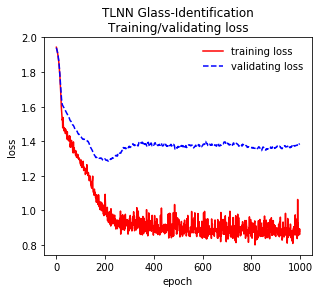

In [16]:
#----------------------------------------
# Summarize history for loss.

plt.figure('TLNN Glass-Identification loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('TLNN Glass-Identification' + '\n' + 'Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)
plt.show()


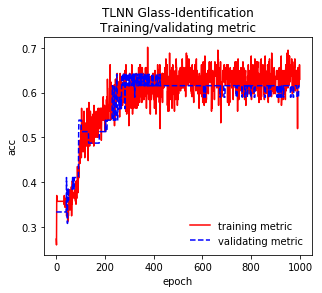

In [17]:
#----------------------------------------
# Summarize history for metric.

plt.figure('TLNN Glass-Identification metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('TLNN Glass-Identification' + '\n' + 'Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
plt.show()
